# 「キッチン」特徴量を抽出してみる！

In [20]:
import pandas as pd
import torch
import transformers
from transformers import BertTokenizer, BertJapaneseTokenizer
import re
import requests
import unicodedata
import nltk
from nltk.corpus import wordnet
from bs4 import BeautifulSoup
nltk.download(['wordnet', 'stopwords', 'punkt'])

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/koshidatatsuo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/koshidatatsuo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/koshidatatsuo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [21]:
train_df = pd.read_csv("../data/outer_data/train.csv")
test_df = pd.read_csv('../data/outer_data/test.csv')

In [22]:
train_df.head(2)

,id,賃料,所在地,アクセス,間取り,築年数,方角,面積,所在階,バス・トイレ,キッチン,放送・通信,室内設備,駐車場,周辺環境,建物構造,契約期間
0,1,75000,東京都北区滝野川３丁目,都営三田線\t西巣鴨駅\t徒歩4分\t\t埼京線\t板橋駅\t徒歩14分\t\t都電荒川線\...,1K,9年9ヶ月,南東,20.01m2,1階／12階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄便座,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯,インターネット対応／\tCATV／\tCSアンテナ／\tBSアンテナ,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\t敷...,駐輪場\t空有,【小学校】 495m\t【大学】 461m\t【小学校】 962m\t【公園】 1103m\...,RC（鉄筋コンクリート）,2年間
1,2,76000,東京都中央区月島３丁目,都営大江戸線\t勝どき駅\t徒歩5分\t\t有楽町線\t月島駅\t徒歩9分\t\t日比谷線\...,1R,44年10ヶ月,NaN,16.5m2,5階／10階建,専用トイレ／\tシャワー／\t温水洗浄便座,ガスコンロ／\tシステムキッチン\t／\t給湯,インターネット対応,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\t敷...,駐輪場\t空有\t駐車場\t無\tバイク置き場\t無,【スーパー】 1283m,鉄骨造,2年間


### テキスト整形用関数群

In [23]:
def clean_text(text):
    replaced_text = text.lower()
    replaced_text = re.sub(r'[【】]', ' ', replaced_text)       # 【】の除去
    replaced_text = re.sub(r'[（）()]', ' ', replaced_text)     # （）の除去
    replaced_text = re.sub(r'[［］\[\]]', ' ', replaced_text)   # ［］の除去
    replaced_text = re.sub(r'[『』]', ' ', replaced_text)   # 『』の除去
    replaced_text = re.sub(r'[@＠]\w+', '', replaced_text)  # メンションの除去
    replaced_text = re.sub(r'https?:\/\/.*?[\r\n ]', '', replaced_text)  # URLの除去
    replaced_text = re.sub(r'　', ' ', replaced_text)  # 全角空白の除去
    replaced_text = re.sub(r' ', '', replaced_text)  # 空白の除去
    return replaced_text


def clean_html_tags(html_text):
    soup = BeautifulSoup(html_text, 'html.parser')
    cleaned_text = soup.get_text()
    cleaned_text = ''.join(cleaned_text.splitlines())
    return cleaned_text


def clean_html_and_js_tags(html_text):
    soup = BeautifulSoup(html_text, 'html.parser')
    [x.extract() for x in soup.findAll(['script', 'style'])]
    cleaned_text = soup.get_text()
    cleaned_text = ''.join(cleaned_text.splitlines())
    return cleaned_text


def clean_url(html_text):
    cleaned_text = re.sub(r'http\S+', '', html_text)
    return cleaned_text


def normalize(text):
    normalized_text = normalize_unicode(text)
    normalized_text = normalize_number(normalized_text)
    normalized_text = lower_text(normalized_text)
    return normalized_text


def lower_text(text):
    return text.lower()


def normalize_unicode(text, form='NFKC'):
    normalized_text = unicodedata.normalize(form, text)
    return normalized_text


def normalize_number(text):
    replaced_text = re.sub(r'\d+', '0', text)
    return replaced_text


def text_cleaning(text):
    text = clean_text(text)
    text = clean_html_tags(text)
    text = clean_html_and_js_tags(text)
    text = clean_url(text)
    text = normalize(text)
    text = lower_text(text)
    text = normalize_unicode(text)

    return text

まずは「キッチン」特徴量について下準備

In [24]:
kitchen = train_df['キッチン']

In [25]:
for i in range(len(kitchen)):
    try:
        kitchen.loc[i] = clean_text(kitchen.loc[i])
        kitchen.loc[i] = kitchen.loc[i].replace('／', '')
        kitchen.loc[i] = kitchen.loc[i].replace('\t', ' ')
    except:
        pass

/var/folders/qh/20ftf7rn5_58_rk3l25kt1nr0000gn/T/ipykernel_7426/293549651.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kitchen.loc[i] = clean_text(kitchen.loc[i])
/var/folders/qh/20ftf7rn5_58_rk3l25kt1nr0000gn/T/ipykernel_7426/293549651.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kitchen.loc[i] = kitchen.loc[i].replace('／', '')
/var/folders/qh/20ftf7rn5_58_rk3l25kt1nr0000gn/T/ipykernel_7426/293549651.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

In [26]:
from cmath import nan


kitchen_points = []
for i in range(len(kitchen)):
    text = kitchen.loc[i]
    kitchen_point = []
    try:
        if 'ガスコンロ' in text:
            kitchen_point.append(1)
        else:
            kitchen_point.append(0)
        
        if 'コンロ2口' in text:
            kitchen_point.append(1)
        else:
            kitchen_point.append(0)

        if 'システムキッチン' in text:
            kitchen_point.append(1)
        else:
            kitchen_point.append(0)

        if '給湯' in text:
            kitchen_point.append(1)
        else:
            kitchen_point.append(0)

        if '独立キッチン' in text:
            kitchen_point.append(1)
        else:
            kitchen_point.append(0)

        if 'コンロ3口' in text:
            kitchen_point.append(1)
        else:
            kitchen_point.append(0)

        if ('ih' in text) or ('IH' in text):
            kitchen_point.append(1)
        else:
            kitchen_point.append(0)

        if '電気コンロ' in text:
            kitchen_point.append(1)
        else:
            kitchen_point.append(0)
    except:#「キッチン」特徴量に何も記載がない場合
        kitchen_point = [0 for k in range(8)] #ホントに0埋めで良いの？

    kitchen_points.append( kitchen_point )

kitchen_points = pd.DataFrame( kitchen_points )

In [27]:
kitchen_points.columns = ['ガスコンロ', 'コンロ2口', 'システムキッチン', '給湯', '独立キッチン', 'コンロ3口', 'IHコンロ', '電気コンロ']

In [28]:
kitchen_points.to_csv('../data/handmade_data/kitchen_points.csv', index=False)

テストデータに対しても同じ処理を行う

In [29]:
test_kitchen = test_df['キッチン']

In [30]:
for i in range(len(test_kitchen)):
    try:
        test_kitchen.loc[i] = clean_text(test_kitchen.loc[i])
        test_kitchen.loc[i] = test_kitchen.loc[i].replace('／', '')
        test_kitchen.loc[i] = test_kitchen.loc[i].replace('\t', ' ')
    except:
        pass

/var/folders/qh/20ftf7rn5_58_rk3l25kt1nr0000gn/T/ipykernel_7426/1740152749.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_kitchen.loc[i] = clean_text(test_kitchen.loc[i])
/var/folders/qh/20ftf7rn5_58_rk3l25kt1nr0000gn/T/ipykernel_7426/1740152749.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_kitchen.loc[i] = test_kitchen.loc[i].replace('／', '')
/var/folders/qh/20ftf7rn5_58_rk3l25kt1nr0000gn/T/ipykernel_7426/1740152749.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

In [31]:
from cmath import nan


test_kitchen_points = []
for i in range(len(test_kitchen)):
    text = test_kitchen.loc[i]
    test_kitchen_point = []
    try:
        if 'ガスコンロ' in text:
            test_kitchen_point.append(1)
        else:
            test_kitchen_point.append(0)
        
        if 'コンロ2口' in text:
            test_kitchen_point.append(1)
        else:
            test_kitchen_point.append(0)

        if 'システムキッチン' in text:
            test_kitchen_point.append(1)
        else:
            test_kitchen_point.append(0)

        if '給湯' in text:
            test_kitchen_point.append(1)
        else:
            test_kitchen_point.append(0)

        if '独立キッチン' in text:
            test_kitchen_point.append(1)
        else:
            test_kitchen_point.append(0)

        if 'コンロ3口' in text:
            test_kitchen_point.append(1)
        else:
            test_kitchen_point.append(0)

        if ('ih' in text) or ('IH' in text):
            test_kitchen_point.append(1)
        else:
            test_kitchen_point.append(0)

        if '電気コンロ' in text:
            test_kitchen_point.append(1)
        else:
            test_kitchen_point.append(0)
    except:#「キッチン」特徴量に何も記載がない場合
        test_kitchen_point = [0 for k in range(8)] #ホントに0埋めで良いの？

    test_kitchen_points.append( test_kitchen_point )

test_kitchen_points = pd.DataFrame( test_kitchen_points )

In [32]:
test_kitchen_points.columns = ['ガスコンロ', 'コンロ2口', 'システムキッチン', '給湯', '独立キッチン', 'コンロ3口', 'IHコンロ', '電気コンロ']

In [33]:
test_kitchen_points.to_csv('../data/test_data/test_kitchen_points.csv', index=False)

### 新しく作ったこの特徴量で、LightGBMのGBDTを動かしてみる！

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy as sp
import lightgbm as lgb
import category_encoders as ce
# import mojimoji
import re
from cmath import nan
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import optuna
from sklearn.metrics import mean_squared_error
import japanize_matplotlib
from sklearn.model_selection import KFold
import xgboost
from catboost import CatBoostRegressor
from catboost import Pool

###訓練データの読み込み
house_age = pd.read_csv('../data/handmade_data/house_age.csv')
area_size = pd.read_csv('../data/handmade_data/area_size.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
contract_span = pd.read_csv('../data/handmade_data/contract_span.csv')#欠損値をゼロ埋めした契約期間
contract_span2 = pd.read_csv('../data/handmade_data/contract_span2.csv')#欠損値を欠損値のままにした契約期間
reg_rent = pd.read_csv('../data/handmade_data/reg_rent.csv')
floor_scores = pd.read_csv('../data/handmade_data/floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「所在階」
floor_scores2 = pd.read_csv('../data/handmade_data/floor_scores2.csv')#「所在階」と「全体の階数」が独立している「所在階」
Floor_scores = pd.read_csv('../data/handmade_data/capital_floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「全体の階数」
Floor_scores2 = pd.read_csv('../data/handmade_data/capital_floor_scores2.csv')#「所在階」と「全体の階数」が独立している「全体の階数」
stations = pd.read_csv('../data/handmade_data/stations.csv')
minits = pd.read_csv('../data/handmade_data/minits.csv')
addresses = pd.read_csv('../data/handmade_data/addresses.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
building = pd.read_csv('../data/handmade_data/building.csv')
buildings = pd.read_csv('../data/handmade_data/buildings.csv')
land_aveprice = pd.read_csv('../data/handmade_data/land_aveprice.csv')
land_aveprice.columns = ['平均地価']
over100m2 = pd.read_csv('../data/handmade_data/over100m2.csv')
bt75and100m2 = pd.read_csv('../data/handmade_data/bt75and100m2.csv')
bt50and75m2 = pd.read_csv('../data/handmade_data/bt50and75m2.csv')
sepa_bath_toilets = pd.read_csv('../data/handmade_data/sepa_bath_toilets.csv')
sepa_bath_toilets.columns = ['バス・トイレ別']
washlets = pd.read_csv('../data/handmade_data/washlets.csv')
area_per_rooms = pd.read_csv('../data/handmade_data/area_per_rooms.csv')
kitchen_points = pd.read_csv('../data/handmade_data/kitchen_points.csv')

rent = pd.read_csv('../data/handmade_data/rent.csv')


##テストデータの読み込み
test_house_age = pd.read_csv('../data/test_data/test_house_age.csv')
test_area_size = pd.read_csv('../data/test_data/test_area_size.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_contract_span = pd.read_csv('../data/test_data/test_contract_span.csv')
test_contract_span2 = pd.read_csv('../data/test_data/test_contract_span2.csv')
test_contract_span2.columns = ['契約期間']
test_reg_rent = pd.read_csv('../data/test_data/test_reg_rent.csv')
test_floor_scores = pd.read_csv('../data/test_data/test_floor_scores.csv')
test_floor_scores2 = pd.read_csv('../data/test_data/test_floor_scores2.csv')
test_Floor_scores = pd.read_csv('../data/test_data/test_capital_floor_scores.csv')
test_Floor_scores2 = pd.read_csv('../data/test_data/test_capital_floor_scores2.csv')
test_stations = pd.read_csv('../data/test_data/test_stations.csv')
test_minits = pd.read_csv('../data/test_data/test_minits.csv')
test_addresses = pd.read_csv('../data/test_data/test_addresses.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_building = pd.read_csv('../data/test_data/test_building.csv')
test_buildings = pd.read_csv('../data/test_data/test_buildings.csv')
test_land_aveprice = pd.read_csv('../data/test_data/test_land_aveprice.csv')
test_land_aveprice.columns = ['平均地価']
test_over100m2 = pd.read_csv('../data/test_data/test_over100m2.csv')
test_bt75and100m2 = pd.read_csv('../data/test_data/test_bt75and100m2.csv')
test_bt50and75m2 = pd.read_csv('../data/test_data/test_bt50and75m2.csv')
test_sepa_bath_toilets = pd.read_csv('../data/test_data/test_sepa_bath_toilets.csv')
test_sepa_bath_toilets.columns = ['バス・トイレ別']
test_washlets = pd.read_csv('../data/test_data/test_washlets.csv')
test_area_per_rooms = pd.read_csv('../data/test_data/test_area_per_rooms.csv')
test_kitchen_points = pd.read_csv('../data/test_data/test_kitchen_points.csv')


X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, stations, minits, land_aveprice, addresses, room_arrange[["部屋数","L","D","S"]], sepa_bath_toilets, buildings, over100m2, bt75and100m2, bt50and75m2, area_per_rooms, kitchen_points], axis=1)
y_train = pd.read_csv('../data/handmade_data/rent.csv')
y_train.loc[[5775], '賃料'] = y_train.loc[[5775], '賃料']/10
X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, test_stations, test_minits, test_land_aveprice, test_addresses, test_room_arrange[["部屋数","L","D",'S']],test_sepa_bath_toilets, test_buildings, test_over100m2, test_bt75and100m2, test_bt50and75m2, test_area_per_rooms, test_kitchen_points], axis=1)
category_lists = ['定期借家','最寄り駅', '所在地', 'L', 'D', 'S', 'バス・トイレ別','建物構造','100m^2以上', '75m^2以上100m^2未満', '50m^2以上75m^2未満', 'ガスコンロ', 'コンロ2口', 'システムキッチン', '給湯', '独立キッチン', 'コンロ3口', 'IHコンロ', '電気コンロ']

In [11]:
X_train.columns

Index(['築年数', '面積', '契約期間', '定期借家', '所在階', '全体の階数', '最寄り駅', '所要時間', '平均地価',
       '所在地', '部屋数', 'L', 'D', 'S', 'バス・トイレ別', '建物構造', '100m^2以上',
       '75m^2以上100m^2未満', '50m^2以上75m^2未満', '一部屋あたりの面積', 'ガスコンロ', 'コンロ2口',
       'システムキッチン', '給湯', '独立キッチン', 'コンロ3口', 'IHコンロ', '電気コンロ'],
      dtype='object')

Start training...
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001357 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2371
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 27
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48832.9	valid_1's rmse: 50218.4


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[20]	training's rmse: 34595.2	valid_1's rmse: 37863.6
[30]	training's rmse: 26164.6	valid_1's rmse: 31069
[40]	training's rmse: 21258.9	valid_1's rmse: 27336.1
[50]	training's rmse: 18045.2	valid_1's rmse: 24974.3
[60]	training's rmse: 16084.6	valid_1's rmse: 23513.7
[70]	training's rmse: 14698.9	valid_1's rmse: 22466.5
[80]	training's rmse: 13774.7	valid_1's rmse: 21794.2
[90]	training's rmse: 13087.1	valid_1's rmse: 21314.5
[100]	training's rmse: 12506.1	valid_1's rmse: 20847.4
[110]	training's rmse: 11990.6	valid_1's rmse: 20486.3
[120]	training's rmse: 11556.6	valid_1's rmse: 20179.4
[130]	training's rmse: 11137.6	valid_1's rmse: 19903.9
[140]	training's rmse: 10783	valid_1's rmse: 19690.7
[150]	training's rmse: 10484.5	valid_1's rmse: 19501
[160]	training's rmse: 10196.3	valid_1's rmse: 19293.4
[170]	training's rmse: 9931.55	valid_1's rmse: 19103.6
[180]	training's rmse: 9713.56	valid_1's rmse: 18972.7
[190]	training's rmse: 9497.62	valid_1's rmse: 18809.6
[200]	training's rmse: 9

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[30]	training's rmse: 26829.1	valid_1's rmse: 28261.5
[40]	training's rmse: 22164.8	valid_1's rmse: 24003.8
[50]	training's rmse: 19220.8	valid_1's rmse: 21249.7
[60]	training's rmse: 17411.4	valid_1's rmse: 19935.9
[70]	training's rmse: 16132.7	valid_1's rmse: 19185.1
[80]	training's rmse: 15168.7	valid_1's rmse: 18665.1
[90]	training's rmse: 14389.4	valid_1's rmse: 18427.3
[100]	training's rmse: 13793.2	valid_1's rmse: 18250.6
[110]	training's rmse: 13270.3	valid_1's rmse: 18072
[120]	training's rmse: 12824.1	valid_1's rmse: 17975.8
[130]	training's rmse: 12407.9	valid_1's rmse: 17915.6
[140]	training's rmse: 12056.3	valid_1's rmse: 17914.9
[150]	training's rmse: 11703.3	valid_1's rmse: 17882.2
[160]	training's rmse: 11379.6	valid_1's rmse: 17846.9
[170]	training's rmse: 11094.8	valid_1's rmse: 17817.7
[180]	training's rmse: 10843.2	valid_1's rmse: 17807.8
[190]	training's rmse: 10588.5	valid_1's rmse: 17811.6
[200]	training's rmse: 10351.4	valid_1's rmse: 17796.6
[210]	training's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[20]	training's rmse: 35031.8	valid_1's rmse: 34570.7
[30]	training's rmse: 26799	valid_1's rmse: 26652.9
[40]	training's rmse: 22073.2	valid_1's rmse: 22493.5
[50]	training's rmse: 19111.4	valid_1's rmse: 20088.2
[60]	training's rmse: 17248.9	valid_1's rmse: 18909.9
[70]	training's rmse: 16016.3	valid_1's rmse: 18181.8
[80]	training's rmse: 15088.5	valid_1's rmse: 17746.5
[90]	training's rmse: 14343.3	valid_1's rmse: 17452.2
[100]	training's rmse: 13732.9	valid_1's rmse: 17233.9
[110]	training's rmse: 13243.4	valid_1's rmse: 17096.1
[120]	training's rmse: 12773.3	valid_1's rmse: 17002.8
[130]	training's rmse: 12363	valid_1's rmse: 16928.5
[140]	training's rmse: 11985.6	valid_1's rmse: 16860.6
[150]	training's rmse: 11631	valid_1's rmse: 16851.3
[160]	training's rmse: 11298.2	valid_1's rmse: 16801.2
[170]	training's rmse: 11023.8	valid_1's rmse: 16761.9
[180]	training's rmse: 10738.6	valid_1's rmse: 16701.9
[190]	training's rmse: 10484.1	valid_1's rmse: 16653.3
[200]	training's rmse: 1

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001944 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2370
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 27
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49047.1	valid_1's rmse: 48050.6
[20]	training's rmse: 34784.7	valid_1's rmse: 35705.1
[30]	training's rmse: 26231.9	valid_1's rmse: 29091.5
[40]	training's rmse: 21426.3	valid_1's rmse: 25641
[50]	training's rmse: 18373.2	valid_1's rmse: 23826.6
[60]	training's rmse: 16459.8	valid_1's rmse: 22802.8
[70]	training's rmse: 15228.9	valid_1's rmse: 22307.9
[80]	training's rmse: 14329.3	valid_1's rmse: 21958.8
[90]	training's rmse: 13609.9	valid_1's rmse: 21597.3
[100]	training's rmse: 13054.5	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[10]	training's rmse: 48737.3	valid_1's rmse: 51278.8
[20]	training's rmse: 35151.4	valid_1's rmse: 37204.4
[30]	training's rmse: 27127.9	valid_1's rmse: 28749.6
[40]	training's rmse: 22499.8	valid_1's rmse: 23888.1
[50]	training's rmse: 19334.7	valid_1's rmse: 21094.3
[60]	training's rmse: 17433.1	valid_1's rmse: 19510.5
[70]	training's rmse: 16130.4	valid_1's rmse: 18601.8
[80]	training's rmse: 15143.5	valid_1's rmse: 18034.8
[90]	training's rmse: 14410.3	valid_1's rmse: 17606.7
[100]	training's rmse: 13828.9	valid_1's rmse: 17363.4
[110]	training's rmse: 13333.9	valid_1's rmse: 17143.5
[120]	training's rmse: 12918.6	valid_1's rmse: 16970.7
[130]	training's rmse: 12535.3	valid_1's rmse: 16871.2
[140]	training's rmse: 12207.4	valid_1's rmse: 16748.3
[150]	training's rmse: 11874.3	valid_1's rmse: 16660.9
[160]	training's rmse: 11604.6	valid_1's rmse: 16548.3
[170]	training's rmse: 11335.3	valid_1's rmse: 16466.8
[180]	training's rmse: 11063.2	valid_1's rmse: 16322.9
[190]	training's rm

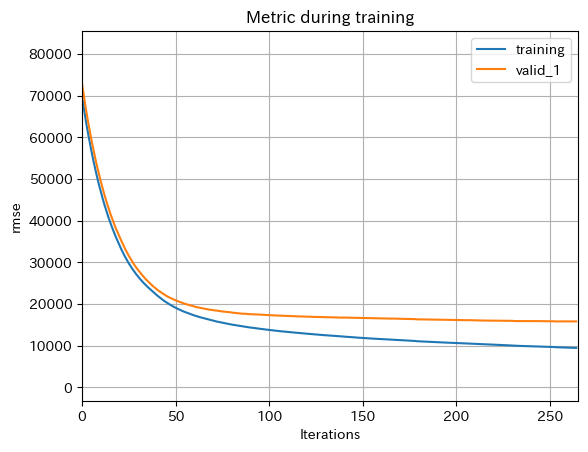

,importance
面積,4.577295e+14
L,3.996566e+14
平均地価,2.013485e+14
最寄り駅,9.485228e+13
築年数,6.839352e+13
所在地,3.843070e+13
全体の階数,2.921708e+13
契約期間,1.549776e+13
所在階,1.066769e+13
システムキッチン,8.501353e+12


In [16]:
n_split = 5
cv = KFold(n_splits=n_split, shuffle=True, random_state=0)
valid_rmses_list = []
valid_GBDT = np.zeros(X_train.shape[0])
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index,:]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train.loc[train_index]
    y_val = y_train.loc[valid_index]

    evals_result = {} 
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

    params = {
        'objective':'regression',
        'boosting_type':'gbdt',
        'metrics':'rmse',
        'learning_rate':0.05,
        'reg_lambda':  5.009615137983937e-06,
        'max_bin': 346,
        'num_leaves': 91,
    }

    print('Start training...')
    model = lgb.train(
                        params,
                        lgb_train, 
                        valid_sets=[lgb_train, lgb_eval], 
                        verbose_eval=10, 
                        num_boost_round=1000, 
                        early_stopping_rounds=10,
                        categorical_feature = category_lists,
                        evals_result=evals_result,
                        )

    pred_y_val = model.predict(X_val)
    rmse = mean_squared_error(y_val, pred_y_val, squared=False)
    valid_rmses_list.append(rmse)

valid_rmse = np.mean(valid_rmses_list)
print("whole valid rmse:", valid_rmse)

print('Start predicting...')
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
print('Plot metrics during training...')
ax = lgb.plot_metric(evals_result, metric='rmse')
plt.show()
# feature importanceを表示
importance = pd.DataFrame(model.feature_importance(importance_type = "gain"), index=X_train.columns, columns=['importance'])
df_importance = pd.DataFrame(importance)
df_importance = df_importance.sort_values('importance', ascending=False) # 降順ソート
display(df_importance)

### スコアが良くなった！要チューニング！

In [5]:
cv = KFold(n_splits=5, shuffle=True, random_state=0)
rmse_scores = []
X_train['KFold'] = -1
#foldはvalidの対象となる値で０から４
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_train.loc[valid_index,'KFold'] = fold_id
    y_train.loc[valid_index,'KFold'] = fold_id

def objective(trial):
    #foldはvalidの対象となる値で０から４
    for fold in range(5):
        X_tr = X_train[X_train['KFold']!=fold].drop('KFold',axis=1)
        X_val = X_train[X_train['KFold']==fold].drop('KFold',axis=1)
        y_tr = y_train[y_train['KFold']!=fold].drop('KFold',axis=1)
        y_val = y_train[y_train['KFold']==fold].drop('KFold',axis=1)

        lgb_train = lgb.Dataset(X_tr, y_tr)
        lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
        params = {
            'objective':'regression',
            'metrics':'rmse',
            'learning_rate':0.05,
            'reg_lambda': trial.suggest_float('reg_lambda', 0.0000001, 0.0001, log=True),
            'max_bin': trial.suggest_int('max_bin', 255, 600),
            'num_leaves': trial.suggest_int('num_leaves', 50, 128),
        }

        model = lgb.train(
                            params,
                            lgb_train, 
                            valid_sets=[lgb_train, lgb_eval], 
                            verbose_eval=10, 
                            num_boost_round=1000, 
                            early_stopping_rounds=10,
                            categorical_feature = category_lists
                            )

        y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)
        rmse_score = mean_squared_error(y_val, y_pred_val, squared=False)
    loss = np.mean(rmse_score)
    return loss

In [6]:
study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=0))
study.optimize(objective, n_trials=40)

[I 2022-10-01 23:21:38,662] A new study created in memory with name: no-name-09ed796d-e9e3-41c9-acd0-f66a55c0c0c6
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/pyt

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002367 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3362
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48774.1	valid_1's rmse: 50175.9
[20]	training's rmse: 34438	valid_1's rmse: 37830
[30]	training's rmse: 26097	valid_1's rmse: 31180.4
[40]	training's rmse: 20913.8	valid_1's rmse: 27428.7
[50]	training's rmse: 17577.3	valid_1's rmse: 25189.2
[60]	training's rmse: 15582.1	valid_1's rmse: 23920.4
[70]	training's rmse: 14190.9	valid_1's rmse: 23020.9
[80]	training's rmse: 13098.3	valid_1's rmse: 22310.2
[90]	training's rmse: 12328.4	valid_1's rmse: 21866.8
[100]	training's rmse: 11703.7	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001522 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3362
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48979.5	valid_1's rmse: 49580.4
[20]	training's rmse: 34922.9	valid_1's rmse: 36072.5
[30]	training's rmse: 26903.5	valid_1's rmse: 28666.2
[40]	training's rmse: 22219.2	valid_1's rmse: 24405.9
[50]	training's rmse: 19202.5	valid_1's rmse: 21617.9
[60]	training's rmse: 17382	valid_1's rmse: 20093.9
[70]	training's rmse: 16147.8	valid_1's rmse: 19142.8
[80]	training's rmse: 15262.1	valid_1's rmse: 18570
[90]	training's rmse: 14523.1	valid_1's rmse: 18298
[100]	training's rmse: 13951.8	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[20]	training's rmse: 35363.6	valid_1's rmse: 33936.1
[30]	training's rmse: 27167.8	valid_1's rmse: 26129.3
[40]	training's rmse: 22415.2	valid_1's rmse: 21885.5
[50]	training's rmse: 19387.1	valid_1's rmse: 19531.4
[60]	training's rmse: 17461.1	valid_1's rmse: 18405.4
[70]	training's rmse: 16358.8	valid_1's rmse: 17872.7
[80]	training's rmse: 15484.4	valid_1's rmse: 17590.5
[90]	training's rmse: 14788.2	valid_1's rmse: 17371
[100]	training's rmse: 14169.2	valid_1's rmse: 17241.3
[110]	training's rmse: 13718.7	valid_1's rmse: 17117
[120]	training's rmse: 13286.2	valid_1's rmse: 16988.8
[130]	training's rmse: 12906.8	valid_1's rmse: 16871.8
[140]	training's rmse: 12592.2	valid_1's rmse: 16766.7
[150]	training's rmse: 12184.8	valid_1's rmse: 16663
[160]	training's rmse: 11864.3	valid_1's rmse: 16559.3
[170]	training's rmse: 11610.3	valid_1's rmse: 16515.6
[180]	training's rmse: 11362.6	valid_1's rmse: 16448.5
[190]	training's rmse: 11123.9	valid_1's rmse: 16420.7
[200]	training's rmse: 1

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[10]	training's rmse: 49185	valid_1's rmse: 48161.4
[20]	training's rmse: 35026	valid_1's rmse: 35162.2
[30]	training's rmse: 26656.1	valid_1's rmse: 28082.2
[40]	training's rmse: 21768.7	valid_1's rmse: 24345
[50]	training's rmse: 18621	valid_1's rmse: 22338.5
[60]	training's rmse: 16734.4	valid_1's rmse: 21235.3
[70]	training's rmse: 15555.5	valid_1's rmse: 20637.1
[80]	training's rmse: 14703.8	valid_1's rmse: 20290
[90]	training's rmse: 14070.9	valid_1's rmse: 20071.1
[100]	training's rmse: 13558.6	valid_1's rmse: 19879.3
[110]	training's rmse: 13147.6	valid_1's rmse: 19725
[120]	training's rmse: 12776.7	valid_1's rmse: 19642.2
[130]	training's rmse: 12457.2	valid_1's rmse: 19623.3
[140]	training's rmse: 12111.8	valid_1's rmse: 19567.9
[150]	training's rmse: 11783.9	valid_1's rmse: 19499.2
[160]	training's rmse: 11524.5	valid_1's rmse: 19514.4
Early stopping, best iteration is:
[150]	training's rmse: 11783.9	valid_1's rmse: 19499.2
[LightGBM] [Warning] Auto-choosing row-wise multi-t

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[20]	training's rmse: 34937.4	valid_1's rmse: 36914.1
[30]	training's rmse: 26847.8	valid_1's rmse: 28559.4
[40]	training's rmse: 22239.5	valid_1's rmse: 23846.5
[50]	training's rmse: 19025.8	valid_1's rmse: 21048.7
[60]	training's rmse: 17155.5	valid_1's rmse: 19636.5
[70]	training's rmse: 15868.7	valid_1's rmse: 18808.9
[80]	training's rmse: 14868.2	valid_1's rmse: 18335.5
[90]	training's rmse: 14174.9	valid_1's rmse: 18015
[100]	training's rmse: 13607.5	valid_1's rmse: 17741.5
[110]	training's rmse: 13191.7	valid_1's rmse: 17566.6
[120]	training's rmse: 12827.9	valid_1's rmse: 17417
[130]	training's rmse: 12465.4	valid_1's rmse: 17304.7
[140]	training's rmse: 12117.4	valid_1's rmse: 17228.3
[150]	training's rmse: 11771.9	valid_1's rmse: 17171.1
[160]	training's rmse: 11488.4	valid_1's rmse: 17103
[170]	training's rmse: 11225.3	valid_1's rmse: 17041.2
[180]	training's rmse: 10985.7	valid_1's rmse: 17000.6
[190]	training's rmse: 10770.7	valid_1's rmse: 16931.6
[200]	training's rmse: 1

[I 2022-10-01 23:21:56,724] Trial 0 finished with value: 16416.112284518476 and parameters: {'reg_lambda': 4.430375245218262e-06, 'max_bin': 502, 'num_leaves': 97}. Best is trial 0 with value: 16416.112284518476.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categ

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002158 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2941
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48699.6	valid_1's rmse: 49998.9
[20]	training's rmse: 34312.3	valid_1's rmse: 37776.3
[30]	training's rmse: 25818.6	valid_1's rmse: 30874.6
[40]	training's rmse: 20728.6	valid_1's rmse: 27078
[50]	training's rmse: 17451.8	valid_1's rmse: 24796.8
[60]	training's rmse: 15509.7	valid_1's rmse: 23421.5
[70]	training's rmse: 14096.4	valid_1's rmse: 22416.1
[80]	training's rmse: 13094.3	valid_1's rmse: 21727.7
[90]	training's rmse: 12328.6	valid_1's rmse: 21173.1
[100]	training's rmse: 11659.2	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001339 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2938
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48964.9	valid_1's rmse: 49749.8
[20]	training's rmse: 34863	valid_1's rmse: 36308.3
[30]	training's rmse: 26611.3	valid_1's rmse: 28872.6
[40]	training's rmse: 21805.8	valid_1's rmse: 24551.2
[50]	training's rmse: 18861.7	valid_1's rmse: 21714.9
[60]	training's rmse: 17004.1	valid_1's rmse: 20401.3
[70]	training's rmse: 15657.7	valid_1's rmse: 19391.7
[80]	training's rmse: 14646.1	valid_1's rmse: 18853.9
[90]	training's rmse: 13840.5	valid_1's rmse: 18489.9
[100]	training's rmse: 13209.8	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002086 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2939
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48863	valid_1's rmse: 48691.6
[20]	training's rmse: 34875.1	valid_1's rmse: 34299.5
[30]	training's rmse: 26740.7	valid_1's rmse: 26521.7
[40]	training's rmse: 22012.7	valid_1's rmse: 22530.4
[50]	training's rmse: 19048.2	valid_1's rmse: 20239.3
[60]	training's rmse: 17101.5	valid_1's rmse: 18970.1
[70]	training's rmse: 15795.4	valid_1's rmse: 18218.8
[80]	training's rmse: 14758	valid_1's rmse: 17881.9
[90]	training's rmse: 13987.8	valid_1's rmse: 17586.5
[100]	training's rmse: 13383.4	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[10]	training's rmse: 49167.2	valid_1's rmse: 48067.1
[20]	training's rmse: 34722.4	valid_1's rmse: 35321.4
[30]	training's rmse: 26249.7	valid_1's rmse: 28165.5
[40]	training's rmse: 21307.7	valid_1's rmse: 24319.8
[50]	training's rmse: 18293	valid_1's rmse: 22457.5
[60]	training's rmse: 16510.9	valid_1's rmse: 21393.6
[70]	training's rmse: 15259.9	valid_1's rmse: 20705.9
[80]	training's rmse: 14335.8	valid_1's rmse: 20206.7
[90]	training's rmse: 13613.2	valid_1's rmse: 19826.6
[100]	training's rmse: 13050.7	valid_1's rmse: 19572.6
[110]	training's rmse: 12592.9	valid_1's rmse: 19365.5
[120]	training's rmse: 12207.1	valid_1's rmse: 19308.5
[130]	training's rmse: 11839.4	valid_1's rmse: 19167.3
[140]	training's rmse: 11493.5	valid_1's rmse: 19086.1
[150]	training's rmse: 11191.3	valid_1's rmse: 19036.2
[160]	training's rmse: 10891.4	valid_1's rmse: 18941.8
[170]	training's rmse: 10619.3	valid_1's rmse: 18899.4
[180]	training's rmse: 10334.1	valid_1's rmse: 18836.2
[190]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[20]	training's rmse: 34949.3	valid_1's rmse: 36966.4
[30]	training's rmse: 26628.3	valid_1's rmse: 28402.6
[40]	training's rmse: 21937.4	valid_1's rmse: 23539.2
[50]	training's rmse: 18795.9	valid_1's rmse: 20827
[60]	training's rmse: 16878.5	valid_1's rmse: 19529.9
[70]	training's rmse: 15552.7	valid_1's rmse: 18887.9
[80]	training's rmse: 14574	valid_1's rmse: 18422.4
[90]	training's rmse: 13848.2	valid_1's rmse: 18136.3
[100]	training's rmse: 13268.2	valid_1's rmse: 17999.5
[110]	training's rmse: 12786.4	valid_1's rmse: 17866.4
[120]	training's rmse: 12376.8	valid_1's rmse: 17755.6
[130]	training's rmse: 11970.3	valid_1's rmse: 17715
[140]	training's rmse: 11606.7	valid_1's rmse: 17607.2
[150]	training's rmse: 11265.8	valid_1's rmse: 17497.8
[160]	training's rmse: 10956.9	valid_1's rmse: 17433.4
[170]	training's rmse: 10676.7	valid_1's rmse: 17385
[180]	training's rmse: 10399.2	valid_1's rmse: 17371
[190]	training's rmse: 10183.9	valid_1's rmse: 17320.9
[200]	training's rmse: 9947.

[I 2022-10-01 23:22:09,441] Trial 1 finished with value: 17151.78001526484 and parameters: {'reg_lambda': 4.311710058685494e-06, 'max_bin': 401, 'num_leaves': 101}. Best is trial 0 with value: 16416.112284518476.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categ

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002197 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3586
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48370.2	valid_1's rmse: 49991.3
[20]	training's rmse: 33848.9	valid_1's rmse: 37655
[30]	training's rmse: 25476.6	valid_1's rmse: 30895.3
[40]	training's rmse: 20437.2	valid_1's rmse: 27126
[50]	training's rmse: 17131.4	valid_1's rmse: 24672.8
[60]	training's rmse: 15158.7	valid_1's rmse: 23177.1
[70]	training's rmse: 13750.6	valid_1's rmse: 22077.8
[80]	training's rmse: 12685	valid_1's rmse: 21362
[90]	training's rmse: 11899.7	valid_1's rmse: 20925.4
[100]	training's rmse: 11265.7	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3590
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48755.8	valid_1's rmse: 49623
[20]	training's rmse: 34591.9	valid_1's rmse: 36159.8
[30]	training's rmse: 26549.2	valid_1's rmse: 28827.5
[40]	training's rmse: 21867.2	valid_1's rmse: 24367.6
[50]	training's rmse: 18887.4	valid_1's rmse: 21415.9
[60]	training's rmse: 17181.2	valid_1's rmse: 19886.9
[70]	training's rmse: 15951.1	valid_1's rmse: 18931.2
[80]	training's rmse: 14869.4	valid_1's rmse: 18156.1
[90]	training's rmse: 14083.9	valid_1's rmse: 17767.3
[100]	training's rmse: 13452.1	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002075 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3587
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48768.3	valid_1's rmse: 48317.8
[20]	training's rmse: 34770.6	valid_1's rmse: 33725.2
[30]	training's rmse: 26438.8	valid_1's rmse: 26001.9
[40]	training's rmse: 21721.1	valid_1's rmse: 21917
[50]	training's rmse: 18644.2	valid_1's rmse: 19579
[60]	training's rmse: 16728.4	valid_1's rmse: 18481.9
[70]	training's rmse: 15528.3	valid_1's rmse: 17887.4
[80]	training's rmse: 14609.8	valid_1's rmse: 17603.2
[90]	training's rmse: 13945.9	valid_1's rmse: 17434.7
[100]	training's rmse: 13386.6	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3590
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48801.9	valid_1's rmse: 47958.1
[20]	training's rmse: 34353.5	valid_1's rmse: 35455.1
[30]	training's rmse: 25910.9	valid_1's rmse: 28447.4
[40]	training's rmse: 21047.2	valid_1's rmse: 24769.5
[50]	training's rmse: 17944.8	valid_1's rmse: 22890.2
[60]	training's rmse: 16079.5	valid_1's rmse: 21814.4
[70]	training's rmse: 14950.9	valid_1's rmse: 21195.8
[80]	training's rmse: 14111.3	valid_1's rmse: 20724.9
[90]	training's rmse: 13460.1	valid_1's rmse: 20369.2
[100]	training's rmse: 12920.7	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[20]	training's rmse: 34322.2	valid_1's rmse: 36652.6
[30]	training's rmse: 26292.3	valid_1's rmse: 28494.3
[40]	training's rmse: 21582.4	valid_1's rmse: 23727.5
[50]	training's rmse: 18420.2	valid_1's rmse: 20792.8
[60]	training's rmse: 16590.7	valid_1's rmse: 19250.5
[70]	training's rmse: 15304.3	valid_1's rmse: 18496.9
[80]	training's rmse: 14410.4	valid_1's rmse: 18097.6
[90]	training's rmse: 13745.7	valid_1's rmse: 17934.1
[100]	training's rmse: 13246.9	valid_1's rmse: 17841.1
[110]	training's rmse: 12786.2	valid_1's rmse: 17733.2
[120]	training's rmse: 12401.7	valid_1's rmse: 17666.8
[130]	training's rmse: 12034.7	valid_1's rmse: 17592.1
[140]	training's rmse: 11699	valid_1's rmse: 17516.2
[150]	training's rmse: 11412.7	valid_1's rmse: 17475.8
[160]	training's rmse: 11118	valid_1's rmse: 17404
[170]	training's rmse: 10852.1	valid_1's rmse: 17355.5
[180]	training's rmse: 10619.9	valid_1's rmse: 17312.3
[190]	training's rmse: 10417.3	valid_1's rmse: 17265.2
[200]	training's rmse: 1

[I 2022-10-01 23:22:30,417] Trial 2 finished with value: 16250.119701489217 and parameters: {'reg_lambda': 2.054762512591133e-06, 'max_bin': 563, 'num_leaves': 126}. Best is trial 2 with value: 16250.119701489217.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('cate

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002314 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3462
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48765.2	valid_1's rmse: 50212.8
[20]	training's rmse: 34354.6	valid_1's rmse: 37857.9
[30]	training's rmse: 26003.2	valid_1's rmse: 31039.8
[40]	training's rmse: 20897.1	valid_1's rmse: 27223
[50]	training's rmse: 17602.1	valid_1's rmse: 24852.9
[60]	training's rmse: 15577.4	valid_1's rmse: 23386.4
[70]	training's rmse: 14203.8	valid_1's rmse: 22412.5
[80]	training's rmse: 13149.5	valid_1's rmse: 21717.2
[90]	training's rmse: 12339.9	valid_1's rmse: 21186
[100]	training's rmse: 11669.5	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001450 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3462
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48895.5	valid_1's rmse: 49535.1
[20]	training's rmse: 34842.4	valid_1's rmse: 36525.6
[30]	training's rmse: 26833.1	valid_1's rmse: 29151.6
[40]	training's rmse: 22189.9	valid_1's rmse: 24785.2
[50]	training's rmse: 19237.6	valid_1's rmse: 21755.8
[60]	training's rmse: 17463	valid_1's rmse: 20134.7
[70]	training's rmse: 16220.7	valid_1's rmse: 19075.4
[80]	training's rmse: 15307.2	valid_1's rmse: 18405.4
[90]	training's rmse: 14591	valid_1's rmse: 17943.8
[100]	training's rmse: 14000.1	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[10]	training's rmse: 49049.7	valid_1's rmse: 48653.5
[20]	training's rmse: 35208.5	valid_1's rmse: 34069.3
[30]	training's rmse: 26998.1	valid_1's rmse: 26110.1
[40]	training's rmse: 22252.1	valid_1's rmse: 21909.3
[50]	training's rmse: 19258.1	valid_1's rmse: 19569.1
[60]	training's rmse: 17322.2	valid_1's rmse: 18487.5
[70]	training's rmse: 16102.1	valid_1's rmse: 17977.6
[80]	training's rmse: 15156.1	valid_1's rmse: 17680.8
[90]	training's rmse: 14391.4	valid_1's rmse: 17556.2
[100]	training's rmse: 13810.9	valid_1's rmse: 17436.3
[110]	training's rmse: 13319	valid_1's rmse: 17259.1
[120]	training's rmse: 12903.5	valid_1's rmse: 17170.7
[130]	training's rmse: 12525.1	valid_1's rmse: 17070.9
[140]	training's rmse: 12179.2	valid_1's rmse: 17010.2
[150]	training's rmse: 11856.4	valid_1's rmse: 16958.2
[160]	training's rmse: 11551	valid_1's rmse: 16890.1
[170]	training's rmse: 11312.8	valid_1's rmse: 16860.1
[180]	training's rmse: 11054.3	valid_1's rmse: 16818.1
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[10]	training's rmse: 49221.4	valid_1's rmse: 48206.5
[20]	training's rmse: 35016.3	valid_1's rmse: 35386.8
[30]	training's rmse: 26633.1	valid_1's rmse: 28259
[40]	training's rmse: 21641.3	valid_1's rmse: 24346
[50]	training's rmse: 18634.1	valid_1's rmse: 22400.4
[60]	training's rmse: 16769.3	valid_1's rmse: 21385.2
[70]	training's rmse: 15621.7	valid_1's rmse: 20689.9
[80]	training's rmse: 14754.9	valid_1's rmse: 20252.9
[90]	training's rmse: 14101.3	valid_1's rmse: 19905.7
[100]	training's rmse: 13534.1	valid_1's rmse: 19663.6
[110]	training's rmse: 13019.6	valid_1's rmse: 19451.6
[120]	training's rmse: 12571.3	valid_1's rmse: 19272
[130]	training's rmse: 12220.3	valid_1's rmse: 19195.8
[140]	training's rmse: 11891.3	valid_1's rmse: 19093.4
[150]	training's rmse: 11551.6	valid_1's rmse: 18993
[160]	training's rmse: 11188.7	valid_1's rmse: 18901.7
[170]	training's rmse: 10925.7	valid_1's rmse: 18859.8
[180]	training's rmse: 10656.8	valid_1's rmse: 18821.8
[190]	training's rmse: 1038

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[10]	training's rmse: 48739.6	valid_1's rmse: 51066.2
[20]	training's rmse: 34969.1	valid_1's rmse: 37067
[30]	training's rmse: 27065.2	valid_1's rmse: 28991.3
[40]	training's rmse: 22375.7	valid_1's rmse: 24202.2
[50]	training's rmse: 19186.2	valid_1's rmse: 21507.1
[60]	training's rmse: 17354.6	valid_1's rmse: 20136.9
[70]	training's rmse: 16118.6	valid_1's rmse: 19351.9
[80]	training's rmse: 15109.8	valid_1's rmse: 18904.5
[90]	training's rmse: 14414.2	valid_1's rmse: 18708
[100]	training's rmse: 13875.1	valid_1's rmse: 18649.6
[110]	training's rmse: 13415.7	valid_1's rmse: 18547
[120]	training's rmse: 12999.2	valid_1's rmse: 18434.9
[130]	training's rmse: 12613.3	valid_1's rmse: 18347.4
[140]	training's rmse: 12296	valid_1's rmse: 18274.4
[150]	training's rmse: 11965.9	valid_1's rmse: 18200.5
[160]	training's rmse: 11696.9	valid_1's rmse: 18156.1
[170]	training's rmse: 11414.3	valid_1's rmse: 18101.5
[180]	training's rmse: 11170.9	valid_1's rmse: 18041.6
[190]	training's rmse: 1095

[I 2022-10-01 23:22:47,414] Trial 3 finished with value: 16763.571946902845 and parameters: {'reg_lambda': 1.4135935551752292e-06, 'max_bin': 528, 'num_leaves': 91}. Best is trial 2 with value: 16250.119701489217.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('cate

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002701 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3631
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49272.2	valid_1's rmse: 50749.1
[20]	training's rmse: 35092.1	valid_1's rmse: 38527.2
[30]	training's rmse: 26787.5	valid_1's rmse: 31815.5
[40]	training's rmse: 21786.2	valid_1's rmse: 27836.9
[50]	training's rmse: 18549	valid_1's rmse: 25340.2
[60]	training's rmse: 16602	valid_1's rmse: 23802
[70]	training's rmse: 15181.5	valid_1's rmse: 22705.5
[80]	training's rmse: 14172.5	valid_1's rmse: 22012
[90]	training's rmse: 13457	valid_1's rmse: 21568.7
[100]	training's rmse: 12886	valid_1's rmse: 2121

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001882 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3631
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49491.1	valid_1's rmse: 49957.8
[20]	training's rmse: 35622.5	valid_1's rmse: 36844.3
[30]	training's rmse: 27605	valid_1's rmse: 29302.9
[40]	training's rmse: 22931.7	valid_1's rmse: 24749.6
[50]	training's rmse: 20069.6	valid_1's rmse: 21800.2
[60]	training's rmse: 18253.3	valid_1's rmse: 20210
[70]	training's rmse: 17012.2	valid_1's rmse: 19052.8
[80]	training's rmse: 15970.2	valid_1's rmse: 18377
[90]	training's rmse: 15170.6	valid_1's rmse: 17929.5
[100]	training's rmse: 14575.8	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3630
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49494.5	valid_1's rmse: 49034.8
[20]	training's rmse: 35749	valid_1's rmse: 34880.3
[30]	training's rmse: 27685.8	valid_1's rmse: 26882.6
[40]	training's rmse: 22858.2	valid_1's rmse: 22646.2
[50]	training's rmse: 19850.3	valid_1's rmse: 20343.2
[60]	training's rmse: 17978.7	valid_1's rmse: 19170.5
[70]	training's rmse: 16739.2	valid_1's rmse: 18487.9
[80]	training's rmse: 15818.2	valid_1's rmse: 18024
[90]	training's rmse: 15091.6	valid_1's rmse: 17723.6
[100]	training's rmse: 14526	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001568 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3640
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49519.6	valid_1's rmse: 48647.5
[20]	training's rmse: 35458.3	valid_1's rmse: 36353.8
[30]	training's rmse: 27120.6	valid_1's rmse: 29437
[40]	training's rmse: 22323.3	valid_1's rmse: 25679.9
[50]	training's rmse: 19394.6	valid_1's rmse: 23598.5
[60]	training's rmse: 17632.3	valid_1's rmse: 22414.5
[70]	training's rmse: 16464	valid_1's rmse: 21679.8
[80]	training's rmse: 15614.2	valid_1's rmse: 21197.6
[90]	training's rmse: 14923.3	valid_1's rmse: 20858.2
[100]	training's rmse: 14371.4	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002070 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3634
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49162	valid_1's rmse: 51561.9
[20]	training's rmse: 35590.8	valid_1's rmse: 37572.3
[30]	training's rmse: 27688.9	valid_1's rmse: 29254.1
[40]	training's rmse: 23001.7	valid_1's rmse: 24391.5
[50]	training's rmse: 19886.2	valid_1's rmse: 21656.1
[60]	training's rmse: 18030.9	valid_1's rmse: 20194.1
[70]	training's rmse: 16747.3	valid_1's rmse: 19408.7
[80]	training's rmse: 15797	valid_1's rmse: 18898.1
[90]	training's rmse: 15107.1	valid_1's rmse: 18570.6
[100]	training's rmse: 14581.8	valid_1's rm

[I 2022-10-01 23:22:59,408] Trial 4 finished with value: 16637.77340373369 and parameters: {'reg_lambda': 5.059803874660429e-06, 'max_bin': 575, 'num_leaves': 55}. Best is trial 2 with value: 16250.119701489217.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('catego

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2380
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48667.4	valid_1's rmse: 50245.9
[20]	training's rmse: 34405.4	valid_1's rmse: 38159.8
[30]	training's rmse: 25896.1	valid_1's rmse: 31329.8
[40]	training's rmse: 20824.6	valid_1's rmse: 27472.8
[50]	training's rmse: 17484.5	valid_1's rmse: 25107.7
[60]	training's rmse: 15455	valid_1's rmse: 23698.8
[70]	training's rmse: 14066.1	valid_1's rmse: 22678.4
[80]	training's rmse: 13013.5	valid_1's rmse: 21919.7
[90]	training's rmse: 12204.5	valid_1's rmse: 21368.5
[100]	training's rmse: 11568.1	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002105 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2379
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48782.9	valid_1's rmse: 49351.5
[20]	training's rmse: 34746.1	valid_1's rmse: 35962.1
[30]	training's rmse: 26518.8	valid_1's rmse: 28152
[40]	training's rmse: 21841.3	valid_1's rmse: 24039.5
[50]	training's rmse: 18723.3	valid_1's rmse: 21425.4
[60]	training's rmse: 16838.3	valid_1's rmse: 19893.6
[70]	training's rmse: 15502.8	valid_1's rmse: 18874.7
[80]	training's rmse: 14469.2	valid_1's rmse: 18257.7
[90]	training's rmse: 13640.6	valid_1's rmse: 17881.6
[100]	training's rmse: 13017.6	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48939.9	valid_1's rmse: 48833.7
[20]	training's rmse: 34974.4	valid_1's rmse: 34676.8
[30]	training's rmse: 26714	valid_1's rmse: 27104.7
[40]	training's rmse: 22067.4	valid_1's rmse: 23137.6
[50]	training's rmse: 19016.5	valid_1's rmse: 20665.9
[60]	training's rmse: 16959.4	valid_1's rmse: 19467.2
[70]	training's rmse: 15622.9	valid_1's rmse: 18716.6
[80]	training's rmse: 14566.6	valid_1's rmse: 18268.7
[90]	training's rmse: 13690.6	valid_1's rmse: 17930.4
[100]	training's rmse: 12971.8	valid_1's rmse: 17652.3
[110]	training's rmse: 12395.2	valid_1's rmse: 17438.9
[120]	training's rmse: 11886.5	valid_1's rmse: 17275.6
[130]	training's rmse: 11422.1	valid_1's rmse: 17149.2
[140]	training's rmse: 11010.7	valid_1's rmse: 17110.4
[150]	training's rmse: 10651.6	valid_1's rmse: 17027.9
[160]	training's rmse: 10323.2	valid_1's rmse: 17003.4
[170]	training's rmse: 10010.3	valid_1's rmse: 16976
[180]	training's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002494 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2380
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49082.2	valid_1's rmse: 47796.3
[20]	training's rmse: 34794.9	valid_1's rmse: 35072.8
[30]	training's rmse: 26386.7	valid_1's rmse: 28145.6
[40]	training's rmse: 21580.9	valid_1's rmse: 24423.4
[50]	training's rmse: 18378.1	valid_1's rmse: 22412.2
[60]	training's rmse: 16435.2	valid_1's rmse: 21456.9
[70]	training's rmse: 15088.4	valid_1's rmse: 20840.6
[80]	training's rmse: 14087.7	valid_1's rmse: 20401.1
[90]	training's rmse: 13274.3	valid_1's rmse: 20068.4
[100]	training's rmse: 12622.7	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[10]	training's rmse: 48469	valid_1's rmse: 50920.9
[20]	training's rmse: 34733.7	valid_1's rmse: 36810
[30]	training's rmse: 26517.7	valid_1's rmse: 28394.4
[40]	training's rmse: 21743.8	valid_1's rmse: 23629.3
[50]	training's rmse: 18626.9	valid_1's rmse: 20830.2
[60]	training's rmse: 16646.6	valid_1's rmse: 19399.1
[70]	training's rmse: 15366.4	valid_1's rmse: 18541.4
[80]	training's rmse: 14330	valid_1's rmse: 17970.4
[90]	training's rmse: 13532.6	valid_1's rmse: 17657.7
[100]	training's rmse: 12919.7	valid_1's rmse: 17383.5
[110]	training's rmse: 12390.1	valid_1's rmse: 17181.1
[120]	training's rmse: 11919.6	valid_1's rmse: 17039.5
[130]	training's rmse: 11512.2	valid_1's rmse: 16905.6
[140]	training's rmse: 11151.5	valid_1's rmse: 16780.6
[150]	training's rmse: 10807.7	valid_1's rmse: 16698.5
[160]	training's rmse: 10475.1	valid_1's rmse: 16634.4
[170]	training's rmse: 10203.7	valid_1's rmse: 16533.7
[180]	training's rmse: 9925.6	valid_1's rmse: 16463
[190]	training's rmse: 9677.

[I 2022-10-01 23:23:16,086] Trial 5 finished with value: 16008.80823582152 and parameters: {'reg_lambda': 1.8255254802398994e-07, 'max_bin': 261, 'num_leaves': 115}. Best is trial 5 with value: 16008.80823582152.


[330]	training's rmse: 7220.76	valid_1's rmse: 16016.7
Early stopping, best iteration is:
[329]	training's rmse: 7234.52	valid_1's rmse: 16008.8


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002123 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3562
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48360.2	valid_1's rmse: 49997.9
[20]	training's rmse: 33853.7	valid_1's rmse: 37562.4
[30]	training's rmse: 25497.2	valid_1's rmse: 30822.6
[40]	training's rmse: 20425.8	valid_1's rmse: 26978.7
[50]	training's rmse: 17111.7	valid_1's rmse: 24479.3
[60]	training's rmse: 15112.5	valid_1's rmse: 22992.1
[70]	training's rmse: 13711.6	valid_1's rmse: 21974.3
[80]	training's rmse: 12653.4	valid_1's rmse: 21289.5
[90]	training's rmse: 11926.8	valid_1's rmse: 20848
[100]	training's rmse: 11342.8	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001528 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3565
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48746.1	valid_1's rmse: 49612.8
[20]	training's rmse: 34581.8	valid_1's rmse: 36137.7
[30]	training's rmse: 26561.2	valid_1's rmse: 28901.9
[40]	training's rmse: 21928.7	valid_1's rmse: 24579
[50]	training's rmse: 18866.4	valid_1's rmse: 21447
[60]	training's rmse: 17181.2	valid_1's rmse: 19895.2
[70]	training's rmse: 15891.1	valid_1's rmse: 18882.1
[80]	training's rmse: 14801.7	valid_1's rmse: 18128.6
[90]	training's rmse: 13990.3	valid_1's rmse: 17745.7
[100]	training's rmse: 13398	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[10]	training's rmse: 48736.8	valid_1's rmse: 48304.8
[20]	training's rmse: 34746.8	valid_1's rmse: 33620.9
[30]	training's rmse: 26475.8	valid_1's rmse: 25910.2
[40]	training's rmse: 21705.2	valid_1's rmse: 21741.6
[50]	training's rmse: 18616.9	valid_1's rmse: 19449.9
[60]	training's rmse: 16705	valid_1's rmse: 18438.7
[70]	training's rmse: 15478.1	valid_1's rmse: 17871.7
[80]	training's rmse: 14571.9	valid_1's rmse: 17553.4
[90]	training's rmse: 13909.6	valid_1's rmse: 17379.1
[100]	training's rmse: 13369.6	valid_1's rmse: 17242.6
[110]	training's rmse: 12849.6	valid_1's rmse: 17148.3
[120]	training's rmse: 12400	valid_1's rmse: 17108.7
[130]	training's rmse: 12014.7	valid_1's rmse: 17082.2
[140]	training's rmse: 11609.6	valid_1's rmse: 17040.5
[150]	training's rmse: 11278.7	valid_1's rmse: 16999.9
[160]	training's rmse: 10952.1	valid_1's rmse: 16961
[170]	training's rmse: 10657.2	valid_1's rmse: 16955
Early stopping, best iteration is:
[168]	training's rmse: 10723.8	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[20]	training's rmse: 34325.8	valid_1's rmse: 35179.9
[30]	training's rmse: 25851.5	valid_1's rmse: 28151.5
[40]	training's rmse: 20968.7	valid_1's rmse: 24471.7
[50]	training's rmse: 17949.6	valid_1's rmse: 22539
[60]	training's rmse: 16142.3	valid_1's rmse: 21399.6
[70]	training's rmse: 14933.5	valid_1's rmse: 20759.4
[80]	training's rmse: 14140.5	valid_1's rmse: 20294.3
[90]	training's rmse: 13479.2	valid_1's rmse: 19997.8
[100]	training's rmse: 12960.5	valid_1's rmse: 19778.6
[110]	training's rmse: 12520.3	valid_1's rmse: 19648.8
[120]	training's rmse: 12143.9	valid_1's rmse: 19573.7
[130]	training's rmse: 11805.4	valid_1's rmse: 19523.6
[140]	training's rmse: 11469.5	valid_1's rmse: 19466.3
[150]	training's rmse: 11140.9	valid_1's rmse: 19382.5
[160]	training's rmse: 10848.8	valid_1's rmse: 19380.7
Early stopping, best iteration is:
[152]	training's rmse: 11076.7	valid_1's rmse: 19377.3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.0015

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[20]	training's rmse: 34359.2	valid_1's rmse: 36755.1
[30]	training's rmse: 26277.8	valid_1's rmse: 28528.7
[40]	training's rmse: 21663.3	valid_1's rmse: 23822.9
[50]	training's rmse: 18480.7	valid_1's rmse: 20986.1
[60]	training's rmse: 16542.3	valid_1's rmse: 19564.4
[70]	training's rmse: 15317.5	valid_1's rmse: 18824.8
[80]	training's rmse: 14410.2	valid_1's rmse: 18394.2
[90]	training's rmse: 13756.7	valid_1's rmse: 18259.1
[100]	training's rmse: 13254.7	valid_1's rmse: 18124.2
[110]	training's rmse: 12844.1	valid_1's rmse: 18054.7
[120]	training's rmse: 12429.1	valid_1's rmse: 18013.6
[130]	training's rmse: 12061.8	valid_1's rmse: 17958.8
[140]	training's rmse: 11724.4	valid_1's rmse: 17897.8
[150]	training's rmse: 11435	valid_1's rmse: 17848.8
[160]	training's rmse: 11138.5	valid_1's rmse: 17801.6
[170]	training's rmse: 10887.4	valid_1's rmse: 17756
[180]	training's rmse: 10651	valid_1's rmse: 17731.3
[190]	training's rmse: 10413.6	valid_1's rmse: 17695.3
[200]	training's rmse: 1

[I 2022-10-01 23:23:35,157] Trial 6 finished with value: 16794.684442036818 and parameters: {'reg_lambda': 2.1600820741402023e-05, 'max_bin': 556, 'num_leaves': 127}. Best is trial 5 with value: 16008.80823582152.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('cate

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3004
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48717.3	valid_1's rmse: 50351.3
[20]	training's rmse: 34265.2	valid_1's rmse: 38021.2
[30]	training's rmse: 25807.3	valid_1's rmse: 31107.2
[40]	training's rmse: 20641	valid_1's rmse: 27243.4
[50]	training's rmse: 17369.8	valid_1's rmse: 24910.5
[60]	training's rmse: 15375.8	valid_1's rmse: 23468
[70]	training's rmse: 13992.3	valid_1's rmse: 22461.2
[80]	training's rmse: 13001.9	valid_1's rmse: 21740.9
[90]	training's rmse: 12222.2	valid_1's rmse: 21185.4
[100]	training's rmse: 11565.1	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001317 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3003
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48862.6	valid_1's rmse: 49691.9
[20]	training's rmse: 34747.1	valid_1's rmse: 36340.4
[30]	training's rmse: 26546	valid_1's rmse: 28852.1
[40]	training's rmse: 21648.4	valid_1's rmse: 24461.9
[50]	training's rmse: 18553.2	valid_1's rmse: 21654.3
[60]	training's rmse: 16703.7	valid_1's rmse: 20234.4
[70]	training's rmse: 15373.7	valid_1's rmse: 19242.8
[80]	training's rmse: 14339.1	valid_1's rmse: 18655.6
[90]	training's rmse: 13555.8	valid_1's rmse: 18270.8
[100]	training's rmse: 12955.1	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[20]	training's rmse: 34755.8	valid_1's rmse: 34249.1
[30]	training's rmse: 26481.8	valid_1's rmse: 26415.4
[40]	training's rmse: 21793.2	valid_1's rmse: 22398.9
[50]	training's rmse: 18855.4	valid_1's rmse: 20124.9
[60]	training's rmse: 16946.5	valid_1's rmse: 18927.8
[70]	training's rmse: 15651.5	valid_1's rmse: 18302.8
[80]	training's rmse: 14634.6	valid_1's rmse: 17889.2
[90]	training's rmse: 13900.2	valid_1's rmse: 17615.3
[100]	training's rmse: 13294.7	valid_1's rmse: 17423.9
[110]	training's rmse: 12785.8	valid_1's rmse: 17335.1
[120]	training's rmse: 12308.9	valid_1's rmse: 17230.5
[130]	training's rmse: 11869.1	valid_1's rmse: 17139.3
[140]	training's rmse: 11468.4	valid_1's rmse: 17058.1
[150]	training's rmse: 11092.8	valid_1's rmse: 17064.7
[160]	training's rmse: 10769.7	valid_1's rmse: 17010
[170]	training's rmse: 10470.8	valid_1's rmse: 16989.6
[180]	training's rmse: 10188.9	valid_1's rmse: 16972.7
[190]	training's rmse: 9932.38	valid_1's rmse: 16968.1
Early stopping, best

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[20]	training's rmse: 34729.6	valid_1's rmse: 35284.4
[30]	training's rmse: 26209.3	valid_1's rmse: 27990
[40]	training's rmse: 21277.6	valid_1's rmse: 24206.6
[50]	training's rmse: 18225.4	valid_1's rmse: 22219.7
[60]	training's rmse: 16378.3	valid_1's rmse: 21105.6
[70]	training's rmse: 15104.1	valid_1's rmse: 20532.9
[80]	training's rmse: 14254.5	valid_1's rmse: 20022.7
[90]	training's rmse: 13560	valid_1's rmse: 19780.8
[100]	training's rmse: 13035.5	valid_1's rmse: 19548.1
[110]	training's rmse: 12617.9	valid_1's rmse: 19430
[120]	training's rmse: 12214	valid_1's rmse: 19267.8
[130]	training's rmse: 11857.6	valid_1's rmse: 19195.2
[140]	training's rmse: 11546.3	valid_1's rmse: 19148.8
[150]	training's rmse: 11204.9	valid_1's rmse: 19063.9
[160]	training's rmse: 10864.6	valid_1's rmse: 18993.1
[170]	training's rmse: 10590.9	valid_1's rmse: 18933.8
[180]	training's rmse: 10329.9	valid_1's rmse: 18885.1
[190]	training's rmse: 10078.6	valid_1's rmse: 18847.3
[200]	training's rmse: 983

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[20]	training's rmse: 34911.4	valid_1's rmse: 36897.1
[30]	training's rmse: 26807.4	valid_1's rmse: 28658.4
[40]	training's rmse: 22192.8	valid_1's rmse: 23873.2
[50]	training's rmse: 18937.7	valid_1's rmse: 21115.1
[60]	training's rmse: 16961	valid_1's rmse: 19689.4
[70]	training's rmse: 15634	valid_1's rmse: 18960.5
[80]	training's rmse: 14681.7	valid_1's rmse: 18432
[90]	training's rmse: 13920.9	valid_1's rmse: 18156.8
[100]	training's rmse: 13321.7	valid_1's rmse: 17959.7
[110]	training's rmse: 12802.1	valid_1's rmse: 17826.4
[120]	training's rmse: 12380.6	valid_1's rmse: 17725.5
[130]	training's rmse: 11970.3	valid_1's rmse: 17584.2
[140]	training's rmse: 11580.9	valid_1's rmse: 17471.8
[150]	training's rmse: 11254	valid_1's rmse: 17385.3
[160]	training's rmse: 10929	valid_1's rmse: 17326.6
[170]	training's rmse: 10649.1	valid_1's rmse: 17242
[180]	training's rmse: 10384	valid_1's rmse: 17184.8
[190]	training's rmse: 10141.8	valid_1's rmse: 17121
[200]	training's rmse: 9900	valid_

[I 2022-10-01 23:23:49,556] Trial 7 finished with value: 16574.367829775612 and parameters: {'reg_lambda': 2.4973286104060585e-05, 'max_bin': 414, 'num_leaves': 111}. Best is trial 5 with value: 16008.80823582152.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('cate

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002291 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3263
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49191.6	valid_1's rmse: 50575.8
[20]	training's rmse: 35106.3	valid_1's rmse: 38329
[30]	training's rmse: 26866.7	valid_1's rmse: 31645.5
[40]	training's rmse: 21742.2	valid_1's rmse: 27709.9
[50]	training's rmse: 18435.7	valid_1's rmse: 25302.5
[60]	training's rmse: 16441	valid_1's rmse: 23818.1
[70]	training's rmse: 14997.8	valid_1's rmse: 22756.3
[80]	training's rmse: 14036.7	valid_1's rmse: 22131
[90]	training's rmse: 13332.5	valid_1's rmse: 21694.4
[100]	training's rmse: 12727.8	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001846 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3265
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49349.9	valid_1's rmse: 49980.2
[20]	training's rmse: 35541	valid_1's rmse: 36757.3
[30]	training's rmse: 27545.3	valid_1's rmse: 29214.6
[40]	training's rmse: 22805.5	valid_1's rmse: 24763.7
[50]	training's rmse: 19858	valid_1's rmse: 21985.3
[60]	training's rmse: 18160.1	valid_1's rmse: 20561.2
[70]	training's rmse: 16895	valid_1's rmse: 19611.5
[80]	training's rmse: 15997.7	valid_1's rmse: 19047.1
[90]	training's rmse: 15278.9	valid_1's rmse: 18733.1
[100]	training's rmse: 14649.3	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[20]	training's rmse: 35893.2	valid_1's rmse: 34634.9
[30]	training's rmse: 27823.6	valid_1's rmse: 26841.2
[40]	training's rmse: 23012	valid_1's rmse: 22592
[50]	training's rmse: 19954.5	valid_1's rmse: 20068
[60]	training's rmse: 18012.8	valid_1's rmse: 18742.9
[70]	training's rmse: 16751.3	valid_1's rmse: 17993.5
[80]	training's rmse: 15896.5	valid_1's rmse: 17654.9
[90]	training's rmse: 15224.8	valid_1's rmse: 17375.6
[100]	training's rmse: 14726.5	valid_1's rmse: 17142.8
[110]	training's rmse: 14272.4	valid_1's rmse: 16946.2
[120]	training's rmse: 13834.1	valid_1's rmse: 16763.8
[130]	training's rmse: 13434.2	valid_1's rmse: 16646.1
[140]	training's rmse: 13068.3	valid_1's rmse: 16552.7
[150]	training's rmse: 12782.4	valid_1's rmse: 16490.4
[160]	training's rmse: 12521.1	valid_1's rmse: 16430.4
[170]	training's rmse: 12275.3	valid_1's rmse: 16388.6
[180]	training's rmse: 12023.3	valid_1's rmse: 16348.7
[190]	training's rmse: 11825	valid_1's rmse: 16313.1
[200]	training's rmse: 116

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[20]	training's rmse: 35519	valid_1's rmse: 36131.7
[30]	training's rmse: 27339.9	valid_1's rmse: 29134.6
[40]	training's rmse: 22365	valid_1's rmse: 25324.8
[50]	training's rmse: 19332	valid_1's rmse: 23434.8
[60]	training's rmse: 17514.3	valid_1's rmse: 22284.4
[70]	training's rmse: 16360.8	valid_1's rmse: 21582.8
[80]	training's rmse: 15472.6	valid_1's rmse: 21133.6
[90]	training's rmse: 14812	valid_1's rmse: 20801.3
[100]	training's rmse: 14287.3	valid_1's rmse: 20546.9
[110]	training's rmse: 13831.7	valid_1's rmse: 20362.2
[120]	training's rmse: 13423.5	valid_1's rmse: 20179.4
[130]	training's rmse: 13121.1	valid_1's rmse: 20097.4
[140]	training's rmse: 12788.7	valid_1's rmse: 19997.7
[150]	training's rmse: 12518.5	valid_1's rmse: 19920
[160]	training's rmse: 12220	valid_1's rmse: 19848.7
[170]	training's rmse: 11941.7	valid_1's rmse: 19816.7
[180]	training's rmse: 11649.9	valid_1's rmse: 19730
[190]	training's rmse: 11462.3	valid_1's rmse: 19689.4
[200]	training's rmse: 11268.8	v

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001849 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3263
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49200.2	valid_1's rmse: 51536
[20]	training's rmse: 35647.6	valid_1's rmse: 37486.8
[30]	training's rmse: 27896.1	valid_1's rmse: 29291.2
[40]	training's rmse: 23225.1	valid_1's rmse: 24439.9
[50]	training's rmse: 20043.4	valid_1's rmse: 21714.7
[60]	training's rmse: 18071.2	valid_1's rmse: 20355.9
[70]	training's rmse: 16889.9	valid_1's rmse: 19560
[80]	training's rmse: 16053.9	valid_1's rmse: 19118.4
[90]	training's rmse: 15363.7	valid_1's rmse: 18834.2
[100]	training's rmse: 14771.7	valid_1's rm

[I 2022-10-01 23:24:00,356] Trial 8 finished with value: 17497.372744998902 and parameters: {'reg_lambda': 2.263722969739546e-07, 'max_bin': 476, 'num_leaves': 61}. Best is trial 5 with value: 16008.80823582152.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('catego

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001526 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3103
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48936.2	valid_1's rmse: 50491.1
[20]	training's rmse: 34626.9	valid_1's rmse: 38240.2
[30]	training's rmse: 26157.5	valid_1's rmse: 31368.3
[40]	training's rmse: 21096	valid_1's rmse: 27425
[50]	training's rmse: 17785.2	valid_1's rmse: 25064.5
[60]	training's rmse: 15811.7	valid_1's rmse: 23686.9
[70]	training's rmse: 14423.2	valid_1's rmse: 22670.1
[80]	training's rmse: 13403.4	valid_1's rmse: 21921.7
[90]	training's rmse: 12621.1	valid_1's rmse: 21383
[100]	training's rmse: 11999.5	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002298 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3106
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49071.7	valid_1's rmse: 49627
[20]	training's rmse: 35027.5	valid_1's rmse: 36321.2
[30]	training's rmse: 26861.9	valid_1's rmse: 28761.9
[40]	training's rmse: 22046.7	valid_1's rmse: 24417.8
[50]	training's rmse: 19114.5	valid_1's rmse: 21831
[60]	training's rmse: 17234.6	valid_1's rmse: 20443.7
[70]	training's rmse: 15914.8	valid_1's rmse: 19510.9
[80]	training's rmse: 14937.5	valid_1's rmse: 18927.9
[90]	training's rmse: 14214.5	valid_1's rmse: 18537.2
[100]	training's rmse: 13635.6	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49114.3	valid_1's rmse: 48794.2
[20]	training's rmse: 35419.4	valid_1's rmse: 34311.7
[30]	training's rmse: 27161.9	valid_1's rmse: 26563.9
[40]	training's rmse: 22483.9	valid_1's rmse: 22509.2
[50]	training's rmse: 19442	valid_1's rmse: 20163.9
[60]	training's rmse: 17424.5	valid_1's rmse: 18785.4
[70]	training's rmse: 16197.7	valid_1's rmse: 18165.2
[80]	training's rmse: 15307.4	valid_1's rmse: 17719.8
[90]	training's rmse: 14678.4	valid_1's rmse: 17450
[100]	training's rmse: 14119.6	valid_1's rmse: 17242
[110]	training's rmse: 13567	valid_1's rmse: 17016.2
[120]	training's rmse: 13156.2	valid_1's rmse: 16863.3
[130]	training's rmse: 12773.9	valid_1's rmse: 16728.6
[140]	training's rmse: 12444.1	valid_1's rmse: 16614.5
[150]	training's rmse: 12157.9	valid_1's rmse: 16537.2
[160]	training's rmse: 11882.3	valid_1's rmse: 16471.2
[170]	training's rmse: 11642.5	valid_1's rmse: 16432.9
[180]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001535 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3108
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49397.7	valid_1's rmse: 48127.5
[20]	training's rmse: 35083.5	valid_1's rmse: 35486.5
[30]	training's rmse: 26613.2	valid_1's rmse: 28252.5
[40]	training's rmse: 21658.1	valid_1's rmse: 24332.9
[50]	training's rmse: 18633.1	valid_1's rmse: 22245.4
[60]	training's rmse: 16810.2	valid_1's rmse: 21041.9
[70]	training's rmse: 15555	valid_1's rmse: 20371.6
[80]	training's rmse: 14680.5	valid_1's rmse: 19843.7
[90]	training's rmse: 14010.7	valid_1's rmse: 19565.7
[100]	training's rmse: 13475.4	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002253 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3105
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48803.8	valid_1's rmse: 50930.3
[20]	training's rmse: 35231.3	valid_1's rmse: 36812.2
[30]	training's rmse: 27178.1	valid_1's rmse: 28452.5
[40]	training's rmse: 22472.6	valid_1's rmse: 23707.1
[50]	training's rmse: 19273.9	valid_1's rmse: 21056.5
[60]	training's rmse: 17366.8	valid_1's rmse: 19751
[70]	training's rmse: 16066.7	valid_1's rmse: 18998.4
[80]	training's rmse: 15163.6	valid_1's rmse: 18515.8
[90]	training's rmse: 14416.3	valid_1's rmse: 18206.6
[100]	training's rmse: 13796.9	valid_1's 

[I 2022-10-01 23:24:16,631] Trial 9 finished with value: 16922.685552747946 and parameters: {'reg_lambda': 6.823493012435797e-05, 'max_bin': 435, 'num_leaves': 82}. Best is trial 5 with value: 16008.80823582152.


[320]	training's rmse: 8712.42	valid_1's rmse: 16940.8
Early stopping, best iteration is:
[314]	training's rmse: 8789.58	valid_1's rmse: 16922.7
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001957 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3439
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[10]	training's rmse: 48814.1	valid_1's rmse: 50258.1
[20]	training's rmse: 34426.4	valid_1's rmse: 37868.2
[30]	training's rmse: 26133.7	valid_1's rmse: 31092.6
[40]	training's rmse: 21033.7	valid_1's rmse: 27279.7
[50]	training's rmse: 17737.1	valid_1's rmse: 24899.5
[60]	training's rmse: 15741.8	valid_1's rmse: 23362.6
[70]	training's rmse: 14331.6	valid_1's rmse: 22322
[80]	training's rmse: 13282.4	valid_1's rmse: 21610.3
[90]	training's rmse: 12501	valid_1's rmse: 21105.2
[100]	training's rmse: 11857.6	valid_1's rmse: 20703
[110]	training's rmse: 11324.6	valid_1's rmse: 20359.9
[120]	training's rmse: 10902	valid_1's rmse: 20086.1
[130]	training's rmse: 10504.9	valid_1's rmse: 19761.1
[140]	training's rmse: 10101.1	valid_1's rmse: 19465.4
[150]	training's rmse: 9765.9	valid_1's rmse: 19245.8
[160]	training's rmse: 9483.87	valid_1's rmse: 19063
[170]	training's rmse: 9213.06	valid_1's rmse: 18836.1
[180]	training's rmse: 8915.39	valid_1's rmse: 18643.1
[190]	training's rmse: 8672.1	

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001693 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3440
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48954.4	valid_1's rmse: 49566.6
[20]	training's rmse: 34902.9	valid_1's rmse: 36432.4
[30]	training's rmse: 26853.5	valid_1's rmse: 29030
[40]	training's rmse: 22111.4	valid_1's rmse: 24547.8
[50]	training's rmse: 19148	valid_1's rmse: 21537.5
[60]	training's rmse: 17355.9	valid_1's rmse: 19927.2
[70]	training's rmse: 16178.3	valid_1's rmse: 18889.9
[80]	training's rmse: 15234.9	valid_1's rmse: 18228.9
[90]	training's rmse: 14508.1	valid_1's rmse: 17755.8
[100]	training's rmse: 13931.9	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001787 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3437
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49087.2	valid_1's rmse: 48684
[20]	training's rmse: 35276	valid_1's rmse: 34127.8
[30]	training's rmse: 27133.5	valid_1's rmse: 26192.8
[40]	training's rmse: 22367.1	valid_1's rmse: 21961.6
[50]	training's rmse: 19352.3	valid_1's rmse: 19640.2
[60]	training's rmse: 17415.9	valid_1's rmse: 18445.6
[70]	training's rmse: 16208.9	valid_1's rmse: 17903.2
[80]	training's rmse: 15238.8	valid_1's rmse: 17600.5
[90]	training's rmse: 14535.2	valid_1's rmse: 17402.8
[100]	training's rmse: 13952	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[10]	training's rmse: 49300.2	valid_1's rmse: 48265.3
[20]	training's rmse: 35002.8	valid_1's rmse: 35545.4
[30]	training's rmse: 26730.3	valid_1's rmse: 28361.1
[40]	training's rmse: 21826.5	valid_1's rmse: 24519
[50]	training's rmse: 18844.2	valid_1's rmse: 22479.2
[60]	training's rmse: 17000	valid_1's rmse: 21311.3
[70]	training's rmse: 15801.4	valid_1's rmse: 20647
[80]	training's rmse: 14969.2	valid_1's rmse: 20223.5
[90]	training's rmse: 14303	valid_1's rmse: 19850.9
[100]	training's rmse: 13733.5	valid_1's rmse: 19615.4
[110]	training's rmse: 13233.3	valid_1's rmse: 19450.9
[120]	training's rmse: 12784.2	valid_1's rmse: 19345
[130]	training's rmse: 12385.9	valid_1's rmse: 19209.5
[140]	training's rmse: 12041.8	valid_1's rmse: 19132.5
[150]	training's rmse: 11762.2	valid_1's rmse: 19082.2
[160]	training's rmse: 11404.7	valid_1's rmse: 18957.7
[170]	training's rmse: 11083.9	valid_1's rmse: 18846.3
[180]	training's rmse: 10823.9	valid_1's rmse: 18829.1
[190]	training's rmse: 10588.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001442 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3438
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48786.2	valid_1's rmse: 51115.9
[20]	training's rmse: 35065.6	valid_1's rmse: 37166.4
[30]	training's rmse: 27138.6	valid_1's rmse: 28966.3
[40]	training's rmse: 22455.2	valid_1's rmse: 24260.1
[50]	training's rmse: 19233.2	valid_1's rmse: 21403.1
[60]	training's rmse: 17369.1	valid_1's rmse: 19977.1
[70]	training's rmse: 16113.5	valid_1's rmse: 19193.1
[80]	training's rmse: 15147.4	valid_1's rmse: 18786.4
[90]	training's rmse: 14435.1	valid_1's rmse: 18574.1
[100]	training's rmse: 13855	valid_1's 

[I 2022-10-01 23:24:31,954] Trial 10 finished with value: 16669.013733978332 and parameters: {'reg_lambda': 6.218230782016849e-07, 'max_bin': 522, 'num_leaves': 86}. Best is trial 5 with value: 16008.80823582152.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categ

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002824 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2380
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48807.6	valid_1's rmse: 50354.8
[20]	training's rmse: 34601.5	valid_1's rmse: 38238.6
[30]	training's rmse: 26181.6	valid_1's rmse: 31426.6
[40]	training's rmse: 21150.5	valid_1's rmse: 27571.5
[50]	training's rmse: 17788	valid_1's rmse: 25184.2
[60]	training's rmse: 15786.4	valid_1's rmse: 23727.5
[70]	training's rmse: 14401.4	valid_1's rmse: 22652
[80]	training's rmse: 13355.9	valid_1's rmse: 21944.7
[90]	training's rmse: 12557.9	valid_1's rmse: 21404.4
[100]	training's rmse: 11875.4	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001448 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2379
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48925	valid_1's rmse: 49450.6
[20]	training's rmse: 34894.2	valid_1's rmse: 36050.9
[30]	training's rmse: 26694.1	valid_1's rmse: 28276.4
[40]	training's rmse: 21995.7	valid_1's rmse: 24164
[50]	training's rmse: 18896.9	valid_1's rmse: 21566
[60]	training's rmse: 16988	valid_1's rmse: 20171.5
[70]	training's rmse: 15635.1	valid_1's rmse: 19147.2
[80]	training's rmse: 14632	valid_1's rmse: 18475.3
[90]	training's rmse: 13795	valid_1's rmse: 18078.6
[100]	training's rmse: 13144.9	valid_1's rmse: 1777

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[20]	training's rmse: 35114.7	valid_1's rmse: 34860.6
[30]	training's rmse: 26971.4	valid_1's rmse: 27213.5
[40]	training's rmse: 22250.3	valid_1's rmse: 23029.9
[50]	training's rmse: 19173.8	valid_1's rmse: 20550.7
[60]	training's rmse: 17282.7	valid_1's rmse: 19275.6
[70]	training's rmse: 15938.8	valid_1's rmse: 18595.9
[80]	training's rmse: 14879.3	valid_1's rmse: 18167.1
[90]	training's rmse: 14016.2	valid_1's rmse: 17771
[100]	training's rmse: 13309.9	valid_1's rmse: 17523.3
[110]	training's rmse: 12730.9	valid_1's rmse: 17303.8
[120]	training's rmse: 12225.7	valid_1's rmse: 17110.5
[130]	training's rmse: 11759.4	valid_1's rmse: 17031.2
[140]	training's rmse: 11346.3	valid_1's rmse: 16950.7
[150]	training's rmse: 10990.9	valid_1's rmse: 16881.4
[160]	training's rmse: 10662.9	valid_1's rmse: 16856.2
[170]	training's rmse: 10368.7	valid_1's rmse: 16827.7
Early stopping, best iteration is:
[168]	training's rmse: 10428.5	valid_1's rmse: 16823.9


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001598 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2380
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49204	valid_1's rmse: 47937.2
[20]	training's rmse: 35047.1	valid_1's rmse: 35287.6
[30]	training's rmse: 26746.2	valid_1's rmse: 28404.9
[40]	training's rmse: 21778.5	valid_1's rmse: 24496.2
[50]	training's rmse: 18660.7	valid_1's rmse: 22469
[60]	training's rmse: 16701.7	valid_1's rmse: 21365.1
[70]	training's rmse: 15342.2	valid_1's rmse: 20707
[80]	training's rmse: 14306.8	valid_1's rmse: 20235.6
[90]	training's rmse: 13510.6	valid_1's rmse: 19908.9
[100]	training's rmse: 12830.1	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002266 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2378
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48592.9	valid_1's rmse: 51034.4
[20]	training's rmse: 34948.5	valid_1's rmse: 36928.6
[30]	training's rmse: 26764.7	valid_1's rmse: 28500.5
[40]	training's rmse: 22021.6	valid_1's rmse: 23847.4
[50]	training's rmse: 18975.7	valid_1's rmse: 21206.7
[60]	training's rmse: 16969	valid_1's rmse: 19745.9
[70]	training's rmse: 15649.2	valid_1's rmse: 18867.1
[80]	training's rmse: 14647	valid_1's rmse: 18222.3
[90]	training's rmse: 13813.8	valid_1's rmse: 17898.9
[100]	training's rmse: 13170.7	valid_1's rm

[I 2022-10-01 23:24:46,739] Trial 11 finished with value: 16061.205793683383 and parameters: {'reg_lambda': 5.073432032394335e-06, 'max_bin': 261, 'num_leaves': 98}. Best is trial 5 with value: 16008.80823582152.


Early stopping, best iteration is:
[349]	training's rmse: 7273.69	valid_1's rmse: 16061.2
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002743 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3234
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[10]	training's rmse: 48527.5	valid_1's rmse: 49931.1
[20]	training's rmse: 34055.1	valid_1's rmse: 37542.9
[30]	training's rmse: 25811.9	valid_1's rmse: 30919.3
[40]	training's rmse: 20570	valid_1's rmse: 27039.8
[50]	training's rmse: 17221.7	valid_1's rmse: 24758.3
[60]	training's rmse: 15182.7	valid_1's rmse: 23361
[70]	training's rmse: 13768.9	valid_1's rmse: 22376.9
[80]	training's rmse: 12798.3	valid_1's rmse: 21773.6
[90]	training's rmse: 12063.3	valid_1's rmse: 21341.9
[100]	training's rmse: 11504.1	valid_1's rmse: 21005.1
[110]	training's rmse: 11032.5	valid_1's rmse: 20733.2
[120]	training's rmse: 10616.4	valid_1's rmse: 20510.6
[130]	training's rmse: 10222.2	valid_1's rmse: 20292.5
[140]	training's rmse: 9867.7	valid_1's rmse: 20077.5
[150]	training's rmse: 9569.14	valid_1's rmse: 19878.6
[160]	training's rmse: 9256.95	valid_1's rmse: 19684.7
[170]	training's rmse: 9008	valid_1's rmse: 19523.8
[180]	training's rmse: 8731.39	valid_1's rmse: 19352.5
[190]	training's rmse: 8483

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001607 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3233
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48739.8	valid_1's rmse: 49455.1
[20]	training's rmse: 34684.1	valid_1's rmse: 36166.5
[30]	training's rmse: 26766.3	valid_1's rmse: 28841.4
[40]	training's rmse: 21970.7	valid_1's rmse: 24467.6
[50]	training's rmse: 18966.1	valid_1's rmse: 21655
[60]	training's rmse: 17265.7	valid_1's rmse: 20251.4
[70]	training's rmse: 16101	valid_1's rmse: 19386
[80]	training's rmse: 15179.5	valid_1's rmse: 18822
[90]	training's rmse: 14505.2	valid_1's rmse: 18593.8
[100]	training's rmse: 13890	valid_1's rmse: 18

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001778 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3230
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48796.6	valid_1's rmse: 48293.3
[20]	training's rmse: 35104.4	valid_1's rmse: 33905.3
[30]	training's rmse: 26924.9	valid_1's rmse: 26155.1
[40]	training's rmse: 22222.5	valid_1's rmse: 22049.2
[50]	training's rmse: 18996.2	valid_1's rmse: 19497.6
[60]	training's rmse: 17088.5	valid_1's rmse: 18235
[70]	training's rmse: 15954.5	valid_1's rmse: 17706.9
[80]	training's rmse: 15084.1	valid_1's rmse: 17391.6
[90]	training's rmse: 14394.4	valid_1's rmse: 17175.8
[100]	training's rmse: 13911.3	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[10]	training's rmse: 49011.6	valid_1's rmse: 47661.8
[20]	training's rmse: 34856.6	valid_1's rmse: 34869.4
[30]	training's rmse: 26466.1	valid_1's rmse: 27766.5
[40]	training's rmse: 21571.7	valid_1's rmse: 23914.6
[50]	training's rmse: 18450.9	valid_1's rmse: 21771.8
[60]	training's rmse: 16687.1	valid_1's rmse: 20676.2
[70]	training's rmse: 15523.1	valid_1's rmse: 20003.9
[80]	training's rmse: 14696.5	valid_1's rmse: 19550.6
[90]	training's rmse: 14131.8	valid_1's rmse: 19266.7
[100]	training's rmse: 13598.5	valid_1's rmse: 19010.9
[110]	training's rmse: 13182.9	valid_1's rmse: 18869.7
[120]	training's rmse: 12791.6	valid_1's rmse: 18719.6
[130]	training's rmse: 12461.7	valid_1's rmse: 18654.6
[140]	training's rmse: 12101.3	valid_1's rmse: 18569.9
[150]	training's rmse: 11836.9	valid_1's rmse: 18529.4
[160]	training's rmse: 11519.9	valid_1's rmse: 18485.8
[170]	training's rmse: 11249.9	valid_1's rmse: 18476.2
Early stopping, best iteration is:
[168]	training's rmse: 11289.2	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002663 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3232
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48474.3	valid_1's rmse: 51047.2
[20]	training's rmse: 34723.1	valid_1's rmse: 36970.8
[30]	training's rmse: 26713.3	valid_1's rmse: 28756.2
[40]	training's rmse: 22050.9	valid_1's rmse: 23914.6
[50]	training's rmse: 18872.1	valid_1's rmse: 21030.4
[60]	training's rmse: 17091.2	valid_1's rmse: 19641.8
[70]	training's rmse: 15974.3	valid_1's rmse: 18886.7
[80]	training's rmse: 15101.1	valid_1's rmse: 18459.6
[90]	training's rmse: 14446.5	valid_1's rmse: 18231.6
[100]	training's rmse: 13867.3	valid_1'

[I 2022-10-01 23:25:01,579] Trial 12 finished with value: 16840.761985452427 and parameters: {'reg_lambda': 6.8594164113286965e-06, 'max_bin': 468, 'num_leaves': 124}. Best is trial 5 with value: 16008.80823582152.


Early stopping, best iteration is:
[259]	training's rmse: 9624.55	valid_1's rmse: 16840.8
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002130 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[10]	training's rmse: 48846.3	valid_1's rmse: 50255
[20]	training's rmse: 34589.7	valid_1's rmse: 38056.4
[30]	training's rmse: 26084	valid_1's rmse: 31125.4
[40]	training's rmse: 21037.9	valid_1's rmse: 27289.7
[50]	training's rmse: 17797.1	valid_1's rmse: 24973.1
[60]	training's rmse: 15831.7	valid_1's rmse: 23495.9
[70]	training's rmse: 14445.5	valid_1's rmse: 22513.2
[80]	training's rmse: 13446	valid_1's rmse: 21845.7
[90]	training's rmse: 12686.2	valid_1's rmse: 21385.3
[100]	training's rmse: 12015.6	valid_1's rmse: 20934.1
[110]	training's rmse: 11473.4	valid_1's rmse: 20589
[120]	training's rmse: 11000.2	valid_1's rmse: 20298.6
[130]	training's rmse: 10619.4	valid_1's rmse: 20005.8
[140]	training's rmse: 10270	valid_1's rmse: 19773.8
[150]	training's rmse: 9949.14	valid_1's rmse: 19547.1
[160]	training's rmse: 9665.98	valid_1's rmse: 19383.2
[170]	training's rmse: 9403.29	valid_1's rmse: 19203.7
[180]	training's rmse: 9165.61	valid_1's rmse: 19005.4
[190]	training's rmse: 8926.3

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001700 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2846
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49103.9	valid_1's rmse: 49632.7
[20]	training's rmse: 35156	valid_1's rmse: 36348.1
[30]	training's rmse: 26948.6	valid_1's rmse: 28890.9
[40]	training's rmse: 22134.5	valid_1's rmse: 24656.1
[50]	training's rmse: 19136.9	valid_1's rmse: 21959
[60]	training's rmse: 17301.8	valid_1's rmse: 20678
[70]	training's rmse: 16034.1	valid_1's rmse: 19781.4
[80]	training's rmse: 14970.6	valid_1's rmse: 19202.7
[90]	training's rmse: 14149.3	valid_1's rmse: 18800.7
[100]	training's rmse: 13493.1	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[20]	training's rmse: 35229.7	valid_1's rmse: 34418.9
[30]	training's rmse: 27018.9	valid_1's rmse: 26546.8
[40]	training's rmse: 22258.1	valid_1's rmse: 22473.3
[50]	training's rmse: 19124.6	valid_1's rmse: 20096
[60]	training's rmse: 17214.9	valid_1's rmse: 18998.8
[70]	training's rmse: 15910.6	valid_1's rmse: 18327.9
[80]	training's rmse: 14881.3	valid_1's rmse: 17951.9
[90]	training's rmse: 14116.7	valid_1's rmse: 17660.5
[100]	training's rmse: 13501.8	valid_1's rmse: 17519.7
[110]	training's rmse: 12925.3	valid_1's rmse: 17316.1
[120]	training's rmse: 12433.1	valid_1's rmse: 17196.1
[130]	training's rmse: 11997.3	valid_1's rmse: 17092.9
[140]	training's rmse: 11617.7	valid_1's rmse: 17070
[150]	training's rmse: 11255.9	valid_1's rmse: 16997.2
[160]	training's rmse: 10918.6	valid_1's rmse: 16953.9
[170]	training's rmse: 10623.4	valid_1's rmse: 16921.2
[180]	training's rmse: 10354.1	valid_1's rmse: 16894.2
[190]	training's rmse: 10079.6	valid_1's rmse: 16871.1
[200]	training's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[20]	training's rmse: 35069.6	valid_1's rmse: 35775
[30]	training's rmse: 26563.6	valid_1's rmse: 28419.2
[40]	training's rmse: 21623.8	valid_1's rmse: 24469.5
[50]	training's rmse: 18640.9	valid_1's rmse: 22359.8
[60]	training's rmse: 16825	valid_1's rmse: 21143.7
[70]	training's rmse: 15578	valid_1's rmse: 20484.3
[80]	training's rmse: 14611	valid_1's rmse: 20082.6
[90]	training's rmse: 13870.9	valid_1's rmse: 19747.8
[100]	training's rmse: 13268	valid_1's rmse: 19460.7
[110]	training's rmse: 12762.3	valid_1's rmse: 19318
[120]	training's rmse: 12327.4	valid_1's rmse: 19145.4
[130]	training's rmse: 11933.3	valid_1's rmse: 19030.4
[140]	training's rmse: 11585.7	valid_1's rmse: 18990.2
[150]	training's rmse: 11256.5	valid_1's rmse: 18914.9
[160]	training's rmse: 10968.4	valid_1's rmse: 18919.2
Early stopping, best iteration is:
[151]	training's rmse: 11226.3	valid_1's rmse: 18913


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002319 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2848
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48856.3	valid_1's rmse: 51230.2
[20]	training's rmse: 35310.3	valid_1's rmse: 37214
[30]	training's rmse: 27183	valid_1's rmse: 28636
[40]	training's rmse: 22535	valid_1's rmse: 23833.2
[50]	training's rmse: 19381.8	valid_1's rmse: 21097.7
[60]	training's rmse: 17366.7	valid_1's rmse: 19770
[70]	training's rmse: 16013.5	valid_1's rmse: 18892.8
[80]	training's rmse: 14973	valid_1's rmse: 18374
[90]	training's rmse: 14179.5	valid_1's rmse: 18068
[100]	training's rmse: 13563	valid_1's rmse: 17832.3
[1

[I 2022-10-01 23:25:11,538] Trial 13 finished with value: 16811.32541870681 and parameters: {'reg_lambda': 1.1103525577197591e-05, 'max_bin': 379, 'num_leaves': 84}. Best is trial 5 with value: 16008.80823582152.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categ

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002048 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2434
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48695.9	valid_1's rmse: 50185.5
[20]	training's rmse: 34415.8	valid_1's rmse: 37883.2
[30]	training's rmse: 25869.7	valid_1's rmse: 30937
[40]	training's rmse: 20827	valid_1's rmse: 27006.4
[50]	training's rmse: 17649.5	valid_1's rmse: 24719.9
[60]	training's rmse: 15700.1	valid_1's rmse: 23353.8
[70]	training's rmse: 14360.6	valid_1's rmse: 22412.1
[80]	training's rmse: 13353.2	valid_1's rmse: 21771.2
[90]	training's rmse: 12586.4	valid_1's rmse: 21279.5
[100]	training's rmse: 11905.5	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001609 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2432
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48793.2	valid_1's rmse: 49249.8
[20]	training's rmse: 34698.5	valid_1's rmse: 35677.3
[30]	training's rmse: 26554	valid_1's rmse: 28063.4
[40]	training's rmse: 21769.6	valid_1's rmse: 23855.9
[50]	training's rmse: 18651.5	valid_1's rmse: 21165.9
[60]	training's rmse: 16787.9	valid_1's rmse: 19658.6
[70]	training's rmse: 15466.6	valid_1's rmse: 18758.3
[80]	training's rmse: 14464.7	valid_1's rmse: 18103
[90]	training's rmse: 13666.8	valid_1's rmse: 17673.4
[100]	training's rmse: 13036.1	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[10]	training's rmse: 48965.4	valid_1's rmse: 48477.8
[20]	training's rmse: 35134.2	valid_1's rmse: 34363.7
[30]	training's rmse: 26928.4	valid_1's rmse: 26830.2
[40]	training's rmse: 22252.5	valid_1's rmse: 22874.6
[50]	training's rmse: 19131.8	valid_1's rmse: 20315.6
[60]	training's rmse: 17167	valid_1's rmse: 19158.7
[70]	training's rmse: 15790.3	valid_1's rmse: 18659.9
[80]	training's rmse: 14761	valid_1's rmse: 18323.9
[90]	training's rmse: 13915.1	valid_1's rmse: 18095.8
[100]	training's rmse: 13213.7	valid_1's rmse: 17965.6
[110]	training's rmse: 12630.6	valid_1's rmse: 17859.8
[120]	training's rmse: 12133.7	valid_1's rmse: 17759.6
[130]	training's rmse: 11703.7	valid_1's rmse: 17657
[140]	training's rmse: 11312.9	valid_1's rmse: 17579.5
[150]	training's rmse: 10930.4	valid_1's rmse: 17491.9
[160]	training's rmse: 10589.5	valid_1's rmse: 17431.7
[170]	training's rmse: 10299.5	valid_1's rmse: 17380.8
[180]	training's rmse: 10008.1	valid_1's rmse: 17329.5
[190]	training's rmse: 97

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002759 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2432
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49180	valid_1's rmse: 48157.2
[20]	training's rmse: 34949.1	valid_1's rmse: 35665.2
[30]	training's rmse: 26441.7	valid_1's rmse: 28795.8
[40]	training's rmse: 21590.6	valid_1's rmse: 25018
[50]	training's rmse: 18520.6	valid_1's rmse: 23164.5
[60]	training's rmse: 16608.6	valid_1's rmse: 22113.2
[70]	training's rmse: 15257.7	valid_1's rmse: 21473.7
[80]	training's rmse: 14292.9	valid_1's rmse: 20981.1
[90]	training's rmse: 13500.1	valid_1's rmse: 20562.7
[100]	training's rmse: 12880.5	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001915 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2434
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48553.3	valid_1's rmse: 51163.6
[20]	training's rmse: 34855.3	valid_1's rmse: 37093.6
[30]	training's rmse: 26700.3	valid_1's rmse: 28797.3
[40]	training's rmse: 22156.3	valid_1's rmse: 24186.5
[50]	training's rmse: 19033.1	valid_1's rmse: 21653.7
[60]	training's rmse: 17244.8	valid_1's rmse: 20387.7
[70]	training's rmse: 15914.1	valid_1's rmse: 19730.2
[80]	training's rmse: 14908.3	valid_1's rmse: 19316.5
[90]	training's rmse: 14147.9	valid_1's rmse: 19029.8
[100]	training's rmse: 13533.7	valid_1'

[I 2022-10-01 23:25:26,169] Trial 14 finished with value: 17021.8844914798 and parameters: {'reg_lambda': 1.2384930898256412e-05, 'max_bin': 275, 'num_leaves': 102}. Best is trial 5 with value: 16008.80823582152.


[370]	training's rmse: 7160.12	valid_1's rmse: 17039.2
Early stopping, best iteration is:
[367]	training's rmse: 7194.25	valid_1's rmse: 17021.9
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002582 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2644
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49131.8	valid_1's rmse: 50528
[20]	training's rmse: 35039.6	valid_1's rmse: 38258.4
[30]	training's rmse: 26729.4	valid_1's rmse: 31276.7
[40]	training's rmse: 21744.9	valid_1's rmse: 27313.6
[50]	training's rmse: 18564.4	valid_1's rmse: 24882.7
[60]	training's rmse: 16620	valid_1's rmse: 23308.6
[70]	training's rmse: 15255.3	valid_1's rmse: 22237.1
[80]	training's rmse: 14322.3	valid_1's rmse: 21532.6
[90]	training's rmse: 13554.6	valid_1's rmse: 20989.1
[100]	training's rmse: 12926.3	valid_1's rmse: 20576.2
[110]	training's rmse: 12414.2	valid_1's rmse: 20216.3
[120]	training's rmse: 12001.7	valid_1's rmse: 19882.6
[130]	training's rmse: 11647.2	valid_1's rmse: 19617.6
[140]	training's rmse: 11317.4	valid_1's rmse: 19369.7
[150]	training's rmse: 11013.1	valid_1's rmse: 19176.2
[160]	training's rmse: 10739.3	valid_1's rmse: 18994.3
[170]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001513 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2642
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49341.3	valid_1's rmse: 49718.3
[20]	training's rmse: 35432.4	valid_1's rmse: 36483.7
[30]	training's rmse: 27347.8	valid_1's rmse: 28941.9
[40]	training's rmse: 22637.9	valid_1's rmse: 24726.3
[50]	training's rmse: 19749.2	valid_1's rmse: 22265.9
[60]	training's rmse: 17905.6	valid_1's rmse: 20844.3
[70]	training's rmse: 16610.8	valid_1's rmse: 20009.3
[80]	training's rmse: 15612.9	valid_1's rmse: 19369.9
[90]	training's rmse: 14809.6	valid_1's rmse: 18925.4
[100]	training's rmse: 14167.2	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[20]	training's rmse: 35666.7	valid_1's rmse: 34899.7
[30]	training's rmse: 27616.6	valid_1's rmse: 27206.3
[40]	training's rmse: 22905.7	valid_1's rmse: 22981.8
[50]	training's rmse: 19898.6	valid_1's rmse: 20521.3
[60]	training's rmse: 17969	valid_1's rmse: 19359.8
[70]	training's rmse: 16677	valid_1's rmse: 18664.5
[80]	training's rmse: 15705.4	valid_1's rmse: 18172
[90]	training's rmse: 14881	valid_1's rmse: 17903.6
[100]	training's rmse: 14242.1	valid_1's rmse: 17698.3
[110]	training's rmse: 13682.8	valid_1's rmse: 17501.7
[120]	training's rmse: 13186.3	valid_1's rmse: 17367.5
[130]	training's rmse: 12740.5	valid_1's rmse: 17228.6
[140]	training's rmse: 12331.3	valid_1's rmse: 17104.6
[150]	training's rmse: 11972.9	valid_1's rmse: 17011.6
[160]	training's rmse: 11641.4	valid_1's rmse: 16939.5
[170]	training's rmse: 11331.9	valid_1's rmse: 16879.5
[180]	training's rmse: 11058.8	valid_1's rmse: 16832.7
[190]	training's rmse: 10790.6	valid_1's rmse: 16774.3
[200]	training's rmse: 105

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002437 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2642
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49367.3	valid_1's rmse: 48346.6
[20]	training's rmse: 35077.8	valid_1's rmse: 36040
[30]	training's rmse: 26677.6	valid_1's rmse: 29355.3
[40]	training's rmse: 21903.7	valid_1's rmse: 25862.1
[50]	training's rmse: 18997.3	valid_1's rmse: 24142.9
[60]	training's rmse: 17188.1	valid_1's rmse: 23074.1
[70]	training's rmse: 15914.1	valid_1's rmse: 22388.1
[80]	training's rmse: 14980.1	valid_1's rmse: 22049
[90]	training's rmse: 14262	valid_1's rmse: 21713.6
[100]	training's rmse: 13684.6	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001907 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2640
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48986.3	valid_1's rmse: 51582.3
[20]	training's rmse: 35400.8	valid_1's rmse: 37540.5
[30]	training's rmse: 27487.6	valid_1's rmse: 29078.6
[40]	training's rmse: 22902.7	valid_1's rmse: 24324.9
[50]	training's rmse: 19791.9	valid_1's rmse: 21433.8
[60]	training's rmse: 17827.9	valid_1's rmse: 20030.9
[70]	training's rmse: 16497.6	valid_1's rmse: 19163.2
[80]	training's rmse: 15505.9	valid_1's rmse: 18605.9
[90]	training's rmse: 14698.1	valid_1's rmse: 18243.5
[100]	training's rmse: 14093.3	valid_1'

[I 2022-10-01 23:25:37,481] Trial 15 finished with value: 16467.2737575901 and parameters: {'reg_lambda': 1.0278118224157019e-05, 'max_bin': 327, 'num_leaves': 60}. Best is trial 5 with value: 16008.80823582152.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('catego

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002426 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2853
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48750.1	valid_1's rmse: 50182.9
[20]	training's rmse: 34369.6	valid_1's rmse: 37854.1
[30]	training's rmse: 25884.7	valid_1's rmse: 30958
[40]	training's rmse: 20853.5	valid_1's rmse: 27173.2
[50]	training's rmse: 17604.4	valid_1's rmse: 24844.8
[60]	training's rmse: 15649	valid_1's rmse: 23455.5
[70]	training's rmse: 14244.9	valid_1's rmse: 22491.5
[80]	training's rmse: 13268.8	valid_1's rmse: 21807.9
[90]	training's rmse: 12539	valid_1's rmse: 21294.8
[100]	training's rmse: 11866.3	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2850
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48980.9	valid_1's rmse: 49517.1
[20]	training's rmse: 34985.8	valid_1's rmse: 36055.3
[30]	training's rmse: 26773.4	valid_1's rmse: 28643.6
[40]	training's rmse: 21994.5	valid_1's rmse: 24418.3
[50]	training's rmse: 18915.3	valid_1's rmse: 21620.8
[60]	training's rmse: 17142.6	valid_1's rmse: 20198.8
[70]	training's rmse: 15811.4	valid_1's rmse: 19400.5
[80]	training's rmse: 14754	valid_1's rmse: 18804.7
[90]	training's rmse: 13954.7	valid_1's rmse: 18402.7
[100]	training's rmse: 13321.2	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002196 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2852
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48924.2	valid_1's rmse: 48592.3
[20]	training's rmse: 35000.6	valid_1's rmse: 34281.6
[30]	training's rmse: 26813.5	valid_1's rmse: 26486.3
[40]	training's rmse: 22022.8	valid_1's rmse: 22320.9
[50]	training's rmse: 18941.6	valid_1's rmse: 19936.9
[60]	training's rmse: 17049.2	valid_1's rmse: 18701.3
[70]	training's rmse: 15734.9	valid_1's rmse: 18127.8
[80]	training's rmse: 14718.1	valid_1's rmse: 17749.6
[90]	training's rmse: 13941.8	valid_1's rmse: 17503.1
[100]	training's rmse: 13270.2	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[20]	training's rmse: 34903.4	valid_1's rmse: 35735.1
[30]	training's rmse: 26293.2	valid_1's rmse: 28398.2
[40]	training's rmse: 21408.4	valid_1's rmse: 24436.4
[50]	training's rmse: 18445.4	valid_1's rmse: 22325.8
[60]	training's rmse: 16615.9	valid_1's rmse: 21192.4
[70]	training's rmse: 15310.9	valid_1's rmse: 20594.8
[80]	training's rmse: 14356.4	valid_1's rmse: 20110.9
[90]	training's rmse: 13617.8	valid_1's rmse: 19801
[100]	training's rmse: 13016.9	valid_1's rmse: 19532
[110]	training's rmse: 12533	valid_1's rmse: 19374.8
[120]	training's rmse: 12085.7	valid_1's rmse: 19188.3
[130]	training's rmse: 11699.8	valid_1's rmse: 19104.9
[140]	training's rmse: 11335.3	valid_1's rmse: 19002.5
[150]	training's rmse: 10994.3	valid_1's rmse: 19010.6
[160]	training's rmse: 10694.4	valid_1's rmse: 18956.8
[170]	training's rmse: 10401	valid_1's rmse: 18935.7
[180]	training's rmse: 10170.9	valid_1's rmse: 18918
[190]	training's rmse: 9924.37	valid_1's rmse: 18864
[200]	training's rmse: 9698.9	

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[10]	training's rmse: 48742.8	valid_1's rmse: 51124.1
[20]	training's rmse: 35159	valid_1's rmse: 37204.9
[30]	training's rmse: 27004.9	valid_1's rmse: 28644.2
[40]	training's rmse: 22401	valid_1's rmse: 23803.9
[50]	training's rmse: 19289.6	valid_1's rmse: 21019.7
[60]	training's rmse: 17321.6	valid_1's rmse: 19689.2
[70]	training's rmse: 15995.5	valid_1's rmse: 18895.2
[80]	training's rmse: 14940	valid_1's rmse: 18470.5
[90]	training's rmse: 14159.5	valid_1's rmse: 18128.2
[100]	training's rmse: 13541.2	valid_1's rmse: 17918.9
[110]	training's rmse: 13022.3	valid_1's rmse: 17743.1
[120]	training's rmse: 12523.8	valid_1's rmse: 17637.9
[130]	training's rmse: 12085	valid_1's rmse: 17514.7
[140]	training's rmse: 11697.7	valid_1's rmse: 17394.7
[150]	training's rmse: 11333.1	valid_1's rmse: 17366.8
[160]	training's rmse: 11009.5	valid_1's rmse: 17303.2
[170]	training's rmse: 10699.6	valid_1's rmse: 17248.2
[180]	training's rmse: 10423.6	valid_1's rmse: 17203.6
[190]	training's rmse: 1016

[I 2022-10-01 23:25:52,582] Trial 16 finished with value: 16539.761126576876 and parameters: {'reg_lambda': 8.836597074694347e-07, 'max_bin': 380, 'num_leaves': 95}. Best is trial 5 with value: 16008.80823582152.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categ

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001799 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3707
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49235.3	valid_1's rmse: 50622.2
[20]	training's rmse: 35026.3	valid_1's rmse: 38402
[30]	training's rmse: 26703.2	valid_1's rmse: 31583.2
[40]	training's rmse: 21688.7	valid_1's rmse: 27669.9
[50]	training's rmse: 18410.6	valid_1's rmse: 25218.5
[60]	training's rmse: 16392.8	valid_1's rmse: 23694.2
[70]	training's rmse: 15006	valid_1's rmse: 22736.9
[80]	training's rmse: 13999.2	valid_1's rmse: 22098.8
[90]	training's rmse: 13284.5	valid_1's rmse: 21677
[100]	training's rmse: 12682.2	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002032 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3708
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49417.7	valid_1's rmse: 49945.7
[20]	training's rmse: 35492.7	valid_1's rmse: 36845
[30]	training's rmse: 27504.1	valid_1's rmse: 29439.6
[40]	training's rmse: 22702.6	valid_1's rmse: 24833.5
[50]	training's rmse: 19829	valid_1's rmse: 21975.3
[60]	training's rmse: 18043.3	valid_1's rmse: 20487.8
[70]	training's rmse: 16775	valid_1's rmse: 19379.1
[80]	training's rmse: 15813	valid_1's rmse: 18743.5
[90]	training's rmse: 15067.5	valid_1's rmse: 18309.6
[100]	training's rmse: 14476.4	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[20]	training's rmse: 35468.5	valid_1's rmse: 34996.7
[30]	training's rmse: 27306.4	valid_1's rmse: 27214.5
[40]	training's rmse: 22532.8	valid_1's rmse: 22833
[50]	training's rmse: 19602.3	valid_1's rmse: 20511.6
[60]	training's rmse: 17756.5	valid_1's rmse: 19223.3
[70]	training's rmse: 16524.2	valid_1's rmse: 18477.6
[80]	training's rmse: 15649.2	valid_1's rmse: 18030
[90]	training's rmse: 14916	valid_1's rmse: 17724.3
[100]	training's rmse: 14341.6	valid_1's rmse: 17542.3
[110]	training's rmse: 13870.7	valid_1's rmse: 17387.7
[120]	training's rmse: 13438.3	valid_1's rmse: 17238.7
[130]	training's rmse: 13040.9	valid_1's rmse: 17140.5
[140]	training's rmse: 12696.9	valid_1's rmse: 17055.7
[150]	training's rmse: 12368.6	valid_1's rmse: 17010.7
[160]	training's rmse: 12074.7	valid_1's rmse: 16949.8
[170]	training's rmse: 11804.8	valid_1's rmse: 16917.5
[180]	training's rmse: 11566.9	valid_1's rmse: 16871.7
[190]	training's rmse: 11324.7	valid_1's rmse: 16846.4
[200]	training's rmse: 1

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49352.2	valid_1's rmse: 48326.7
[20]	training's rmse: 35076.5	valid_1's rmse: 36014.9
[30]	training's rmse: 26797.8	valid_1's rmse: 29232.2
[40]	training's rmse: 21965.2	valid_1's rmse: 25725.5
[50]	training's rmse: 18953.9	valid_1's rmse: 23873.6
[60]	training's rmse: 17204.1	valid_1's rmse: 22847.2
[70]	training's rmse: 16068.8	valid_1's rmse: 22125.3
[80]	training's rmse: 15241.3	valid_1's rmse: 21686
[90]	training's rmse: 14599.5	valid_1's rmse: 21360.3
[100]	training's rmse: 14035.8	valid_1's rmse: 21123.1
[110]	training's rmse: 13556.2	valid_1's rmse: 20890.4
[120]	training's rmse: 13146.2	valid_1's rmse: 20706.8
[130]	training's rmse: 12809.5	valid_1's rmse: 20606.2
[140]	training's rmse: 12454.8	valid_1's rmse: 20487.6
[150]	training's rmse: 12149.6	valid_1's rmse: 20429.2
[160]	training's rmse: 11834.3	valid_1's rmse: 20334.8
[170]	training's rmse: 11565.2	valid_1's rmse: 20285
[180]	training's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[20]	training's rmse: 35403	valid_1's rmse: 37435
[30]	training's rmse: 27439.4	valid_1's rmse: 29141.6
[40]	training's rmse: 22694.6	valid_1's rmse: 24358.8
[50]	training's rmse: 19520.2	valid_1's rmse: 21608.8
[60]	training's rmse: 17580.9	valid_1's rmse: 20191.4
[70]	training's rmse: 16308.7	valid_1's rmse: 19442.9
[80]	training's rmse: 15318.7	valid_1's rmse: 18977.9
[90]	training's rmse: 14611	valid_1's rmse: 18734.9
[100]	training's rmse: 14110.5	valid_1's rmse: 18633
[110]	training's rmse: 13619	valid_1's rmse: 18475.7
[120]	training's rmse: 13251.3	valid_1's rmse: 18403.2
[130]	training's rmse: 12923.9	valid_1's rmse: 18275.1
[140]	training's rmse: 12599.4	valid_1's rmse: 18178.9
[150]	training's rmse: 12296.6	valid_1's rmse: 18075
[160]	training's rmse: 12035.5	valid_1's rmse: 18001
[170]	training's rmse: 11800	valid_1's rmse: 17955.2
[180]	training's rmse: 11554.3	valid_1's rmse: 17885.3
[190]	training's rmse: 11333.5	valid_1's rmse: 17820.6
[200]	training's rmse: 11137.1	val

[I 2022-10-01 23:26:02,020] Trial 17 finished with value: 17345.64590003613 and parameters: {'reg_lambda': 2.0692098656538333e-06, 'max_bin': 596, 'num_leaves': 58}. Best is trial 5 with value: 16008.80823582152.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categ

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2575
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48702	valid_1's rmse: 50213.6
[20]	training's rmse: 34438.2	valid_1's rmse: 37772.5
[30]	training's rmse: 25875.3	valid_1's rmse: 30716
[40]	training's rmse: 20883.3	valid_1's rmse: 26890
[50]	training's rmse: 17725.8	valid_1's rmse: 24481.1
[60]	training's rmse: 15788.9	valid_1's rmse: 23003
[70]	training's rmse: 14464.6	valid_1's rmse: 21945.6
[80]	training's rmse: 13490.9	valid_1's rmse: 21268.9
[90]	training's rmse: 12695.4	valid_1's rmse: 20695.2
[100]	training's rmse: 12065.3	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001551 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2575
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48778.9	valid_1's rmse: 49282.3
[20]	training's rmse: 34667	valid_1's rmse: 35883.3
[30]	training's rmse: 26478.2	valid_1's rmse: 28340.9
[40]	training's rmse: 21816.3	valid_1's rmse: 24187.2
[50]	training's rmse: 18845.2	valid_1's rmse: 21828.4
[60]	training's rmse: 17056.2	valid_1's rmse: 20362.1
[70]	training's rmse: 15745.2	valid_1's rmse: 19310.1
[80]	training's rmse: 14694.7	valid_1's rmse: 18762.7
[90]	training's rmse: 13904.2	valid_1's rmse: 18366.5
[100]	training's rmse: 13286.6	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001586 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2573
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48989.6	valid_1's rmse: 48547.1
[20]	training's rmse: 35128.6	valid_1's rmse: 34274
[30]	training's rmse: 26920	valid_1's rmse: 26437.5
[40]	training's rmse: 22280.2	valid_1's rmse: 22575.5
[50]	training's rmse: 19334.9	valid_1's rmse: 20281.9
[60]	training's rmse: 17385.5	valid_1's rmse: 19171.7
[70]	training's rmse: 15973.2	valid_1's rmse: 18510.2
[80]	training's rmse: 14877.1	valid_1's rmse: 18274.7
[90]	training's rmse: 14028.6	valid_1's rmse: 17956.2
[100]	training's rmse: 13325.6	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002466 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2574
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49150.8	valid_1's rmse: 48074.3
[20]	training's rmse: 34760.6	valid_1's rmse: 35585.8
[30]	training's rmse: 26395.2	valid_1's rmse: 28600.9
[40]	training's rmse: 21534.6	valid_1's rmse: 25029
[50]	training's rmse: 18467.7	valid_1's rmse: 23131.2
[60]	training's rmse: 16587.7	valid_1's rmse: 22017.6
[70]	training's rmse: 15293.3	valid_1's rmse: 21382
[80]	training's rmse: 14397.6	valid_1's rmse: 21016.4
[90]	training's rmse: 13703.5	valid_1's rmse: 20638.2
[100]	training's rmse: 13085.3	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[10]	training's rmse: 48567.5	valid_1's rmse: 51047.1
[20]	training's rmse: 34825.9	valid_1's rmse: 36793.1
[30]	training's rmse: 26761.3	valid_1's rmse: 28587
[40]	training's rmse: 22157.4	valid_1's rmse: 24028.7
[50]	training's rmse: 19063.3	valid_1's rmse: 21381.5
[60]	training's rmse: 17170	valid_1's rmse: 20044.4
[70]	training's rmse: 15838.8	valid_1's rmse: 19306.6
[80]	training's rmse: 14788.7	valid_1's rmse: 18810.2
[90]	training's rmse: 13984.9	valid_1's rmse: 18552
[100]	training's rmse: 13373.7	valid_1's rmse: 18245.7
[110]	training's rmse: 12858.1	valid_1's rmse: 18079.4
[120]	training's rmse: 12403.3	valid_1's rmse: 17985.5
[130]	training's rmse: 12001.6	valid_1's rmse: 17916.6
[140]	training's rmse: 11626.2	valid_1's rmse: 17755.4
[150]	training's rmse: 11296.4	valid_1's rmse: 17613.3
[160]	training's rmse: 10952.2	valid_1's rmse: 17554.6
[170]	training's rmse: 10670.8	valid_1's rmse: 17465.5
[180]	training's rmse: 10393.4	valid_1's rmse: 17393.7
[190]	training's rmse: 10

[I 2022-10-01 23:26:18,819] Trial 18 finished with value: 16666.347903192844 and parameters: {'reg_lambda': 4.232824558620119e-07, 'max_bin': 310, 'num_leaves': 101}. Best is trial 5 with value: 16008.80823582152.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('cate

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011753 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3013
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49143	valid_1's rmse: 50676.4
[20]	training's rmse: 34860	valid_1's rmse: 38373.9
[30]	training's rmse: 26402.5	valid_1's rmse: 31532.7
[40]	training's rmse: 21331.6	valid_1's rmse: 27621.1
[50]	training's rmse: 18103.1	valid_1's rmse: 25215.1
[60]	training's rmse: 16117.1	valid_1's rmse: 23785.4
[70]	training's rmse: 14769.7	valid_1's rmse: 22756.6
[80]	training's rmse: 13743.9	valid_1's rmse: 21948.9
[90]	training's rmse: 12993.7	valid_1's rmse: 21363.3
[100]	training's rmse: 12338.8	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003186 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3012
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49279.7	valid_1's rmse: 50074.6
[20]	training's rmse: 35370.7	valid_1's rmse: 36807.7
[30]	training's rmse: 27158.7	valid_1's rmse: 29231.1
[40]	training's rmse: 22280.5	valid_1's rmse: 24766.4
[50]	training's rmse: 19309.6	valid_1's rmse: 21987.3
[60]	training's rmse: 17413.8	valid_1's rmse: 20512.1
[70]	training's rmse: 16109.9	valid_1's rmse: 19570.3
[80]	training's rmse: 15081	valid_1's rmse: 18906.3
[90]	training's rmse: 14273.4	valid_1's rmse: 18502.2
[100]	training's rmse: 13654.6	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002310 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3015
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49178.9	valid_1's rmse: 48960.8
[20]	training's rmse: 35313.2	valid_1's rmse: 34612.7
[30]	training's rmse: 27126.7	valid_1's rmse: 26868.5
[40]	training's rmse: 22345	valid_1's rmse: 22705.2
[50]	training's rmse: 19376	valid_1's rmse: 20405.2
[60]	training's rmse: 17459.6	valid_1's rmse: 19203.1
[70]	training's rmse: 16163.3	valid_1's rmse: 18441.5
[80]	training's rmse: 15149.4	valid_1's rmse: 17991.5
[90]	training's rmse: 14440.5	valid_1's rmse: 17676.2
[100]	training's rmse: 13844.7	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002078 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3015
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49612.1	valid_1's rmse: 48323.4
[20]	training's rmse: 35361.6	valid_1's rmse: 35687.4
[30]	training's rmse: 26928	valid_1's rmse: 28432.7
[40]	training's rmse: 21966.2	valid_1's rmse: 24540.4
[50]	training's rmse: 18955.2	valid_1's rmse: 22531.6
[60]	training's rmse: 17154.6	valid_1's rmse: 21389.9
[70]	training's rmse: 15906.8	valid_1's rmse: 20810.7
[80]	training's rmse: 14984.8	valid_1's rmse: 20355.8
[90]	training's rmse: 14347.2	valid_1's rmse: 20098.5
[100]	training's rmse: 13762	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002478 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3014
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48997.5	valid_1's rmse: 51227.9
[20]	training's rmse: 35510.3	valid_1's rmse: 37270.3
[30]	training's rmse: 27504.4	valid_1's rmse: 28860.7
[40]	training's rmse: 22910.3	valid_1's rmse: 24067.6
[50]	training's rmse: 19704.8	valid_1's rmse: 21322.2
[60]	training's rmse: 17667.6	valid_1's rmse: 19926.3
[70]	training's rmse: 16334.9	valid_1's rmse: 19373.9
[80]	training's rmse: 15425.9	valid_1's rmse: 18912.8
[90]	training's rmse: 14698.7	valid_1's rmse: 18657.6
[100]	training's rmse: 14120.8	valid_1'

[I 2022-10-01 23:26:34,732] Trial 19 finished with value: 17321.324700518362 and parameters: {'reg_lambda': 5.752740814116687e-07, 'max_bin': 416, 'num_leaves': 69}. Best is trial 5 with value: 16008.80823582152.


Early stopping, best iteration is:
[284]	training's rmse: 9577.13	valid_1's rmse: 17321.3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001924 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2506
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[10]	training's rmse: 48748.3	valid_1's rmse: 50323.1
[20]	training's rmse: 34359.8	valid_1's rmse: 38033.5
[30]	training's rmse: 25741.2	valid_1's rmse: 31042.6
[40]	training's rmse: 20673.4	valid_1's rmse: 27219.9
[50]	training's rmse: 17505.9	valid_1's rmse: 24963.2
[60]	training's rmse: 15600.7	valid_1's rmse: 23630
[70]	training's rmse: 14242.4	valid_1's rmse: 22694.4
[80]	training's rmse: 13220.9	valid_1's rmse: 22031.7
[90]	training's rmse: 12370.6	valid_1's rmse: 21478.6
[100]	training's rmse: 11720.5	valid_1's rmse: 21064.4
[110]	training's rmse: 11116.1	valid_1's rmse: 20676.6
[120]	training's rmse: 10624.4	valid_1's rmse: 20330.9
[130]	training's rmse: 10218.6	valid_1's rmse: 19976.5
[140]	training's rmse: 9858.18	valid_1's rmse: 19686.5
[150]	training's rmse: 9517.57	valid_1's rmse: 19453.7
[160]	training's rmse: 9215.17	valid_1's rmse: 19244.7
[170]	training's rmse: 8911.59	valid_1's rmse: 19047.5
[180]	training's rmse: 8663.16	valid_1's rmse: 18898.3
[190]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001416 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2506
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48764.7	valid_1's rmse: 49069.2
[20]	training's rmse: 34746.9	valid_1's rmse: 36061.6
[30]	training's rmse: 26561.8	valid_1's rmse: 28404.2
[40]	training's rmse: 21819.5	valid_1's rmse: 24247
[50]	training's rmse: 18721.9	valid_1's rmse: 21587.3
[60]	training's rmse: 16875.1	valid_1's rmse: 20052.7
[70]	training's rmse: 15569.5	valid_1's rmse: 19080.4
[80]	training's rmse: 14558.7	valid_1's rmse: 18478.7
[90]	training's rmse: 13763.2	valid_1's rmse: 18013
[100]	training's rmse: 13119.8	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[10]	training's rmse: 48994.2	valid_1's rmse: 48627
[20]	training's rmse: 35025.4	valid_1's rmse: 34183.3
[30]	training's rmse: 26827.3	valid_1's rmse: 26485.1
[40]	training's rmse: 22194.1	valid_1's rmse: 22619
[50]	training's rmse: 19219.7	valid_1's rmse: 20254
[60]	training's rmse: 17319.5	valid_1's rmse: 19149.4
[70]	training's rmse: 15953.6	valid_1's rmse: 18530
[80]	training's rmse: 14867.9	valid_1's rmse: 18162.7
[90]	training's rmse: 14016.6	valid_1's rmse: 17842.4
[100]	training's rmse: 13359.7	valid_1's rmse: 17618.3
[110]	training's rmse: 12798.7	valid_1's rmse: 17473.6
[120]	training's rmse: 12282.5	valid_1's rmse: 17353.4
[130]	training's rmse: 11845	valid_1's rmse: 17248
[140]	training's rmse: 11403.3	valid_1's rmse: 17153.7
[150]	training's rmse: 11025.5	valid_1's rmse: 17090.9
[160]	training's rmse: 10676.3	valid_1's rmse: 17032.5
[170]	training's rmse: 10373.3	valid_1's rmse: 16972.6
[180]	training's rmse: 10092	valid_1's rmse: 16926.9
[190]	training's rmse: 9836.49	va

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[10]	training's rmse: 49144.8	valid_1's rmse: 48031
[20]	training's rmse: 34911.4	valid_1's rmse: 35595.9
[30]	training's rmse: 26502.2	valid_1's rmse: 28638.6
[40]	training's rmse: 21629.7	valid_1's rmse: 24846
[50]	training's rmse: 18506	valid_1's rmse: 22911.5
[60]	training's rmse: 16605.5	valid_1's rmse: 21868.1
[70]	training's rmse: 15375.3	valid_1's rmse: 21179.3
[80]	training's rmse: 14483.4	valid_1's rmse: 20729
[90]	training's rmse: 13741.1	valid_1's rmse: 20342.6
[100]	training's rmse: 13125.9	valid_1's rmse: 20070.5
[110]	training's rmse: 12589.4	valid_1's rmse: 19907.8
[120]	training's rmse: 12136.9	valid_1's rmse: 19712.2
[130]	training's rmse: 11714.1	valid_1's rmse: 19595.9
[140]	training's rmse: 11343.4	valid_1's rmse: 19452
[150]	training's rmse: 10999	valid_1's rmse: 19339
[160]	training's rmse: 10670.6	valid_1's rmse: 19288.5
[170]	training's rmse: 10378.1	valid_1's rmse: 19261.8
[180]	training's rmse: 10087.8	valid_1's rmse: 19170.6
[190]	training's rmse: 9827.25	va

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002271 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2506
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48619.9	valid_1's rmse: 51093.4
[20]	training's rmse: 34873.2	valid_1's rmse: 37057.9
[30]	training's rmse: 26860.6	valid_1's rmse: 28870.5
[40]	training's rmse: 22241.8	valid_1's rmse: 24188.4
[50]	training's rmse: 19226.8	valid_1's rmse: 21519.7
[60]	training's rmse: 17371.5	valid_1's rmse: 20126.4
[70]	training's rmse: 15999.5	valid_1's rmse: 19126.9
[80]	training's rmse: 14955.3	valid_1's rmse: 18711.9
[90]	training's rmse: 14187.6	valid_1's rmse: 18400.9
[100]	training's rmse: 13564.4	valid_1'

[I 2022-10-01 23:26:56,174] Trial 20 finished with value: 16395.407952590744 and parameters: {'reg_lambda': 2.9985324349454393e-07, 'max_bin': 293, 'num_leaves': 101}. Best is trial 5 with value: 16008.80823582152.


Early stopping, best iteration is:
[325]	training's rmse: 7683.5	valid_1's rmse: 16395.4
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2628
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[10]	training's rmse: 48935.2	valid_1's rmse: 50378.4
[20]	training's rmse: 34731.8	valid_1's rmse: 38040.3
[30]	training's rmse: 26388	valid_1's rmse: 31132.8
[40]	training's rmse: 21267.5	valid_1's rmse: 27183.3
[50]	training's rmse: 18064	valid_1's rmse: 24692.5
[60]	training's rmse: 16123.1	valid_1's rmse: 23133
[70]	training's rmse: 14729.7	valid_1's rmse: 22018.5
[80]	training's rmse: 13734.2	valid_1's rmse: 21248.5
[90]	training's rmse: 12963.1	valid_1's rmse: 20713
[100]	training's rmse: 12345.2	valid_1's rmse: 20222.7
[110]	training's rmse: 11842	valid_1's rmse: 19824.3
[120]	training's rmse: 11402.2	valid_1's rmse: 19496.6
[130]	training's rmse: 11021.3	valid_1's rmse: 19225.4
[140]	training's rmse: 10675.9	valid_1's rmse: 18977.2
[150]	training's rmse: 10340	valid_1's rmse: 18746.3
[160]	training's rmse: 10055.6	valid_1's rmse: 18550
[170]	training's rmse: 9746.71	valid_1's rmse: 18321.7
[180]	training's rmse: 9482.21	valid_1's rmse: 18146.4
[190]	training's rmse: 9226.67	va

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001385 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2626
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49130.6	valid_1's rmse: 49664.4
[20]	training's rmse: 35167.2	valid_1's rmse: 36257.6
[30]	training's rmse: 26993.7	valid_1's rmse: 28472.1
[40]	training's rmse: 22405	valid_1's rmse: 24196.6
[50]	training's rmse: 19412.6	valid_1's rmse: 21595.6
[60]	training's rmse: 17552.6	valid_1's rmse: 19920.6
[70]	training's rmse: 16196.8	valid_1's rmse: 19059.2
[80]	training's rmse: 15193	valid_1's rmse: 18342.7
[90]	training's rmse: 14360.9	valid_1's rmse: 17856.1
[100]	training's rmse: 13712.8	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2624
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49169.7	valid_1's rmse: 48639.6
[20]	training's rmse: 35358.5	valid_1's rmse: 34552.1
[30]	training's rmse: 27186	valid_1's rmse: 26758.3
[40]	training's rmse: 22592.7	valid_1's rmse: 22935.6
[50]	training's rmse: 19584.3	valid_1's rmse: 20463.1
[60]	training's rmse: 17716.4	valid_1's rmse: 19270.6
[70]	training's rmse: 16340	valid_1's rmse: 18510.1
[80]	training's rmse: 15327.9	valid_1's rmse: 18098.4
[90]	training's rmse: 14486.4	valid_1's rmse: 17742.1
[100]	training's rmse: 13828.8	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[20]	training's rmse: 35138.8	valid_1's rmse: 35979.3
[30]	training's rmse: 26592.3	valid_1's rmse: 29055.3
[40]	training's rmse: 21846.6	valid_1's rmse: 25411.9
[50]	training's rmse: 18821.3	valid_1's rmse: 23524.9
[60]	training's rmse: 16943.3	valid_1's rmse: 22477.2
[70]	training's rmse: 15653.7	valid_1's rmse: 21840.6
[80]	training's rmse: 14748.6	valid_1's rmse: 21422.5
[90]	training's rmse: 14041.4	valid_1's rmse: 21111.2
[100]	training's rmse: 13405	valid_1's rmse: 20924
[110]	training's rmse: 12910.3	valid_1's rmse: 20746.7
[120]	training's rmse: 12448.9	valid_1's rmse: 20570.6
[130]	training's rmse: 12057.3	valid_1's rmse: 20372.7
[140]	training's rmse: 11679.1	valid_1's rmse: 20225.8
[150]	training's rmse: 11320.2	valid_1's rmse: 20095.4
[160]	training's rmse: 10985.4	valid_1's rmse: 20034.3
[170]	training's rmse: 10666.9	valid_1's rmse: 19941.2
[180]	training's rmse: 10390.4	valid_1's rmse: 19834
[190]	training's rmse: 10129.9	valid_1's rmse: 19790.3
[200]	training's rmse: 9

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[20]	training's rmse: 35178.6	valid_1's rmse: 37239.7
[30]	training's rmse: 27156.4	valid_1's rmse: 28930.7
[40]	training's rmse: 22515.5	valid_1's rmse: 24156.9
[50]	training's rmse: 19426.6	valid_1's rmse: 21492.5
[60]	training's rmse: 17579.1	valid_1's rmse: 20062.1
[70]	training's rmse: 16246.8	valid_1's rmse: 19179.3
[80]	training's rmse: 15200.7	valid_1's rmse: 18627.5
[90]	training's rmse: 14450.8	valid_1's rmse: 18243.9
[100]	training's rmse: 13835.6	valid_1's rmse: 17976
[110]	training's rmse: 13332.7	valid_1's rmse: 17812.7
[120]	training's rmse: 12861.2	valid_1's rmse: 17702.3
[130]	training's rmse: 12419.7	valid_1's rmse: 17597
[140]	training's rmse: 12040.8	valid_1's rmse: 17492.3
[150]	training's rmse: 11704.9	valid_1's rmse: 17348.4
[160]	training's rmse: 11352.1	valid_1's rmse: 17170.9
[170]	training's rmse: 11070.1	valid_1's rmse: 17077.4
[180]	training's rmse: 10810.1	valid_1's rmse: 16994.3
[190]	training's rmse: 10564.6	valid_1's rmse: 16909.6
[200]	training's rmse:

[I 2022-10-01 23:27:10,179] Trial 21 finished with value: 16180.357588660008 and parameters: {'reg_lambda': 2.5974599147866054e-07, 'max_bin': 323, 'num_leaves': 79}. Best is trial 5 with value: 16008.80823582152.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('cate

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015812 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2486
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48597.7	valid_1's rmse: 50150.4
[20]	training's rmse: 34270.4	valid_1's rmse: 38017.4
[30]	training's rmse: 25636.3	valid_1's rmse: 31059.8
[40]	training's rmse: 20591.7	valid_1's rmse: 27148.1
[50]	training's rmse: 17335.3	valid_1's rmse: 24797.1
[60]	training's rmse: 15393.2	valid_1's rmse: 23479.5
[70]	training's rmse: 14055.2	valid_1's rmse: 22626.7
[80]	training's rmse: 13055.3	valid_1's rmse: 21964.9
[90]	training's rmse: 12253.1	valid_1's rmse: 21445.1
[100]	training's rmse: 11588.5	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001545 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2486
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48688.4	valid_1's rmse: 49242.9
[20]	training's rmse: 34529.7	valid_1's rmse: 35932.9
[30]	training's rmse: 26367.3	valid_1's rmse: 28536.9
[40]	training's rmse: 21761.6	valid_1's rmse: 24448.9
[50]	training's rmse: 18673.7	valid_1's rmse: 21893.4
[60]	training's rmse: 16866.6	valid_1's rmse: 20258.8
[70]	training's rmse: 15581.1	valid_1's rmse: 19267.6
[80]	training's rmse: 14552.3	valid_1's rmse: 18560.8
[90]	training's rmse: 13767.2	valid_1's rmse: 18156
[100]	training's rmse: 13124.8	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001690 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2486
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48871.1	valid_1's rmse: 48372.6
[20]	training's rmse: 34937.8	valid_1's rmse: 33999.7
[30]	training's rmse: 26699.8	valid_1's rmse: 26309.3
[40]	training's rmse: 22006.5	valid_1's rmse: 22397.2
[50]	training's rmse: 18981.4	valid_1's rmse: 19979.3
[60]	training's rmse: 16994.4	valid_1's rmse: 19096.2
[70]	training's rmse: 15667.1	valid_1's rmse: 18472.1
[80]	training's rmse: 14620.7	valid_1's rmse: 18116.1
[90]	training's rmse: 13705.1	valid_1's rmse: 17890.3
[100]	training's rmse: 12965.4	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001602 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2484
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49065.3	valid_1's rmse: 48031.3
[20]	training's rmse: 34622.8	valid_1's rmse: 35489.8
[30]	training's rmse: 26151	valid_1's rmse: 28501.1
[40]	training's rmse: 21356	valid_1's rmse: 24817.5
[50]	training's rmse: 18235.9	valid_1's rmse: 22841.9
[60]	training's rmse: 16318.2	valid_1's rmse: 21783.1
[70]	training's rmse: 15066.5	valid_1's rmse: 21163.1
[80]	training's rmse: 14156.5	valid_1's rmse: 20684.1
[90]	training's rmse: 13425.2	valid_1's rmse: 20177.5
[100]	training's rmse: 12832.6	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001506 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2486
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48485.2	valid_1's rmse: 51071.1
[20]	training's rmse: 34766	valid_1's rmse: 37030.4
[30]	training's rmse: 26583.4	valid_1's rmse: 28729.8
[40]	training's rmse: 22005.8	valid_1's rmse: 24097.5
[50]	training's rmse: 18847.9	valid_1's rmse: 21412.5
[60]	training's rmse: 16954.4	valid_1's rmse: 19965.8
[70]	training's rmse: 15667.7	valid_1's rmse: 19143.8
[80]	training's rmse: 14652.3	valid_1's rmse: 18695.4
[90]	training's rmse: 13922.3	valid_1's rmse: 18419.5
[100]	training's rmse: 13286.2	valid_1's 

[I 2022-10-01 23:27:31,823] Trial 22 finished with value: 16681.781637273765 and parameters: {'reg_lambda': 2.903886846508796e-05, 'max_bin': 288, 'num_leaves': 116}. Best is trial 5 with value: 16008.80823582152.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('cate

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3693
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48831.4	valid_1's rmse: 50338.3
[20]	training's rmse: 34495	valid_1's rmse: 37931.5
[30]	training's rmse: 26058.1	valid_1's rmse: 31184
[40]	training's rmse: 20909	valid_1's rmse: 27243.6
[50]	training's rmse: 17619.3	valid_1's rmse: 24887.2
[60]	training's rmse: 15604.7	valid_1's rmse: 23407.3
[70]	training's rmse: 14185.1	valid_1's rmse: 22375
[80]	training's rmse: 13179.5	valid_1's rmse: 21740.3
[90]	training's rmse: 12459.2	valid_1's rmse: 21337.2
[100]	training's rmse: 11882.1	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001597 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3693
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49007.5	valid_1's rmse: 49721.7
[20]	training's rmse: 34962.7	valid_1's rmse: 36403
[30]	training's rmse: 26878.9	valid_1's rmse: 28930.5
[40]	training's rmse: 22142.3	valid_1's rmse: 24396.3
[50]	training's rmse: 19216.5	valid_1's rmse: 21469
[60]	training's rmse: 17498.7	valid_1's rmse: 19932.5
[70]	training's rmse: 16246	valid_1's rmse: 18880.1
[80]	training's rmse: 15236.6	valid_1's rmse: 18307
[90]	training's rmse: 14484.2	valid_1's rmse: 17932.6
[100]	training's rmse: 13911.6	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001536 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3691
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48858.2	valid_1's rmse: 48890.2
[20]	training's rmse: 34917.1	valid_1's rmse: 34413.8
[30]	training's rmse: 26705.1	valid_1's rmse: 26438.4
[40]	training's rmse: 21967.3	valid_1's rmse: 22399.6
[50]	training's rmse: 18974.2	valid_1's rmse: 20154.1
[60]	training's rmse: 17035.9	valid_1's rmse: 18985.5
[70]	training's rmse: 15796.6	valid_1's rmse: 18259.4
[80]	training's rmse: 14866.3	valid_1's rmse: 17837.1
[90]	training's rmse: 14195.3	valid_1's rmse: 17565
[100]	training's rmse: 13647.3	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002534 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3702
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48922.4	valid_1's rmse: 48050.3
[20]	training's rmse: 34532.2	valid_1's rmse: 35684.7
[30]	training's rmse: 26209.6	valid_1's rmse: 28742.1
[40]	training's rmse: 21330.7	valid_1's rmse: 25133.5
[50]	training's rmse: 18280.6	valid_1's rmse: 23219.9
[60]	training's rmse: 16447.9	valid_1's rmse: 22210.6
[70]	training's rmse: 15308.9	valid_1's rmse: 21532.1
[80]	training's rmse: 14509.9	valid_1's rmse: 21136.7
[90]	training's rmse: 13876.2	valid_1's rmse: 20812.5
[100]	training's rmse: 13367.8	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001805 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3696
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48599.6	valid_1's rmse: 50852.2
[20]	training's rmse: 34839.8	valid_1's rmse: 36874.2
[30]	training's rmse: 26826.4	valid_1's rmse: 28706
[40]	training's rmse: 22138	valid_1's rmse: 23999.9
[50]	training's rmse: 19008.2	valid_1's rmse: 21236.3
[60]	training's rmse: 17085.1	valid_1's rmse: 19916
[70]	training's rmse: 15865.8	valid_1's rmse: 19219.4
[80]	training's rmse: 14955.9	valid_1's rmse: 18797.3
[90]	training's rmse: 14253.5	valid_1's rmse: 18514.8
[100]	training's rmse: 13727.8	valid_1's rmse

[I 2022-10-01 23:27:48,344] Trial 23 finished with value: 17029.134555452718 and parameters: {'reg_lambda': 1.94220569697269e-07, 'max_bin': 592, 'num_leaves': 87}. Best is trial 5 with value: 16008.80823582152.


[440]	training's rmse: 7301.37	valid_1's rmse: 17036
Early stopping, best iteration is:
[438]	training's rmse: 7321.96	valid_1's rmse: 17029.1


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001785 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3217
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48655.6	valid_1's rmse: 50041.6
[20]	training's rmse: 34256.9	valid_1's rmse: 37694.4
[30]	training's rmse: 26090.7	valid_1's rmse: 31140.9
[40]	training's rmse: 20836.6	valid_1's rmse: 27196.7
[50]	training's rmse: 17487.3	valid_1's rmse: 24906.5
[60]	training's rmse: 15496.8	valid_1's rmse: 23505.7
[70]	training's rmse: 14051.9	valid_1's rmse: 22463.4
[80]	training's rmse: 13098.9	valid_1's rmse: 21838.7
[90]	training's rmse: 12376.1	valid_1's rmse: 21410.8
[100]	training's rmse: 11852.5	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001546 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3219
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48864.4	valid_1's rmse: 49540.7
[20]	training's rmse: 34870.9	valid_1's rmse: 36211.6
[30]	training's rmse: 26837.6	valid_1's rmse: 28686.4
[40]	training's rmse: 22026.3	valid_1's rmse: 24227.6
[50]	training's rmse: 19007	valid_1's rmse: 21355.1
[60]	training's rmse: 17299.2	valid_1's rmse: 19974.7
[70]	training's rmse: 16086.3	valid_1's rmse: 19084.6
[80]	training's rmse: 15153.5	valid_1's rmse: 18520.4
[90]	training's rmse: 14456.5	valid_1's rmse: 18326.7
[100]	training's rmse: 13917	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001951 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3215
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48911.3	valid_1's rmse: 48339.6
[20]	training's rmse: 35257.1	valid_1's rmse: 33953.3
[30]	training's rmse: 27084.9	valid_1's rmse: 26275.5
[40]	training's rmse: 22293.2	valid_1's rmse: 22139.7
[50]	training's rmse: 19174.4	valid_1's rmse: 19680.1
[60]	training's rmse: 17287.4	valid_1's rmse: 18527.9
[70]	training's rmse: 16260.2	valid_1's rmse: 18047.6
[80]	training's rmse: 15425.1	valid_1's rmse: 17668.9
[90]	training's rmse: 14752.4	valid_1's rmse: 17416.6
[100]	training's rmse: 14201.6	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002362 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3218
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49124.7	valid_1's rmse: 47798.7
[20]	training's rmse: 34894.2	valid_1's rmse: 34902
[30]	training's rmse: 26606.2	valid_1's rmse: 27756.3
[40]	training's rmse: 21852.6	valid_1's rmse: 23955.2
[50]	training's rmse: 18709.8	valid_1's rmse: 21876.2
[60]	training's rmse: 17015.4	valid_1's rmse: 20769.1
[70]	training's rmse: 15812.8	valid_1's rmse: 20153.1
[80]	training's rmse: 14970.9	valid_1's rmse: 19736.2
[90]	training's rmse: 14326.7	valid_1's rmse: 19457.8
[100]	training's rmse: 13793.3	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[10]	training's rmse: 48620.1	valid_1's rmse: 51149.8
[20]	training's rmse: 34859.8	valid_1's rmse: 37048.1
[30]	training's rmse: 26948.7	valid_1's rmse: 28985.1
[40]	training's rmse: 22270	valid_1's rmse: 24060.3
[50]	training's rmse: 19090.7	valid_1's rmse: 21211.9
[60]	training's rmse: 17177.6	valid_1's rmse: 19772.5
[70]	training's rmse: 16061.9	valid_1's rmse: 19007.6
[80]	training's rmse: 15208.5	valid_1's rmse: 18557.6
[90]	training's rmse: 14516.1	valid_1's rmse: 18333.7
[100]	training's rmse: 13952.7	valid_1's rmse: 18125.1
[110]	training's rmse: 13519.4	valid_1's rmse: 17978.2
[120]	training's rmse: 13141.4	valid_1's rmse: 17871.6
[130]	training's rmse: 12766.5	valid_1's rmse: 17767.1
[140]	training's rmse: 12451.4	valid_1's rmse: 17679.5
[150]	training's rmse: 12129.8	valid_1's rmse: 17551
[160]	training's rmse: 11827	valid_1's rmse: 17454.1
[170]	training's rmse: 11552.6	valid_1's rmse: 17379.8
[180]	training's rmse: 11286.1	valid_1's rmse: 17314.5
[190]	training's rmse: 11

[I 2022-10-01 23:28:04,109] Trial 24 finished with value: 16988.456311331985 and parameters: {'reg_lambda': 8.516933662232e-05, 'max_bin': 464, 'num_leaves': 108}. Best is trial 5 with value: 16008.80823582152.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categor

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002534 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2741
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49237.9	valid_1's rmse: 50493.1
[20]	training's rmse: 35128.3	valid_1's rmse: 38372.8
[30]	training's rmse: 26646.5	valid_1's rmse: 31440.9
[40]	training's rmse: 21619.7	valid_1's rmse: 27556.9
[50]	training's rmse: 18453.2	valid_1's rmse: 25193.3
[60]	training's rmse: 16441.5	valid_1's rmse: 23695.6
[70]	training's rmse: 15025.8	valid_1's rmse: 22642.3
[80]	training's rmse: 14019.8	valid_1's rmse: 21938.4
[90]	training's rmse: 13240.5	valid_1's rmse: 21414.3
[100]	training's rmse: 12620.2	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001522 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2738
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49358.1	valid_1's rmse: 49688.4
[20]	training's rmse: 35480.5	valid_1's rmse: 36097.5
[30]	training's rmse: 27434.8	valid_1's rmse: 28492.1
[40]	training's rmse: 22773.6	valid_1's rmse: 24255.7
[50]	training's rmse: 19837.9	valid_1's rmse: 21599.2
[60]	training's rmse: 17967.2	valid_1's rmse: 20165.1
[70]	training's rmse: 16647.3	valid_1's rmse: 19235.4
[80]	training's rmse: 15592.5	valid_1's rmse: 18576.8
[90]	training's rmse: 14777.3	valid_1's rmse: 18156.1
[100]	training's rmse: 14151	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[10]	training's rmse: 49290.4	valid_1's rmse: 49226.9
[20]	training's rmse: 35453.6	valid_1's rmse: 35097.1
[30]	training's rmse: 27295.1	valid_1's rmse: 27243.8
[40]	training's rmse: 22540.2	valid_1's rmse: 23070
[50]	training's rmse: 19481.8	valid_1's rmse: 20541.8
[60]	training's rmse: 17621.6	valid_1's rmse: 19263.7
[70]	training's rmse: 16349.3	valid_1's rmse: 18529.6
[80]	training's rmse: 15375.9	valid_1's rmse: 18064.9
[90]	training's rmse: 14590.8	valid_1's rmse: 17754.4
[100]	training's rmse: 13973	valid_1's rmse: 17573.5
[110]	training's rmse: 13453.7	valid_1's rmse: 17397.8
[120]	training's rmse: 12969.5	valid_1's rmse: 17226.2
[130]	training's rmse: 12529.9	valid_1's rmse: 17108.2
[140]	training's rmse: 12142.4	valid_1's rmse: 17044.3
[150]	training's rmse: 11811.1	valid_1's rmse: 17001.2
[160]	training's rmse: 11491.3	valid_1's rmse: 16987.4
[170]	training's rmse: 11186.1	valid_1's rmse: 16943.6
[180]	training's rmse: 10916.4	valid_1's rmse: 16901.3
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49454.3	valid_1's rmse: 48411.9
[20]	training's rmse: 35421.9	valid_1's rmse: 36245.6
[30]	training's rmse: 27011	valid_1's rmse: 29199.3
[40]	training's rmse: 22130.7	valid_1's rmse: 25632.7
[50]	training's rmse: 19159.7	valid_1's rmse: 23692.4
[60]	training's rmse: 17331.8	valid_1's rmse: 22605.3
[70]	training's rmse: 16058.8	valid_1's rmse: 22116.1
[80]	training's rmse: 15139.8	valid_1's rmse: 21644.3
[90]	training's rmse: 14413.9	valid_1's rmse: 21301.6
[100]	training's rmse: 13817.9	valid_1's rmse: 21062.9
[110]	training's rmse: 13334.6	valid_1's rmse: 20866
[120]	training's rmse: 12910.8	valid_1's rmse: 20827
[130]	training's rmse: 12508.7	valid_1's rmse: 20645.3
[140]	training's rmse: 12159.6	valid_1's rmse: 20514.1
[150]	training's rmse: 11834.2	valid_1's rmse: 20427.5
[160]	training's rmse: 11541.4	valid_1's rmse: 20324.4
[170]	training's rmse: 11247.5	valid_1's rmse: 20283
[180]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[20]	training's rmse: 35595.1	valid_1's rmse: 37389.4
[30]	training's rmse: 27731.5	valid_1's rmse: 29062.6
[40]	training's rmse: 23062	valid_1's rmse: 24133.2
[50]	training's rmse: 19940.7	valid_1's rmse: 21330.2
[60]	training's rmse: 17959.6	valid_1's rmse: 19794.6
[70]	training's rmse: 16593.5	valid_1's rmse: 18782.3
[80]	training's rmse: 15594.9	valid_1's rmse: 18182
[90]	training's rmse: 14836.3	valid_1's rmse: 17926.9
[100]	training's rmse: 14230	valid_1's rmse: 17681.6
[110]	training's rmse: 13725.6	valid_1's rmse: 17512.8
[120]	training's rmse: 13292.7	valid_1's rmse: 17350
[130]	training's rmse: 12891.4	valid_1's rmse: 17252.9
[140]	training's rmse: 12525.8	valid_1's rmse: 17131.9
[150]	training's rmse: 12191.9	valid_1's rmse: 17049.5
[160]	training's rmse: 11877.1	valid_1's rmse: 16964.8
[170]	training's rmse: 11582.9	valid_1's rmse: 16889
[180]	training's rmse: 11313.8	valid_1's rmse: 16796.5
[190]	training's rmse: 11057.9	valid_1's rmse: 16750
[200]	training's rmse: 10812.7

[I 2022-10-01 23:28:16,897] Trial 25 finished with value: 15764.499933754181 and parameters: {'reg_lambda': 1.3108813258313487e-07, 'max_bin': 352, 'num_leaves': 59}. Best is trial 25 with value: 15764.499933754181.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002515 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2518
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48977.2	valid_1's rmse: 50450.6
[20]	training's rmse: 34704.5	valid_1's rmse: 38211.2
[30]	training's rmse: 26255.4	valid_1's rmse: 31337.5
[40]	training's rmse: 21258.6	valid_1's rmse: 27474
[50]	training's rmse: 18058.4	valid_1's rmse: 25077.2
[60]	training's rmse: 16143.3	valid_1's rmse: 23641.1
[70]	training's rmse: 14824.9	valid_1's rmse: 22687.3
[80]	training's rmse: 13834.3	valid_1's rmse: 22039
[90]	training's rmse: 13051.8	valid_1's rmse: 21525.3
[100]	training's rmse: 12386.5	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001614 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2520
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49118.8	valid_1's rmse: 49592.4
[20]	training's rmse: 35211.3	valid_1's rmse: 36324.2
[30]	training's rmse: 27095.6	valid_1's rmse: 28649.9
[40]	training's rmse: 22432.1	valid_1's rmse: 24588.5
[50]	training's rmse: 19388.4	valid_1's rmse: 21997.5
[60]	training's rmse: 17541.1	valid_1's rmse: 20353.3
[70]	training's rmse: 16208.4	valid_1's rmse: 19276.6
[80]	training's rmse: 15128.9	valid_1's rmse: 18623.9
[90]	training's rmse: 14350.5	valid_1's rmse: 18177.8
[100]	training's rmse: 13692.3	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[10]	training's rmse: 49234.7	valid_1's rmse: 48833.9
[20]	training's rmse: 35351	valid_1's rmse: 34460.3
[30]	training's rmse: 27147.4	valid_1's rmse: 26809.8
[40]	training's rmse: 22430.6	valid_1's rmse: 22946.2
[50]	training's rmse: 19358.6	valid_1's rmse: 20448.8
[60]	training's rmse: 17570.3	valid_1's rmse: 19263.7
[70]	training's rmse: 16230.7	valid_1's rmse: 18688.1
[80]	training's rmse: 15171.3	valid_1's rmse: 18298.4
[90]	training's rmse: 14336.1	valid_1's rmse: 18035.5
[100]	training's rmse: 13661.9	valid_1's rmse: 17821.2
[110]	training's rmse: 13130.7	valid_1's rmse: 17656.4
[120]	training's rmse: 12616.4	valid_1's rmse: 17541.8
[130]	training's rmse: 12154.9	valid_1's rmse: 17370.3
[140]	training's rmse: 11747.1	valid_1's rmse: 17307.2
[150]	training's rmse: 11395.9	valid_1's rmse: 17205.9
[160]	training's rmse: 11060.2	valid_1's rmse: 17138.7
[170]	training's rmse: 10767.6	valid_1's rmse: 17066.2
[180]	training's rmse: 10486.7	valid_1's rmse: 16989.9
[190]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001542 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2519
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49368.7	valid_1's rmse: 48195.6
[20]	training's rmse: 35384.3	valid_1's rmse: 35854.2
[30]	training's rmse: 26986.1	valid_1's rmse: 28860
[40]	training's rmse: 22199	valid_1's rmse: 25068.8
[50]	training's rmse: 19150	valid_1's rmse: 23187.2
[60]	training's rmse: 17238.8	valid_1's rmse: 22082.3
[70]	training's rmse: 16026.3	valid_1's rmse: 21369.2
[80]	training's rmse: 15075.9	valid_1's rmse: 20912.1
[90]	training's rmse: 14343.4	valid_1's rmse: 20466.6
[100]	training's rmse: 13741.1	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2519
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48924.4	valid_1's rmse: 51174.1
[20]	training's rmse: 35195.6	valid_1's rmse: 37087.7
[30]	training's rmse: 27212	valid_1's rmse: 28873.1
[40]	training's rmse: 22658.7	valid_1's rmse: 24253.3
[50]	training's rmse: 19558.7	valid_1's rmse: 21544
[60]	training's rmse: 17647.2	valid_1's rmse: 20176.3
[70]	training's rmse: 16328.7	valid_1's rmse: 19346.9
[80]	training's rmse: 15261.2	valid_1's rmse: 18762.8
[90]	training's rmse: 14477.4	valid_1's rmse: 18325.9
[100]	training's rmse: 13868.8	valid_1's rm

[I 2022-10-01 23:28:33,417] Trial 26 finished with value: 16866.957011206097 and parameters: {'reg_lambda': 7.73429250206464e-07, 'max_bin': 296, 'num_leaves': 75}. Best is trial 25 with value: 15764.499933754181.


[280]	training's rmse: 8828.14	valid_1's rmse: 16890.4
[290]	training's rmse: 8670.41	valid_1's rmse: 16867.4
Early stopping, best iteration is:
[285]	training's rmse: 8750.69	valid_1's rmse: 16867


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002609 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2442
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48676.2	valid_1's rmse: 50194
[20]	training's rmse: 34380.5	valid_1's rmse: 37841.6
[30]	training's rmse: 25851.9	valid_1's rmse: 30918.5
[40]	training's rmse: 20764.8	valid_1's rmse: 27025.1
[50]	training's rmse: 17534.3	valid_1's rmse: 24707.4
[60]	training's rmse: 15614.1	valid_1's rmse: 23355.7
[70]	training's rmse: 14251.3	valid_1's rmse: 22416.6
[80]	training's rmse: 13275.4	valid_1's rmse: 21750.8
[90]	training's rmse: 12476.7	valid_1's rmse: 21221.3
[100]	training's rmse: 11818.5	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001651 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2440
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48779.6	valid_1's rmse: 49223.9
[20]	training's rmse: 34676.8	valid_1's rmse: 35644.3
[30]	training's rmse: 26417.4	valid_1's rmse: 28050.4
[40]	training's rmse: 21634.8	valid_1's rmse: 23955.4
[50]	training's rmse: 18519	valid_1's rmse: 21468.5
[60]	training's rmse: 16684.5	valid_1's rmse: 19982.8
[70]	training's rmse: 15354.9	valid_1's rmse: 19050.3
[80]	training's rmse: 14383.9	valid_1's rmse: 18377.2
[90]	training's rmse: 13595.7	valid_1's rmse: 17914.6
[100]	training's rmse: 12992.6	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[20]	training's rmse: 35107.2	valid_1's rmse: 34306.4
[30]	training's rmse: 26907.8	valid_1's rmse: 26638.1
[40]	training's rmse: 22192.9	valid_1's rmse: 22773.3
[50]	training's rmse: 19127	valid_1's rmse: 20305.8
[60]	training's rmse: 17170.6	valid_1's rmse: 19221
[70]	training's rmse: 15801.8	valid_1's rmse: 18787.3
[80]	training's rmse: 14739.1	valid_1's rmse: 18494.7
[90]	training's rmse: 13922.5	valid_1's rmse: 18274.5
[100]	training's rmse: 13253.8	valid_1's rmse: 18031.1
[110]	training's rmse: 12691.1	valid_1's rmse: 17933
[120]	training's rmse: 12194.5	valid_1's rmse: 17825.1
[130]	training's rmse: 11708.5	valid_1's rmse: 17792.2
[140]	training's rmse: 11289.4	valid_1's rmse: 17713.7
[150]	training's rmse: 10887.9	valid_1's rmse: 17614.1
[160]	training's rmse: 10539.1	valid_1's rmse: 17553.8
[170]	training's rmse: 10231.9	valid_1's rmse: 17513.5
[180]	training's rmse: 9919.09	valid_1's rmse: 17484.4
[190]	training's rmse: 9605.3	valid_1's rmse: 17475.5
Early stopping, best iter

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002232 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2440
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49163.6	valid_1's rmse: 48139.2
[20]	training's rmse: 34852.9	valid_1's rmse: 35610.3
[30]	training's rmse: 26449.8	valid_1's rmse: 28797.9
[40]	training's rmse: 21651.3	valid_1's rmse: 25025.3
[50]	training's rmse: 18551	valid_1's rmse: 23156.7
[60]	training's rmse: 16687.7	valid_1's rmse: 22063.6
[70]	training's rmse: 15336.8	valid_1's rmse: 21357.1
[80]	training's rmse: 14362	valid_1's rmse: 20923.4
[90]	training's rmse: 13565.3	valid_1's rmse: 20506.7
[100]	training's rmse: 12914.9	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[10]	training's rmse: 48521	valid_1's rmse: 51126.9
[20]	training's rmse: 34831.1	valid_1's rmse: 37047.5
[30]	training's rmse: 26689.1	valid_1's rmse: 28752.8
[40]	training's rmse: 22103.4	valid_1's rmse: 24193.6
[50]	training's rmse: 19025.8	valid_1's rmse: 21673.6
[60]	training's rmse: 17180	valid_1's rmse: 20374.5
[70]	training's rmse: 15865.9	valid_1's rmse: 19601.6
[80]	training's rmse: 14855.7	valid_1's rmse: 19176.8
[90]	training's rmse: 14062.4	valid_1's rmse: 18844.6
[100]	training's rmse: 13435	valid_1's rmse: 18552.7
[110]	training's rmse: 12897.6	valid_1's rmse: 18332.8
[120]	training's rmse: 12448.8	valid_1's rmse: 18153.1
[130]	training's rmse: 12042.5	valid_1's rmse: 17969.5
[140]	training's rmse: 11660.8	valid_1's rmse: 17805.3
[150]	training's rmse: 11299.1	valid_1's rmse: 17684.6
[160]	training's rmse: 10957.5	valid_1's rmse: 17613.6
[170]	training's rmse: 10673.5	valid_1's rmse: 17535.2
[180]	training's rmse: 10400.5	valid_1's rmse: 17447.4
[190]	training's rmse: 10

[I 2022-10-01 23:28:48,604] Trial 27 finished with value: 16765.885727947894 and parameters: {'reg_lambda': 1.7489966737814578e-06, 'max_bin': 277, 'num_leaves': 104}. Best is trial 25 with value: 15764.499933754181.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('c

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002599 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2717
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48822.7	valid_1's rmse: 50189.2
[20]	training's rmse: 34593	valid_1's rmse: 37852.8
[30]	training's rmse: 26125.3	valid_1's rmse: 30946.3
[40]	training's rmse: 21146.6	valid_1's rmse: 27102.5
[50]	training's rmse: 17937	valid_1's rmse: 24694.1
[60]	training's rmse: 15962.5	valid_1's rmse: 23191.4
[70]	training's rmse: 14585.5	valid_1's rmse: 22169.9
[80]	training's rmse: 13591.3	valid_1's rmse: 21483.3
[90]	training's rmse: 12881.3	valid_1's rmse: 21027.8
[100]	training's rmse: 12161.4	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001774 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2714
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48944.2	valid_1's rmse: 49320.7
[20]	training's rmse: 34936.1	valid_1's rmse: 35798.6
[30]	training's rmse: 26777.8	valid_1's rmse: 28221.8
[40]	training's rmse: 22090.4	valid_1's rmse: 24036.2
[50]	training's rmse: 19188	valid_1's rmse: 21408
[60]	training's rmse: 17369.5	valid_1's rmse: 19919.2
[70]	training's rmse: 16053.6	valid_1's rmse: 19004.7
[80]	training's rmse: 15017	valid_1's rmse: 18362.3
[90]	training's rmse: 14186.6	valid_1's rmse: 17941.5
[100]	training's rmse: 13539.2	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002531 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2716
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48918.9	valid_1's rmse: 48897.1
[20]	training's rmse: 35037.9	valid_1's rmse: 34763.1
[30]	training's rmse: 26856.4	valid_1's rmse: 27034.3
[40]	training's rmse: 22169.6	valid_1's rmse: 23027.1
[50]	training's rmse: 19202.5	valid_1's rmse: 20635
[60]	training's rmse: 17276.3	valid_1's rmse: 19443.6
[70]	training's rmse: 15997.1	valid_1's rmse: 18810.6
[80]	training's rmse: 14943.3	valid_1's rmse: 18348.5
[90]	training's rmse: 14142.5	valid_1's rmse: 18092.9
[100]	training's rmse: 13500.9	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001680 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2716
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49058.5	valid_1's rmse: 48027.7
[20]	training's rmse: 34848.4	valid_1's rmse: 35770.7
[30]	training's rmse: 26276.6	valid_1's rmse: 28908.1
[40]	training's rmse: 21361.1	valid_1's rmse: 25186.2
[50]	training's rmse: 18307.5	valid_1's rmse: 23280.9
[60]	training's rmse: 16464.1	valid_1's rmse: 22252.4
[70]	training's rmse: 15189.9	valid_1's rmse: 21723.6
[80]	training's rmse: 14285.7	valid_1's rmse: 21337.8
[90]	training's rmse: 13543.4	valid_1's rmse: 21059.8
[100]	training's rmse: 12956.5	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002206 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2717
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48759.6	valid_1's rmse: 51289.8
[20]	training's rmse: 35122.8	valid_1's rmse: 37126.6
[30]	training's rmse: 26975.1	valid_1's rmse: 28634.3
[40]	training's rmse: 22343.4	valid_1's rmse: 23636.1
[50]	training's rmse: 19186.9	valid_1's rmse: 20819
[60]	training's rmse: 17247.4	valid_1's rmse: 19343.2
[70]	training's rmse: 15938.5	valid_1's rmse: 18404.8
[80]	training's rmse: 14954.8	valid_1's rmse: 17768.7
[90]	training's rmse: 14202.5	valid_1's rmse: 17403.7
[100]	training's rmse: 13591	valid_1's rm

[I 2022-10-01 23:29:07,577] Trial 28 finished with value: 15337.653434416134 and parameters: {'reg_lambda': 5.009615137983937e-06, 'max_bin': 346, 'num_leaves': 91}. Best is trial 28 with value: 15337.653434416134.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('cat

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002353 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3177
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48550.9	valid_1's rmse: 49964.3
[20]	training's rmse: 34195.9	valid_1's rmse: 37700
[30]	training's rmse: 26067.2	valid_1's rmse: 31220.1
[40]	training's rmse: 20837.5	valid_1's rmse: 27341.4
[50]	training's rmse: 17427.8	valid_1's rmse: 24977.3
[60]	training's rmse: 15336.1	valid_1's rmse: 23522.9
[70]	training's rmse: 13914.1	valid_1's rmse: 22549.4
[80]	training's rmse: 12950.6	valid_1's rmse: 21922.9
[90]	training's rmse: 12246.2	valid_1's rmse: 21524.4
[100]	training's rmse: 11699.2	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002353 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3181
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48725.6	valid_1's rmse: 49639.1
[20]	training's rmse: 34489.9	valid_1's rmse: 35914.7
[30]	training's rmse: 26285.2	valid_1's rmse: 28371.6
[40]	training's rmse: 21429.1	valid_1's rmse: 23943.7
[50]	training's rmse: 18432.9	valid_1's rmse: 21407.5
[60]	training's rmse: 16609.8	valid_1's rmse: 19853.7
[70]	training's rmse: 15314.2	valid_1's rmse: 19007.2
[80]	training's rmse: 14342.5	valid_1's rmse: 18522.4
[90]	training's rmse: 13606.5	valid_1's rmse: 18261.7
[100]	training's rmse: 13023.2	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001921 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3176
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48791.4	valid_1's rmse: 48637.3
[20]	training's rmse: 35036	valid_1's rmse: 34078.1
[30]	training's rmse: 26730.8	valid_1's rmse: 26393.4
[40]	training's rmse: 22023.3	valid_1's rmse: 22278.8
[50]	training's rmse: 18909.3	valid_1's rmse: 19987.5
[60]	training's rmse: 17008.8	valid_1's rmse: 18673.1
[70]	training's rmse: 15877	valid_1's rmse: 18171.2
[80]	training's rmse: 15027.4	valid_1's rmse: 17794.5
[90]	training's rmse: 14291.8	valid_1's rmse: 17577
[100]	training's rmse: 13804.2	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001822 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3180
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49052.5	valid_1's rmse: 47843.9
[20]	training's rmse: 34446.7	valid_1's rmse: 35149.1
[30]	training's rmse: 25911.9	valid_1's rmse: 28041.4
[40]	training's rmse: 21002.1	valid_1's rmse: 24262.3
[50]	training's rmse: 17947.5	valid_1's rmse: 22235.5
[60]	training's rmse: 16118.3	valid_1's rmse: 21124
[70]	training's rmse: 14921.3	valid_1's rmse: 20420
[80]	training's rmse: 14110.2	valid_1's rmse: 19938.6
[90]	training's rmse: 13442.6	valid_1's rmse: 19611.1
[100]	training's rmse: 12906.8	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[10]	training's rmse: 48499.2	valid_1's rmse: 51079.8
[20]	training's rmse: 34715.3	valid_1's rmse: 36768
[30]	training's rmse: 26699	valid_1's rmse: 28663.4
[40]	training's rmse: 22124.5	valid_1's rmse: 23912.3
[50]	training's rmse: 18957.5	valid_1's rmse: 21035.7
[60]	training's rmse: 17174	valid_1's rmse: 19639.3
[70]	training's rmse: 15960.9	valid_1's rmse: 18849.4
[80]	training's rmse: 15140.2	valid_1's rmse: 18489.2
[90]	training's rmse: 14393.4	valid_1's rmse: 18230.2
[100]	training's rmse: 13840.4	valid_1's rmse: 18072.2
[110]	training's rmse: 13381.7	valid_1's rmse: 17940.4
[120]	training's rmse: 13006.2	valid_1's rmse: 17809.7
[130]	training's rmse: 12658.8	valid_1's rmse: 17704.1
[140]	training's rmse: 12300.3	valid_1's rmse: 17581.2
[150]	training's rmse: 11969.7	valid_1's rmse: 17501.6
[160]	training's rmse: 11701.1	valid_1's rmse: 17440.3
[170]	training's rmse: 11412.6	valid_1's rmse: 17399.4
[180]	training's rmse: 11149.1	valid_1's rmse: 17319.1
[190]	training's rmse: 10

[I 2022-10-01 23:29:26,324] Trial 29 finished with value: 16943.102180739363 and parameters: {'reg_lambda': 1.9134694478070961e-07, 'max_bin': 454, 'num_leaves': 123}. Best is trial 28 with value: 15337.653434416134.


[300]	training's rmse: 9010.31	valid_1's rmse: 16954.9
Early stopping, best iteration is:
[291]	training's rmse: 9137.97	valid_1's rmse: 16943.1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002592 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3299
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[10]	training's rmse: 49315.8	valid_1's rmse: 50645.3
[20]	training's rmse: 35179.8	valid_1's rmse: 38341.4
[30]	training's rmse: 26854.9	valid_1's rmse: 31585.8
[40]	training's rmse: 21749.7	valid_1's rmse: 27679.7
[50]	training's rmse: 18411.6	valid_1's rmse: 25356.5
[60]	training's rmse: 16403.5	valid_1's rmse: 24005
[70]	training's rmse: 15012	valid_1's rmse: 23078.9
[80]	training's rmse: 13935.8	valid_1's rmse: 22413.2
[90]	training's rmse: 13144.1	valid_1's rmse: 21867.4
[100]	training's rmse: 12553.1	valid_1's rmse: 21500.4
[110]	training's rmse: 12033.6	valid_1's rmse: 21143.5
[120]	training's rmse: 11526.2	valid_1's rmse: 20758.4
[130]	training's rmse: 11098.9	valid_1's rmse: 20406.2
[140]	training's rmse: 10731.2	valid_1's rmse: 20085.9
[150]	training's rmse: 10395.5	valid_1's rmse: 19823.9
[160]	training's rmse: 10118.1	valid_1's rmse: 19615.1
[170]	training's rmse: 9827.21	valid_1's rmse: 19391.2
[180]	training's rmse: 9573.2	valid_1's rmse: 19215.9
[190]	training's rmse: 9

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001459 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3298
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49350.3	valid_1's rmse: 50071.9
[20]	training's rmse: 35586.8	valid_1's rmse: 36834.7
[30]	training's rmse: 27632.9	valid_1's rmse: 29271.5
[40]	training's rmse: 22811.4	valid_1's rmse: 24688.1
[50]	training's rmse: 19902.7	valid_1's rmse: 21916.6
[60]	training's rmse: 18145.9	valid_1's rmse: 20407.1
[70]	training's rmse: 16954.7	valid_1's rmse: 19521.8
[80]	training's rmse: 15989.1	valid_1's rmse: 18967.7
[90]	training's rmse: 15277	valid_1's rmse: 18681.7
[100]	training's rmse: 14650.2	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001537 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3298
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49509.9	valid_1's rmse: 49002.3
[20]	training's rmse: 35945.1	valid_1's rmse: 34522.7
[30]	training's rmse: 27668.8	valid_1's rmse: 26685.4
[40]	training's rmse: 22967.3	valid_1's rmse: 22578.2
[50]	training's rmse: 19970.6	valid_1's rmse: 20094.2
[60]	training's rmse: 18078.5	valid_1's rmse: 18817.8
[70]	training's rmse: 16879.1	valid_1's rmse: 18165.5
[80]	training's rmse: 16018.1	valid_1's rmse: 17790.7
[90]	training's rmse: 15324.6	valid_1's rmse: 17561.7
[100]	training's rmse: 14798.2	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3295
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49633.5	valid_1's rmse: 48707.3
[20]	training's rmse: 35632.2	valid_1's rmse: 36107.4
[30]	training's rmse: 27498.8	valid_1's rmse: 29143.2
[40]	training's rmse: 22575	valid_1's rmse: 25325.1
[50]	training's rmse: 19581.2	valid_1's rmse: 23292.9
[60]	training's rmse: 17681.4	valid_1's rmse: 22052.1
[70]	training's rmse: 16490.1	valid_1's rmse: 21346.4
[80]	training's rmse: 15607	valid_1's rmse: 20874.6
[90]	training's rmse: 14970.3	valid_1's rmse: 20612.8
[100]	training's rmse: 14437.3	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002864 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3296
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49165.9	valid_1's rmse: 51553.4
[20]	training's rmse: 35639.8	valid_1's rmse: 37616.7
[30]	training's rmse: 27841.3	valid_1's rmse: 29378.8
[40]	training's rmse: 23006.7	valid_1's rmse: 24376
[50]	training's rmse: 19911.1	valid_1's rmse: 21621.9
[60]	training's rmse: 17838.8	valid_1's rmse: 20209.3
[70]	training's rmse: 16619.8	valid_1's rmse: 19440.2
[80]	training's rmse: 15657	valid_1's rmse: 18900.7
[90]	training's rmse: 14981.9	valid_1's rmse: 18642.3
[100]	training's rmse: 14453	valid_1's rmse

[I 2022-10-01 23:29:40,033] Trial 30 finished with value: 16399.032272860622 and parameters: {'reg_lambda': 9.030397288885926e-07, 'max_bin': 485, 'num_leaves': 60}. Best is trial 28 with value: 15337.653434416134.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('cat

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002437 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2755
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49165.2	valid_1's rmse: 50426.9
[20]	training's rmse: 34978.9	valid_1's rmse: 38151.5
[30]	training's rmse: 26576	valid_1's rmse: 31319.9
[40]	training's rmse: 21555.6	valid_1's rmse: 27450.3
[50]	training's rmse: 18354.1	valid_1's rmse: 25076.8
[60]	training's rmse: 16351	valid_1's rmse: 23592.2
[70]	training's rmse: 14939.6	valid_1's rmse: 22563.2
[80]	training's rmse: 13953.9	valid_1's rmse: 21894.2
[90]	training's rmse: 13197.6	valid_1's rmse: 21385.5
[100]	training's rmse: 12546.8	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002282 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2751
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49248.8	valid_1's rmse: 49567.7
[20]	training's rmse: 35357.7	valid_1's rmse: 36012.2
[30]	training's rmse: 27381.9	valid_1's rmse: 28565.5
[40]	training's rmse: 22653.1	valid_1's rmse: 24199.5
[50]	training's rmse: 19753.7	valid_1's rmse: 21585.8
[60]	training's rmse: 17913.2	valid_1's rmse: 20157.6
[70]	training's rmse: 16588.6	valid_1's rmse: 19164.3
[80]	training's rmse: 15514.4	valid_1's rmse: 18488.8
[90]	training's rmse: 14710.1	valid_1's rmse: 18030.3
[100]	training's rmse: 14102.1	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001508 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2751
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49219.3	valid_1's rmse: 49238.4
[20]	training's rmse: 35392.3	valid_1's rmse: 34978.4
[30]	training's rmse: 27235	valid_1's rmse: 27302.6
[40]	training's rmse: 22522.7	valid_1's rmse: 23069.8
[50]	training's rmse: 19448.1	valid_1's rmse: 20576
[60]	training's rmse: 17528.7	valid_1's rmse: 19298.6
[70]	training's rmse: 16245.1	valid_1's rmse: 18572.2
[80]	training's rmse: 15307.8	valid_1's rmse: 18132.8
[90]	training's rmse: 14508.7	valid_1's rmse: 17847.9
[100]	training's rmse: 13869.7	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001833 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2751
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49307.5	valid_1's rmse: 48354.3
[20]	training's rmse: 35091.4	valid_1's rmse: 36026.1
[30]	training's rmse: 26741.3	valid_1's rmse: 29210.4
[40]	training's rmse: 21930.7	valid_1's rmse: 25694.8
[50]	training's rmse: 18921.9	valid_1's rmse: 23813.9
[60]	training's rmse: 17068.9	valid_1's rmse: 22765.4
[70]	training's rmse: 15786.6	valid_1's rmse: 22189.8
[80]	training's rmse: 14881.1	valid_1's rmse: 21795
[90]	training's rmse: 14175.4	valid_1's rmse: 21507.4
[100]	training's rmse: 13569.5	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[10]	training's rmse: 49044.8	valid_1's rmse: 51481.2
[20]	training's rmse: 35479.2	valid_1's rmse: 37426.6
[30]	training's rmse: 27507	valid_1's rmse: 29013.7
[40]	training's rmse: 22822.9	valid_1's rmse: 24019.7
[50]	training's rmse: 19679.4	valid_1's rmse: 21251.9
[60]	training's rmse: 17678.9	valid_1's rmse: 19796.9
[70]	training's rmse: 16394.2	valid_1's rmse: 18908.5
[80]	training's rmse: 15415.5	valid_1's rmse: 18345
[90]	training's rmse: 14652.3	valid_1's rmse: 18047.6
[100]	training's rmse: 14058.5	valid_1's rmse: 17843.9
[110]	training's rmse: 13541.3	valid_1's rmse: 17625.5
[120]	training's rmse: 13111.4	valid_1's rmse: 17477.5
[130]	training's rmse: 12705.6	valid_1's rmse: 17329.9
[140]	training's rmse: 12311.3	valid_1's rmse: 17191.7
[150]	training's rmse: 11971.8	valid_1's rmse: 17099.8
[160]	training's rmse: 11659.3	valid_1's rmse: 16990.8
[170]	training's rmse: 11358.8	valid_1's rmse: 16912.3
[180]	training's rmse: 11100.9	valid_1's rmse: 16835.1
[190]	training's rmse: 

[I 2022-10-01 23:29:52,151] Trial 31 finished with value: 15843.182122078988 and parameters: {'reg_lambda': 1.4092291316435567e-05, 'max_bin': 355, 'num_leaves': 64}. Best is trial 28 with value: 15337.653434416134.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002015 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2380
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48667.4	valid_1's rmse: 50245.9
[20]	training's rmse: 34405.4	valid_1's rmse: 38159.8
[30]	training's rmse: 25896.1	valid_1's rmse: 31329.8
[40]	training's rmse: 20824.6	valid_1's rmse: 27472.8
[50]	training's rmse: 17484.5	valid_1's rmse: 25107.7
[60]	training's rmse: 15455	valid_1's rmse: 23698.8
[70]	training's rmse: 14066.1	valid_1's rmse: 22678.4
[80]	training's rmse: 13014.7	valid_1's rmse: 21920.1
[90]	training's rmse: 12220.9	valid_1's rmse: 21382.4
[100]	training's rmse: 11561	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001680 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2379
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48782.9	valid_1's rmse: 49351.5
[20]	training's rmse: 34746.1	valid_1's rmse: 35961.9
[30]	training's rmse: 26518.8	valid_1's rmse: 28151.9
[40]	training's rmse: 21841.3	valid_1's rmse: 24039.4
[50]	training's rmse: 18723.3	valid_1's rmse: 21425.3
[60]	training's rmse: 16838.3	valid_1's rmse: 19893.6
[70]	training's rmse: 15502.8	valid_1's rmse: 18874.7
[80]	training's rmse: 14469.2	valid_1's rmse: 18257.8
[90]	training's rmse: 13640.6	valid_1's rmse: 17881.6
[100]	training's rmse: 13017.6	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001724 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2379
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48939.9	valid_1's rmse: 48833.7
[20]	training's rmse: 34974.4	valid_1's rmse: 34676.8
[30]	training's rmse: 26714	valid_1's rmse: 27104.7
[40]	training's rmse: 22067.4	valid_1's rmse: 23137.6
[50]	training's rmse: 19016.5	valid_1's rmse: 20665.9
[60]	training's rmse: 16959.4	valid_1's rmse: 19467.2
[70]	training's rmse: 15622.9	valid_1's rmse: 18716.6
[80]	training's rmse: 14566.6	valid_1's rmse: 18268.7
[90]	training's rmse: 13690.6	valid_1's rmse: 17930.4
[100]	training's rmse: 12971.8	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001633 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2380
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49082.2	valid_1's rmse: 47796.3
[20]	training's rmse: 34794.9	valid_1's rmse: 35072.8
[30]	training's rmse: 26386.7	valid_1's rmse: 28145.6
[40]	training's rmse: 21580.9	valid_1's rmse: 24423.4
[50]	training's rmse: 18378.1	valid_1's rmse: 22412.2
[60]	training's rmse: 16435.2	valid_1's rmse: 21456.9
[70]	training's rmse: 15088.4	valid_1's rmse: 20840.6
[80]	training's rmse: 14087.7	valid_1's rmse: 20401.2
[90]	training's rmse: 13274.3	valid_1's rmse: 20068.4
[100]	training's rmse: 12622.7	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001676 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2378
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48469	valid_1's rmse: 50920.9
[20]	training's rmse: 34733.7	valid_1's rmse: 36810
[30]	training's rmse: 26517.7	valid_1's rmse: 28394.4
[40]	training's rmse: 21743.8	valid_1's rmse: 23629.3
[50]	training's rmse: 18626.9	valid_1's rmse: 20830.2
[60]	training's rmse: 16646.6	valid_1's rmse: 19399.1
[70]	training's rmse: 15366.4	valid_1's rmse: 18541.4
[80]	training's rmse: 14330	valid_1's rmse: 17970.4
[90]	training's rmse: 13532.6	valid_1's rmse: 17657.6
[100]	training's rmse: 12919.7	valid_1's rmse

[I 2022-10-01 23:30:10,731] Trial 32 finished with value: 16008.774083117622 and parameters: {'reg_lambda': 5.748291778269802e-06, 'max_bin': 261, 'num_leaves': 115}. Best is trial 28 with value: 15337.653434416134.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3314
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49130.2	valid_1's rmse: 50428.4
[20]	training's rmse: 34884.8	valid_1's rmse: 38187.6
[30]	training's rmse: 26561.5	valid_1's rmse: 31544.6
[40]	training's rmse: 21359	valid_1's rmse: 27656.1
[50]	training's rmse: 18062.2	valid_1's rmse: 25308.4
[60]	training's rmse: 16027.1	valid_1's rmse: 23936.9
[70]	training's rmse: 14670.8	valid_1's rmse: 23006.1
[80]	training's rmse: 13593.5	valid_1's rmse: 22314
[90]	training's rmse: 12814	valid_1's rmse: 21804.4
[100]	training's rmse: 12206.9	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001646 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3312
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49205	valid_1's rmse: 49956.1
[20]	training's rmse: 35281.4	valid_1's rmse: 36536.9
[30]	training's rmse: 27277.5	valid_1's rmse: 28973.6
[40]	training's rmse: 22559.2	valid_1's rmse: 24573.1
[50]	training's rmse: 19532.3	valid_1's rmse: 21731.7
[60]	training's rmse: 17812	valid_1's rmse: 20344.5
[70]	training's rmse: 16622.1	valid_1's rmse: 19445.4
[80]	training's rmse: 15717.2	valid_1's rmse: 18876.1
[90]	training's rmse: 14979.3	valid_1's rmse: 18637
[100]	training's rmse: 14408.2	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001763 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3313
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49316.5	valid_1's rmse: 48602.6
[20]	training's rmse: 35617.4	valid_1's rmse: 34121.7
[30]	training's rmse: 27400.2	valid_1's rmse: 26186.1
[40]	training's rmse: 22673.6	valid_1's rmse: 21969
[50]	training's rmse: 19664.3	valid_1's rmse: 19501.7
[60]	training's rmse: 17733.7	valid_1's rmse: 18299.6
[70]	training's rmse: 16565.9	valid_1's rmse: 17622.8
[80]	training's rmse: 15649.4	valid_1's rmse: 17244.7
[90]	training's rmse: 14993.6	valid_1's rmse: 17016.2
[100]	training's rmse: 14476.6	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002632 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3310
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49444.3	valid_1's rmse: 48437.2
[20]	training's rmse: 35458.2	valid_1's rmse: 35841.9
[30]	training's rmse: 27243.5	valid_1's rmse: 28856.2
[40]	training's rmse: 22148.9	valid_1's rmse: 24956.4
[50]	training's rmse: 19111.1	valid_1's rmse: 22976.9
[60]	training's rmse: 17323.2	valid_1's rmse: 21927.9
[70]	training's rmse: 16164.5	valid_1's rmse: 21214.3
[80]	training's rmse: 15313	valid_1's rmse: 20812.3
[90]	training's rmse: 14669.1	valid_1's rmse: 20490.3
[100]	training's rmse: 14146.6	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001834 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3313
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49012.1	valid_1's rmse: 51367.3
[20]	training's rmse: 35438.8	valid_1's rmse: 37367.2
[30]	training's rmse: 27601.2	valid_1's rmse: 29105.1
[40]	training's rmse: 22820.3	valid_1's rmse: 24245.4
[50]	training's rmse: 19641.9	valid_1's rmse: 21486
[60]	training's rmse: 17604.7	valid_1's rmse: 20055.2
[70]	training's rmse: 16361.6	valid_1's rmse: 19259
[80]	training's rmse: 15385.4	valid_1's rmse: 18792.7
[90]	training's rmse: 14643.1	valid_1's rmse: 18423.2
[100]	training's rmse: 14137.9	valid_1's rm

[I 2022-10-01 23:30:23,748] Trial 33 finished with value: 16683.891955021798 and parameters: {'reg_lambda': 1.032966955187972e-07, 'max_bin': 489, 'num_leaves': 71}. Best is trial 28 with value: 15337.653434416134.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('cat

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002342 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3675
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49062.4	valid_1's rmse: 50458.2
[20]	training's rmse: 34837.8	valid_1's rmse: 38197.1
[30]	training's rmse: 26431.5	valid_1's rmse: 31468.9
[40]	training's rmse: 21387.9	valid_1's rmse: 27508.6
[50]	training's rmse: 18063.4	valid_1's rmse: 25070.3
[60]	training's rmse: 16038.5	valid_1's rmse: 23554.4
[70]	training's rmse: 14603.3	valid_1's rmse: 22559
[80]	training's rmse: 13642.4	valid_1's rmse: 21986.6
[90]	training's rmse: 12898.7	valid_1's rmse: 21599.1
[100]	training's rmse: 12289.8	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001964 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3675
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49218.3	valid_1's rmse: 49907.5
[20]	training's rmse: 35238.6	valid_1's rmse: 36598.5
[30]	training's rmse: 27190.5	valid_1's rmse: 29030.5
[40]	training's rmse: 22444.3	valid_1's rmse: 24574.4
[50]	training's rmse: 19568	valid_1's rmse: 21729.5
[60]	training's rmse: 17796.1	valid_1's rmse: 20162.1
[70]	training's rmse: 16486.6	valid_1's rmse: 19070
[80]	training's rmse: 15479	valid_1's rmse: 18392.2
[90]	training's rmse: 14702.7	valid_1's rmse: 17937.2
[100]	training's rmse: 14119.2	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[20]	training's rmse: 35385	valid_1's rmse: 34472.9
[30]	training's rmse: 27199.9	valid_1's rmse: 26611.5
[40]	training's rmse: 22460.7	valid_1's rmse: 22381.6
[50]	training's rmse: 19473.8	valid_1's rmse: 20099.9
[60]	training's rmse: 17499.3	valid_1's rmse: 18791.1
[70]	training's rmse: 16335	valid_1's rmse: 18083.9
[80]	training's rmse: 15362.2	valid_1's rmse: 17651.8
[90]	training's rmse: 14643.2	valid_1's rmse: 17386.4
[100]	training's rmse: 14063.3	valid_1's rmse: 17128.6
[110]	training's rmse: 13568	valid_1's rmse: 17025.5
[120]	training's rmse: 13154.6	valid_1's rmse: 16916.1
[130]	training's rmse: 12745.3	valid_1's rmse: 16844.2
[140]	training's rmse: 12383.5	valid_1's rmse: 16777.8
[150]	training's rmse: 12048.1	valid_1's rmse: 16731.8
[160]	training's rmse: 11748.7	valid_1's rmse: 16674.3
[170]	training's rmse: 11439.1	valid_1's rmse: 16617
[180]	training's rmse: 11162.3	valid_1's rmse: 16604.5
[190]	training's rmse: 10930.2	valid_1's rmse: 16555.7
[200]	training's rmse: 107

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002327 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3685
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49147.4	valid_1's rmse: 48277.9
[20]	training's rmse: 34878.8	valid_1's rmse: 35936.8
[30]	training's rmse: 26582.5	valid_1's rmse: 29158.1
[40]	training's rmse: 21791.8	valid_1's rmse: 25617.2
[50]	training's rmse: 18830.3	valid_1's rmse: 23657
[60]	training's rmse: 17068	valid_1's rmse: 22573.5
[70]	training's rmse: 15923.2	valid_1's rmse: 21910.4
[80]	training's rmse: 15090.5	valid_1's rmse: 21433.5
[90]	training's rmse: 14419.9	valid_1's rmse: 21105
[100]	training's rmse: 13891.8	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001555 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3677
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48884.3	valid_1's rmse: 50981.1
[20]	training's rmse: 35233.8	valid_1's rmse: 37058
[30]	training's rmse: 27335.3	valid_1's rmse: 28906.7
[40]	training's rmse: 22604.8	valid_1's rmse: 24130.5
[50]	training's rmse: 19494.6	valid_1's rmse: 21462.2
[60]	training's rmse: 17578.1	valid_1's rmse: 20067.2
[70]	training's rmse: 16358.3	valid_1's rmse: 19366.9
[80]	training's rmse: 15424.3	valid_1's rmse: 19012.6
[90]	training's rmse: 14707.3	valid_1's rmse: 18768.5
[100]	training's rmse: 14170	valid_1's rm

[I 2022-10-01 23:30:33,929] Trial 34 finished with value: 17433.37846585724 and parameters: {'reg_lambda': 1.6053955926854326e-05, 'max_bin': 587, 'num_leaves': 69}. Best is trial 28 with value: 15337.653434416134.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('cat

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002960 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3198
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48802.8	valid_1's rmse: 50216.8
[20]	training's rmse: 34564.7	valid_1's rmse: 37911.9
[30]	training's rmse: 26358.9	valid_1's rmse: 31310.7
[40]	training's rmse: 21103.2	valid_1's rmse: 27400.5
[50]	training's rmse: 17757.1	valid_1's rmse: 25045.8
[60]	training's rmse: 15722.6	valid_1's rmse: 23638.4
[70]	training's rmse: 14307.1	valid_1's rmse: 22620.5
[80]	training's rmse: 13337.2	valid_1's rmse: 21997.7
[90]	training's rmse: 12611.5	valid_1's rmse: 21570.1
[100]	training's rmse: 12049.5	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002274 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3200
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48992.5	valid_1's rmse: 49604.4
[20]	training's rmse: 34823.9	valid_1's rmse: 36159.2
[30]	training's rmse: 26530.5	valid_1's rmse: 28386
[40]	training's rmse: 21783.7	valid_1's rmse: 24090.4
[50]	training's rmse: 18606.4	valid_1's rmse: 21391.7
[60]	training's rmse: 16805.4	valid_1's rmse: 19891.6
[70]	training's rmse: 15556.6	valid_1's rmse: 18961.1
[80]	training's rmse: 14628.5	valid_1's rmse: 18410.2
[90]	training's rmse: 13889.1	valid_1's rmse: 18129.3
[100]	training's rmse: 13341	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001691 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3196
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49001.7	valid_1's rmse: 48418.3
[20]	training's rmse: 35325.8	valid_1's rmse: 34041.2
[30]	training's rmse: 27262.9	valid_1's rmse: 26340.3
[40]	training's rmse: 22444.5	valid_1's rmse: 22319.6
[50]	training's rmse: 19305.8	valid_1's rmse: 19763.3
[60]	training's rmse: 17389.1	valid_1's rmse: 18529.5
[70]	training's rmse: 16258.3	valid_1's rmse: 18074.4
[80]	training's rmse: 15307.6	valid_1's rmse: 17631.6
[90]	training's rmse: 14638.4	valid_1's rmse: 17422.1
[100]	training's rmse: 14132	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[10]	training's rmse: 49226.3	valid_1's rmse: 47909.6
[20]	training's rmse: 35185	valid_1's rmse: 35149.8
[30]	training's rmse: 26942.8	valid_1's rmse: 28083.8
[40]	training's rmse: 21981.6	valid_1's rmse: 24239.1
[50]	training's rmse: 18930.8	valid_1's rmse: 22095.4
[60]	training's rmse: 17183.6	valid_1's rmse: 20942.2
[70]	training's rmse: 15990.4	valid_1's rmse: 20327.7
[80]	training's rmse: 15113.8	valid_1's rmse: 19897.7
[90]	training's rmse: 14379.3	valid_1's rmse: 19556.2
[100]	training's rmse: 13888.1	valid_1's rmse: 19298.4
[110]	training's rmse: 13420.8	valid_1's rmse: 19077.9
[120]	training's rmse: 13039.1	valid_1's rmse: 18912.2
[130]	training's rmse: 12691.6	valid_1's rmse: 18809
[140]	training's rmse: 12354.3	valid_1's rmse: 18665.4
[150]	training's rmse: 12033.2	valid_1's rmse: 18588.3
[160]	training's rmse: 11796.2	valid_1's rmse: 18528.4
[170]	training's rmse: 11548.8	valid_1's rmse: 18483.5
[180]	training's rmse: 11295.7	valid_1's rmse: 18413.2
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001517 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3198
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48697.5	valid_1's rmse: 51207.5
[20]	training's rmse: 34997.9	valid_1's rmse: 36954.6
[30]	training's rmse: 26933.8	valid_1's rmse: 28685.4
[40]	training's rmse: 22364.6	valid_1's rmse: 24025.6
[50]	training's rmse: 19253.3	valid_1's rmse: 21275.7
[60]	training's rmse: 17498.9	valid_1's rmse: 19795.4
[70]	training's rmse: 16367.5	valid_1's rmse: 18959
[80]	training's rmse: 15448.1	valid_1's rmse: 18490.5
[90]	training's rmse: 14742	valid_1's rmse: 18206.9
[100]	training's rmse: 14166.1	valid_1's rm

[I 2022-10-01 23:30:49,986] Trial 35 finished with value: 16619.595358242503 and parameters: {'reg_lambda': 5.351456545529514e-06, 'max_bin': 459, 'num_leaves': 95}. Best is trial 28 with value: 15337.653434416134.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('cat

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002884 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3665
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48831.2	valid_1's rmse: 50449.1
[20]	training's rmse: 34506.6	valid_1's rmse: 38157.1
[30]	training's rmse: 25995.1	valid_1's rmse: 31376.7
[40]	training's rmse: 20927.6	valid_1's rmse: 27440
[50]	training's rmse: 17606.2	valid_1's rmse: 25004.9
[60]	training's rmse: 15600.5	valid_1's rmse: 23532.9
[70]	training's rmse: 14194.6	valid_1's rmse: 22494.6
[80]	training's rmse: 13149.9	valid_1's rmse: 21817.1
[90]	training's rmse: 12401.6	valid_1's rmse: 21400.1
[100]	training's rmse: 11820.5	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001756 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3665
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49045	valid_1's rmse: 49670.4
[20]	training's rmse: 35019.1	valid_1's rmse: 36353
[30]	training's rmse: 26893.7	valid_1's rmse: 28715.2
[40]	training's rmse: 22232.1	valid_1's rmse: 24353.9
[50]	training's rmse: 19319	valid_1's rmse: 21397.8
[60]	training's rmse: 17588.6	valid_1's rmse: 19722.4
[70]	training's rmse: 16339.5	valid_1's rmse: 18778.3
[80]	training's rmse: 15330.7	valid_1's rmse: 18109.7
[90]	training's rmse: 14536.9	valid_1's rmse: 17726.5
[100]	training's rmse: 13942.8	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001586 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3662
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49030.8	valid_1's rmse: 48799.4
[20]	training's rmse: 35142.4	valid_1's rmse: 34308.1
[30]	training's rmse: 26933.9	valid_1's rmse: 26333.8
[40]	training's rmse: 22228.1	valid_1's rmse: 22159.7
[50]	training's rmse: 19187	valid_1's rmse: 19873.5
[60]	training's rmse: 17266.8	valid_1's rmse: 18603.4
[70]	training's rmse: 16043.4	valid_1's rmse: 17916.9
[80]	training's rmse: 15203.2	valid_1's rmse: 17506
[90]	training's rmse: 14462.2	valid_1's rmse: 17258.6
[100]	training's rmse: 13880.2	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[20]	training's rmse: 34628.5	valid_1's rmse: 35751.7
[30]	training's rmse: 26309.8	valid_1's rmse: 28880.8
[40]	training's rmse: 21388.1	valid_1's rmse: 25282.3
[50]	training's rmse: 18348.3	valid_1's rmse: 23377.3
[60]	training's rmse: 16617.3	valid_1's rmse: 22312.2
[70]	training's rmse: 15482.2	valid_1's rmse: 21669.8
[80]	training's rmse: 14650.2	valid_1's rmse: 21181.5
[90]	training's rmse: 14030.2	valid_1's rmse: 20839.2
[100]	training's rmse: 13464.1	valid_1's rmse: 20550.6
[110]	training's rmse: 12983.9	valid_1's rmse: 20341
[120]	training's rmse: 12599.2	valid_1's rmse: 20253.2
[130]	training's rmse: 12245	valid_1's rmse: 20192.3
[140]	training's rmse: 11893.5	valid_1's rmse: 20108
[150]	training's rmse: 11570.9	valid_1's rmse: 20075.1
[160]	training's rmse: 11261.6	valid_1's rmse: 20026.3
[170]	training's rmse: 10975.7	valid_1's rmse: 19970
[180]	training's rmse: 10713	valid_1's rmse: 19919.2
[190]	training's rmse: 10474.7	valid_1's rmse: 19901.3
[200]	training's rmse: 10246

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48711.2	valid_1's rmse: 50856.4
[20]	training's rmse: 34953.9	valid_1's rmse: 36947.1
[30]	training's rmse: 27010.6	valid_1's rmse: 28887.2
[40]	training's rmse: 22228.7	valid_1's rmse: 24054.4
[50]	training's rmse: 19113.4	valid_1's rmse: 21412.8
[60]	training's rmse: 17255.1	valid_1's rmse: 19996.3
[70]	training's rmse: 15984.5	valid_1's rmse: 19305
[80]	training's rmse: 15048.9	valid_1's rmse: 18950.8
[90]	training's rmse: 14323.2	valid_1's rmse: 18709.6
[100]	training's rmse: 13803.1	valid_1's rmse: 18605.2
[110]	training's rmse: 13308.9	valid_1's rmse: 18479.3
[120]	training's rmse: 12938.1	valid_1's rmse: 18328.3
[130]	training's rmse: 12551.9	valid_1's rmse: 18217.1
[140]	training's rmse: 12197.4	valid_1's rmse: 18118
[150]	training's rmse: 11884.7	valid_1's rmse: 18040.6
[160]	training's rmse: 11618.4	valid_1's rmse: 17979.7
[170]	training's rmse: 11353.4	valid_1's rmse: 17937.5
[180]	training's 

[I 2022-10-01 23:31:03,409] Trial 36 finished with value: 17314.303257367596 and parameters: {'reg_lambda': 4.669226029558975e-07, 'max_bin': 584, 'num_leaves': 85}. Best is trial 28 with value: 15337.653434416134.


[410]	training's rmse: 7770.2	valid_1's rmse: 17324.1
Early stopping, best iteration is:
[406]	training's rmse: 7815.58	valid_1's rmse: 17314.3


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002781 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3344
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49089.1	valid_1's rmse: 50337.8
[20]	training's rmse: 34898.5	valid_1's rmse: 38144.2
[30]	training's rmse: 26478.1	valid_1's rmse: 31345.9
[40]	training's rmse: 21349.2	valid_1's rmse: 27545.5
[50]	training's rmse: 18057	valid_1's rmse: 25205.7
[60]	training's rmse: 16043.7	valid_1's rmse: 23794.2
[70]	training's rmse: 14638.2	valid_1's rmse: 22876.9
[80]	training's rmse: 13597.2	valid_1's rmse: 22204.2
[90]	training's rmse: 12796.8	valid_1's rmse: 21680.5
[100]	training's rmse: 12203.7	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3344
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49132.8	valid_1's rmse: 49725.2
[20]	training's rmse: 35195.4	valid_1's rmse: 36358.7
[30]	training's rmse: 27098.7	valid_1's rmse: 28723.3
[40]	training's rmse: 22375.4	valid_1's rmse: 24460.7
[50]	training's rmse: 19296.5	valid_1's rmse: 21471.4
[60]	training's rmse: 17528.2	valid_1's rmse: 19973.7
[70]	training's rmse: 16313.2	valid_1's rmse: 19055.3
[80]	training's rmse: 15423.5	valid_1's rmse: 18481.6
[90]	training's rmse: 14708	valid_1's rmse: 18111.8
[100]	training's rmse: 14145	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[20]	training's rmse: 35611.9	valid_1's rmse: 34108.8
[30]	training's rmse: 27273.6	valid_1's rmse: 26162.3
[40]	training's rmse: 22621.4	valid_1's rmse: 21939.3
[50]	training's rmse: 19602.7	valid_1's rmse: 19401.8
[60]	training's rmse: 17636.3	valid_1's rmse: 18392.4
[70]	training's rmse: 16429	valid_1's rmse: 17710.1
[80]	training's rmse: 15613.6	valid_1's rmse: 17285.3
[90]	training's rmse: 14883.7	valid_1's rmse: 17122.1
[100]	training's rmse: 14296	valid_1's rmse: 16896
[110]	training's rmse: 13805.3	valid_1's rmse: 16758.7
[120]	training's rmse: 13390.7	valid_1's rmse: 16646.8
[130]	training's rmse: 13034.8	valid_1's rmse: 16560.6
[140]	training's rmse: 12695.9	valid_1's rmse: 16451.9
[150]	training's rmse: 12377.2	valid_1's rmse: 16359.4
[160]	training's rmse: 12062.5	valid_1's rmse: 16276.8
[170]	training's rmse: 11791.5	valid_1's rmse: 16200.3
[180]	training's rmse: 11538.5	valid_1's rmse: 16141
[190]	training's rmse: 11306.9	valid_1's rmse: 16070.4
[200]	training's rmse: 110

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49471.9	valid_1's rmse: 48402.8
[20]	training's rmse: 35311	valid_1's rmse: 35490.1
[30]	training's rmse: 27044.9	valid_1's rmse: 28424.6
[40]	training's rmse: 22192.2	valid_1's rmse: 24563.8
[50]	training's rmse: 19101	valid_1's rmse: 22553.7
[60]	training's rmse: 17239	valid_1's rmse: 21455.4
[70]	training's rmse: 16011.1	valid_1's rmse: 20804.7
[80]	training's rmse: 15167.2	valid_1's rmse: 20399.4
[90]	training's rmse: 14542.4	valid_1's rmse: 20162.8
[100]	training's rmse: 14040.9	valid_1's rmse: 19991.3
[110]	training's rmse: 13593.8	valid_1's rmse: 19820.4
[120]	training's rmse: 13244.5	valid_1's rmse: 19764.1
[130]	training's rmse: 12902.4	valid_1's rmse: 19721.8
[140]	training's rmse: 12587.3	valid_1's rmse: 19662.4
[150]	training's rmse: 12297.8	valid_1's rmse: 19638.2
[160]	training's rmse: 12002.3	valid_1's rmse: 19602.1
[170]	training's rmse: 11734.5	valid_1's rmse: 19581.2
[180]	training's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[10]	training's rmse: 48893.7	valid_1's rmse: 51285.8
[20]	training's rmse: 35361.7	valid_1's rmse: 37474.9
[30]	training's rmse: 27372.5	valid_1's rmse: 29057.5
[40]	training's rmse: 22738.1	valid_1's rmse: 24260.3
[50]	training's rmse: 19490.3	valid_1's rmse: 21397.4
[60]	training's rmse: 17518.5	valid_1's rmse: 19936.6
[70]	training's rmse: 16265.1	valid_1's rmse: 19127.9
[80]	training's rmse: 15338	valid_1's rmse: 18628.7
[90]	training's rmse: 14650	valid_1's rmse: 18277.2
[100]	training's rmse: 14103.4	valid_1's rmse: 18056.7
[110]	training's rmse: 13665.8	valid_1's rmse: 17864
[120]	training's rmse: 13255.4	valid_1's rmse: 17713.7
[130]	training's rmse: 12883.5	valid_1's rmse: 17623.4
[140]	training's rmse: 12507.7	valid_1's rmse: 17504.2
[150]	training's rmse: 12198.7	valid_1's rmse: 17397.8
[160]	training's rmse: 11931.2	valid_1's rmse: 17311.4
[170]	training's rmse: 11667.2	valid_1's rmse: 17257.4
[180]	training's rmse: 11423.6	valid_1's rmse: 17181.2
[190]	training's rmse: 11

[I 2022-10-01 23:31:18,360] Trial 37 finished with value: 16136.191849074772 and parameters: {'reg_lambda': 3.461194599494402e-05, 'max_bin': 497, 'num_leaves': 73}. Best is trial 28 with value: 15337.653434416134.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('cat

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002111 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2902
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48563	valid_1's rmse: 49937.1
[20]	training's rmse: 34110.1	valid_1's rmse: 37595.5
[30]	training's rmse: 25573	valid_1's rmse: 30674.7
[40]	training's rmse: 20485	valid_1's rmse: 26944.8
[50]	training's rmse: 17269.5	valid_1's rmse: 24694.6
[60]	training's rmse: 15306	valid_1's rmse: 23337.4
[70]	training's rmse: 13858.4	valid_1's rmse: 22326
[80]	training's rmse: 12898.6	valid_1's rmse: 21659.6
[90]	training's rmse: 12093.5	valid_1's rmse: 21116.9
[100]	training's rmse: 11467.4	valid_1's rmse: 20

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001636 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2898
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48867.9	valid_1's rmse: 49698.8
[20]	training's rmse: 34650.3	valid_1's rmse: 36279.7
[30]	training's rmse: 26360.3	valid_1's rmse: 28557.6
[40]	training's rmse: 21599.5	valid_1's rmse: 24355
[50]	training's rmse: 18582.6	valid_1's rmse: 21448.4
[60]	training's rmse: 16710.8	valid_1's rmse: 19861.6
[70]	training's rmse: 15448.7	valid_1's rmse: 18879.7
[80]	training's rmse: 14415.1	valid_1's rmse: 18328
[90]	training's rmse: 13603.9	valid_1's rmse: 17919.9
[100]	training's rmse: 12958.1	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001697 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2898
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48800.1	valid_1's rmse: 48525.3
[20]	training's rmse: 34701.5	valid_1's rmse: 34104.5
[30]	training's rmse: 26429.4	valid_1's rmse: 26435.4
[40]	training's rmse: 21733.7	valid_1's rmse: 22407.7
[50]	training's rmse: 18746.2	valid_1's rmse: 19952
[60]	training's rmse: 16769.5	valid_1's rmse: 18702.6
[70]	training's rmse: 15416.4	valid_1's rmse: 18118.5
[80]	training's rmse: 14425	valid_1's rmse: 17800.2
[90]	training's rmse: 13623.2	valid_1's rmse: 17582.3
[100]	training's rmse: 12991	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[20]	training's rmse: 34561.7	valid_1's rmse: 35268.8
[30]	training's rmse: 25968.9	valid_1's rmse: 28057.6
[40]	training's rmse: 21067.5	valid_1's rmse: 24147.2
[50]	training's rmse: 18110.5	valid_1's rmse: 22127.7
[60]	training's rmse: 16258.1	valid_1's rmse: 21070.7
[70]	training's rmse: 14936.2	valid_1's rmse: 20439.6
[80]	training's rmse: 14026.8	valid_1's rmse: 20110.6
[90]	training's rmse: 13297.5	valid_1's rmse: 19801.7
[100]	training's rmse: 12704.2	valid_1's rmse: 19579.9
[110]	training's rmse: 12218	valid_1's rmse: 19390.2
[120]	training's rmse: 11817.3	valid_1's rmse: 19258.9
[130]	training's rmse: 11426.7	valid_1's rmse: 19135.6
[140]	training's rmse: 11112.2	valid_1's rmse: 19061
[150]	training's rmse: 10773.1	valid_1's rmse: 19003.7
[160]	training's rmse: 10488.1	valid_1's rmse: 18917.9
[170]	training's rmse: 10208.3	valid_1's rmse: 18871.7
[180]	training's rmse: 9958.38	valid_1's rmse: 18799.5
[190]	training's rmse: 9715.69	valid_1's rmse: 18752.7
[200]	training's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[10]	training's rmse: 48519.5	valid_1's rmse: 50772.4
[20]	training's rmse: 34758.2	valid_1's rmse: 36664.4
[30]	training's rmse: 26513.4	valid_1's rmse: 28165.7
[40]	training's rmse: 21772.4	valid_1's rmse: 23296.9
[50]	training's rmse: 18591.5	valid_1's rmse: 20681.6
[60]	training's rmse: 16687.5	valid_1's rmse: 19373.4
[70]	training's rmse: 15327.6	valid_1's rmse: 18646.3
[80]	training's rmse: 14382.8	valid_1's rmse: 18284.3
[90]	training's rmse: 13639.5	valid_1's rmse: 18060.5
[100]	training's rmse: 13056.1	valid_1's rmse: 17913.1
[110]	training's rmse: 12573.7	valid_1's rmse: 17788.3
[120]	training's rmse: 12155	valid_1's rmse: 17700.8
[130]	training's rmse: 11769.3	valid_1's rmse: 17636.4
[140]	training's rmse: 11427.7	valid_1's rmse: 17570.9
[150]	training's rmse: 11072.5	valid_1's rmse: 17491.9
[160]	training's rmse: 10743.2	valid_1's rmse: 17456.5
[170]	training's rmse: 10444.8	valid_1's rmse: 17409.8
[180]	training's rmse: 10185.3	valid_1's rmse: 17388.1
[190]	training's rmse

[I 2022-10-01 23:31:31,370] Trial 38 finished with value: 16935.9841823478 and parameters: {'reg_lambda': 2.7630799986965487e-05, 'max_bin': 392, 'num_leaves': 119}. Best is trial 28 with value: 15337.653434416134.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('cat

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3577
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48538.4	valid_1's rmse: 50120.2
[20]	training's rmse: 34126.3	valid_1's rmse: 37748.1
[30]	training's rmse: 25677.4	valid_1's rmse: 30989.6
[40]	training's rmse: 20623.4	valid_1's rmse: 27141.2
[50]	training's rmse: 17385	valid_1's rmse: 24734.3
[60]	training's rmse: 15358.4	valid_1's rmse: 23181.8
[70]	training's rmse: 13940.8	valid_1's rmse: 22091.1
[80]	training's rmse: 12943.9	valid_1's rmse: 21420.6
[90]	training's rmse: 12153.2	valid_1's rmse: 20956.4
[100]	training's rmse: 11525.7	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001596 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3579
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48879.1	valid_1's rmse: 49747.7
[20]	training's rmse: 34775.8	valid_1's rmse: 36283.6
[30]	training's rmse: 26737	valid_1's rmse: 28885.1
[40]	training's rmse: 22063.6	valid_1's rmse: 24555.6
[50]	training's rmse: 19057.2	valid_1's rmse: 21446.4
[60]	training's rmse: 17293	valid_1's rmse: 19940.2
[70]	training's rmse: 16099.1	valid_1's rmse: 18949.8
[80]	training's rmse: 15048.1	valid_1's rmse: 18186.2
[90]	training's rmse: 14220.3	valid_1's rmse: 17783.5
[100]	training's rmse: 13553.3	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001801 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3576
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48905.6	valid_1's rmse: 48478
[20]	training's rmse: 34993.3	valid_1's rmse: 33863.1
[30]	training's rmse: 26689.6	valid_1's rmse: 26133.2
[40]	training's rmse: 22001.8	valid_1's rmse: 21966.9
[50]	training's rmse: 18885.2	valid_1's rmse: 19656.9
[60]	training's rmse: 16865.2	valid_1's rmse: 18601.8
[70]	training's rmse: 15621.7	valid_1's rmse: 18027.1
[80]	training's rmse: 14747.3	valid_1's rmse: 17715.9
[90]	training's rmse: 14017	valid_1's rmse: 17471.7
[100]	training's rmse: 13461.4	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48928.8	valid_1's rmse: 48009.4
[20]	training's rmse: 34490.8	valid_1's rmse: 35442.1
[30]	training's rmse: 26183.9	valid_1's rmse: 28274.2
[40]	training's rmse: 21297.8	valid_1's rmse: 24575
[50]	training's rmse: 18241	valid_1's rmse: 22741.5
[60]	training's rmse: 16424.2	valid_1's rmse: 21681.8
[70]	training's rmse: 15253.1	valid_1's rmse: 20992.9
[80]	training's rmse: 14423.6	valid_1's rmse: 20572.4
[90]	training's rmse: 13784.6	valid_1's rmse: 20274.1
[100]	training's rmse: 13238	valid_1's rmse: 20075.2
[110]	training's rmse: 12807.1	valid_1's rmse: 19948.6
[120]	training's rmse: 12397.8	valid_1's rmse: 19842.6
[130]	training's rmse: 12008.9	valid_1's rmse: 19729.8
[140]	training's rmse: 11662	valid_1's rmse: 19640.6
[150]	training's rmse: 11372.1	valid_1's rmse: 19622.4
[160]	training's rmse: 11078.3	valid_1's rmse: 19614.3
[170]	training's rmse: 10788.3	valid_1's rmse: 19589.5
[180]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002646 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3579
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48440	valid_1's rmse: 50872.8
[20]	training's rmse: 34555.3	valid_1's rmse: 36796.6
[30]	training's rmse: 26512.4	valid_1's rmse: 28500.5
[40]	training's rmse: 21799.9	valid_1's rmse: 23719.9
[50]	training's rmse: 18634.6	valid_1's rmse: 20964
[60]	training's rmse: 16741.5	valid_1's rmse: 19568.5
[70]	training's rmse: 15532.4	valid_1's rmse: 18800.1
[80]	training's rmse: 14636.9	valid_1's rmse: 18457.6
[90]	training's rmse: 13983.4	valid_1's rmse: 18284.1
[100]	training's rmse: 13487.4	valid_1's rm

[I 2022-10-01 23:31:55,241] Trial 39 finished with value: 16235.109230309525 and parameters: {'reg_lambda': 5.543941231681784e-06, 'max_bin': 560, 'num_leaves': 104}. Best is trial 28 with value: 15337.653434416134.


In [8]:
study.best_params

{'reg_lambda': 5.009615137983937e-06, 'max_bin': 346, 'num_leaves': 91}

Start training...
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002178 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2717
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48822.7	valid_1's rmse: 50189.2


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[20]	training's rmse: 34593	valid_1's rmse: 37852.8
[30]	training's rmse: 26125.3	valid_1's rmse: 30946.3
[40]	training's rmse: 21146.6	valid_1's rmse: 27102.5
[50]	training's rmse: 17937	valid_1's rmse: 24694.1
[60]	training's rmse: 15962.5	valid_1's rmse: 23191.4
[70]	training's rmse: 14585.5	valid_1's rmse: 22169.9
[80]	training's rmse: 13591.3	valid_1's rmse: 21483.3
[90]	training's rmse: 12881.3	valid_1's rmse: 21027.8
[100]	training's rmse: 12161.4	valid_1's rmse: 20537.5
[110]	training's rmse: 11623.1	valid_1's rmse: 20145.3
[120]	training's rmse: 11189.6	valid_1's rmse: 19802
[130]	training's rmse: 10763.1	valid_1's rmse: 19501
[140]	training's rmse: 10403.7	valid_1's rmse: 19243.3
[150]	training's rmse: 10103.2	valid_1's rmse: 19083.8
[160]	training's rmse: 9803.51	valid_1's rmse: 18892.3
[170]	training's rmse: 9546.86	valid_1's rmse: 18724.4
[180]	training's rmse: 9301.26	valid_1's rmse: 18566.1
[190]	training's rmse: 9078.79	valid_1's rmse: 18424.8
[200]	training's rmse: 887

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[20]	training's rmse: 34936.1	valid_1's rmse: 35798.6
[30]	training's rmse: 26777.8	valid_1's rmse: 28221.8
[40]	training's rmse: 22090.4	valid_1's rmse: 24036.2
[50]	training's rmse: 19188	valid_1's rmse: 21408
[60]	training's rmse: 17369.5	valid_1's rmse: 19919.2
[70]	training's rmse: 16053.6	valid_1's rmse: 19004.7
[80]	training's rmse: 15017	valid_1's rmse: 18362.3
[90]	training's rmse: 14186.6	valid_1's rmse: 17941.5
[100]	training's rmse: 13539.2	valid_1's rmse: 17646.2
[110]	training's rmse: 13007.1	valid_1's rmse: 17451.2
[120]	training's rmse: 12489.3	valid_1's rmse: 17348
[130]	training's rmse: 12049.7	valid_1's rmse: 17292.8
[140]	training's rmse: 11677.9	valid_1's rmse: 17251
[150]	training's rmse: 11292.5	valid_1's rmse: 17213.6
[160]	training's rmse: 10963.2	valid_1's rmse: 17210.9
[170]	training's rmse: 10635.5	valid_1's rmse: 17215.4
[180]	training's rmse: 10338.4	valid_1's rmse: 17171
[190]	training's rmse: 10068	valid_1's rmse: 17147.3
[200]	training's rmse: 9802	vali

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[30]	training's rmse: 26856.4	valid_1's rmse: 27034.3
[40]	training's rmse: 22169.6	valid_1's rmse: 23027.1
[50]	training's rmse: 19202.5	valid_1's rmse: 20635
[60]	training's rmse: 17276.3	valid_1's rmse: 19443.6
[70]	training's rmse: 15997.1	valid_1's rmse: 18810.6
[80]	training's rmse: 14943.3	valid_1's rmse: 18348.5
[90]	training's rmse: 14142.5	valid_1's rmse: 18092.9
[100]	training's rmse: 13500.9	valid_1's rmse: 17889.9
[110]	training's rmse: 12974.8	valid_1's rmse: 17734.2
[120]	training's rmse: 12471.7	valid_1's rmse: 17602.7
[130]	training's rmse: 12036.2	valid_1's rmse: 17454.3
[140]	training's rmse: 11621.3	valid_1's rmse: 17357.1
[150]	training's rmse: 11247	valid_1's rmse: 17266.8
[160]	training's rmse: 10913.2	valid_1's rmse: 17187
[170]	training's rmse: 10613.9	valid_1's rmse: 17153.2
[180]	training's rmse: 10332	valid_1's rmse: 17114.8
[190]	training's rmse: 10083.7	valid_1's rmse: 17091.8
[200]	training's rmse: 9842.69	valid_1's rmse: 17080
[210]	training's rmse: 9617

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[30]	training's rmse: 26276.6	valid_1's rmse: 28908.1
[40]	training's rmse: 21361.1	valid_1's rmse: 25186.2
[50]	training's rmse: 18307.5	valid_1's rmse: 23280.9
[60]	training's rmse: 16464.1	valid_1's rmse: 22252.4
[70]	training's rmse: 15189.9	valid_1's rmse: 21723.6
[80]	training's rmse: 14285.7	valid_1's rmse: 21337.8
[90]	training's rmse: 13543.4	valid_1's rmse: 21059.8
[100]	training's rmse: 12956.5	valid_1's rmse: 20834.4
[110]	training's rmse: 12446.5	valid_1's rmse: 20686.3
[120]	training's rmse: 11997.8	valid_1's rmse: 20511.9
[130]	training's rmse: 11605.6	valid_1's rmse: 20402.4
[140]	training's rmse: 11257.9	valid_1's rmse: 20312.5
[150]	training's rmse: 10928.7	valid_1's rmse: 20209.5
[160]	training's rmse: 10609.3	valid_1's rmse: 20148.2
[170]	training's rmse: 10330.1	valid_1's rmse: 20077.5
[180]	training's rmse: 10080.2	valid_1's rmse: 20022.4
[190]	training's rmse: 9842.03	valid_1's rmse: 19979.9
[200]	training's rmse: 9607.08	valid_1's rmse: 19895.7
[210]	training's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

[30]	training's rmse: 26975.1	valid_1's rmse: 28634.3
[40]	training's rmse: 22343.4	valid_1's rmse: 23636.1
[50]	training's rmse: 19186.9	valid_1's rmse: 20819
[60]	training's rmse: 17247.4	valid_1's rmse: 19343.2
[70]	training's rmse: 15938.5	valid_1's rmse: 18404.8
[80]	training's rmse: 14954.8	valid_1's rmse: 17768.7
[90]	training's rmse: 14202.5	valid_1's rmse: 17403.7
[100]	training's rmse: 13591	valid_1's rmse: 17123.2
[110]	training's rmse: 13095	valid_1's rmse: 16929.4
[120]	training's rmse: 12667	valid_1's rmse: 16758.3
[130]	training's rmse: 12272.1	valid_1's rmse: 16639.6
[140]	training's rmse: 11855.8	valid_1's rmse: 16496.3
[150]	training's rmse: 11475.2	valid_1's rmse: 16430.4
[160]	training's rmse: 11164.2	valid_1's rmse: 16346.7
[170]	training's rmse: 10878.5	valid_1's rmse: 16253.7
[180]	training's rmse: 10594.7	valid_1's rmse: 16185.5
[190]	training's rmse: 10348	valid_1's rmse: 16099
[200]	training's rmse: 10108.7	valid_1's rmse: 16016.7
[210]	training's rmse: 9885.2

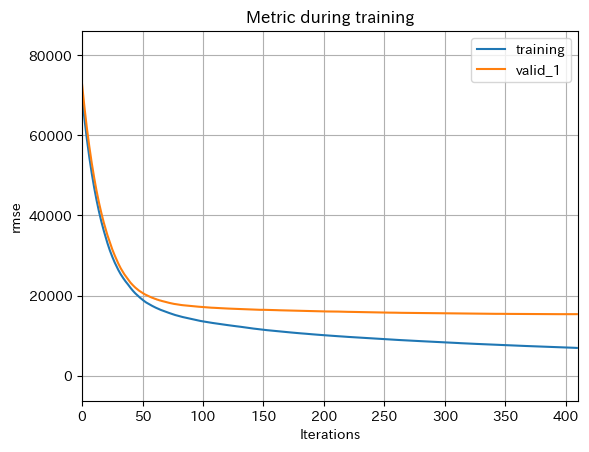

,importance
面積,4.539888e+14
L,3.945763e+14
平均地価,2.012726e+14
最寄り駅,9.450401e+13
築年数,6.747675e+13
所在地,3.599423e+13
全体の階数,2.991885e+13
一部屋あたりの面積,2.486889e+13
契約期間,1.392270e+13
所在階,1.135374e+13


In [11]:
n_split = 5
cv = KFold(n_splits=n_split, shuffle=True, random_state=0)
valid_rmses_list = []
valid_GBDT = np.zeros(X_train.shape[0])
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index,:]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train.loc[train_index]
    y_val = y_train.loc[valid_index]

    evals_result = {} 
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

    params = {
        'objective':'regression',
        'boosting_type':'gbdt',
        'metrics':'rmse',
        'learning_rate':0.05,
        'reg_lambda':  5.009615137983937e-06,
        'max_bin': 346,
        'num_leaves': 91,
    }

    print('Start training...')
    model = lgb.train(
                        params,
                        lgb_train, 
                        valid_sets=[lgb_train, lgb_eval], 
                        verbose_eval=10, 
                        num_boost_round=1000, 
                        early_stopping_rounds=10,
                        categorical_feature = category_lists,
                        evals_result=evals_result,
                        )

    pred_y_val = model.predict(X_val)
    rmse = mean_squared_error(y_val, pred_y_val, squared=False)
    valid_rmses_list.append(rmse)

valid_rmse = np.mean(valid_rmses_list)
print("whole valid rmse:", valid_rmse)

print('Start predicting...')
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
print('Plot metrics during training...')
ax = lgb.plot_metric(evals_result, metric='rmse')
plt.show()
# feature importanceを表示
importance = pd.DataFrame(model.feature_importance(importance_type = "gain"), index=X_train.columns, columns=['importance'])
df_importance = pd.DataFrame(importance)
df_importance = df_importance.sort_values('importance', ascending=False) # 降順ソート
display(df_importance)

In [12]:
df = pd.read_csv('../data/outer_data/test.csv')
id = df['id']
y_pred = pd.DataFrame(y_pred)
result = pd.concat([id, y_pred],axis=1)
result.to_csv('../data/result_data/GBDT_cv_result.csv',index=False)

### GBDTでは現状、16729が最良のスコア